# Import Libraries and Data

In [ ]:
library("dplyr")
library("ggplot2")
library('tidyverse')
library(readxl)
library(survival)
library(ggpubr)
library(fitdistrplus)
library(car)
library(FSA)
library(loo)
library(brms)
library(ranger)
library(caret)
library(randomForest)
library(merTools)
library(DiceKriging)
library(GauPro)
library(kernlab)
library(lme4)
library(segmented)
library(lmerTest)

library(MuMIn)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: MASS


Attaching package: 'MASS'


The following object is masked from 'package:dplyr':

    select


Loading required package: carData


Attaching package: 'car'


The following object is masked from 'package:purrr':

    some


The following object is masked from 'package:dplyr':

    r

In [ ]:
# Wait 1 minute for kernel to connect
CVB5_no <- read_excel('Virus.xlsx',sheet = "Figure_1a")
CVB5_w <- read_excel('Virus.xlsx',sheet = "Figure_1b")
Keegan <- data.frame(
  x = c(3, 4, 5, 6),
  y = c(1, 2, 3, 4)
)

In [ ]:
cl_lit <- read_excel('Virus.xlsx',sheet = 'Lit_Review')
cl_fit <- cl_lit %>% filter(Paper !='Torii_2020' & Paper != 'EPA' & Sample != 'This_Study_noNH3_2'
 & Sample != 'This_Study_noNH3_3' & Paper != 'Chaplin' & Paper != 'Bayesian' & Paper != 'RF' & Paper!= 'GPR')

In [ ]:
fig_dir <- '/Users/almab/OneDrive/Desktop/Virus_Project/Virus_Figures/'

# Figure 1

In [ ]:
CVB5_w <- CVB5_w %>%
  mutate(dye_detect = paste(Dye, Detect, sep = " ")) %>% filter(!is.na(CT))

In [ ]:
CVB5_w <- CVB5_w %>% mutate(dye_detect = ifelse(dye_detect == "DPD Y", "DPD - Detect", dye_detect)) %>% 
       mutate(dye_detect = ifelse(dye_detect == "DPD N", "DPD - Non Detect", dye_detect)) %>% 
       mutate(dye_detect = ifelse(dye_detect == "Indo Y", "Indo - Detect", dye_detect)) %>% 
       mutate(dye_detect = ifelse(dye_detect == "Indo N", "Indo - Non Detect", dye_detect)) %>% 
       mutate(dye_detect = ifelse(dye_detect == "Keegan Y", "Keegan", dye_detect))

CVB5_w <- CVB5_w[, !names(CVB5_w) %in% c("Detect", "num")]

In [ ]:
CVB5_no <- CVB5_no %>% mutate(dye_detect = ifelse(Dye == "DPD", "DPD - Detect", Dye)) %>% 
       mutate(dye_detect = ifelse(Dye == "Indo", "Indo - Detect", Dye)) %>% 
       mutate(dye_detect = ifelse(Dye == "Keegan", "Keegan", Dye)) 

In [ ]:
# Add a "Source" column before combining datasets
CVB5_no <- CVB5_no %>% mutate(Source = "CVB5_no")
CVB5_w <- CVB5_w %>% filter(Dye == "Indo") %>% mutate(Source = "CVB5_w")
# Combine datasets, filter for Dye == "Indo" or Dye == "Keegan", and add a new column
CVB5_combined <- rbind(CVB5_no, CVB5_w) %>%
  filter(Dye %in% c("Indo", "Keegan")) %>%
  mutate(Ammonia_Status = ifelse(Source == "CVB5_no", "No ammonia", "With ammonia")) %>%
  mutate(Ammonia_Status =ifelse(Dye == "Keegan", "Keegan", Ammonia_Status)) %>%
mutate(Ammonia_Status = factor(Ammonia_Status, levels = c("No ammonia", "With ammonia", "Keegan")))


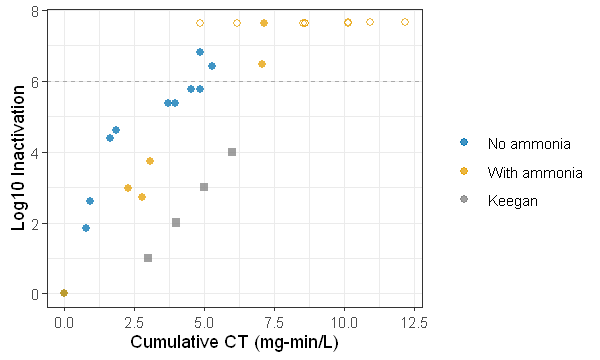

In [ ]:
options(repr.plot.width=5, repr.plot.height=3)
#dev.new(width = 4, height = 2.5, unit = "in")
#dev.off()
# Plot
Figure_1 <- ggplot(CVB5_combined, 
                   aes(x=CT, y=LRV, color=Ammonia_Status, shape=dye_detect)) +  
 scale_color_manual(values = c("No ammonia" = "#0072B2", 
                               "With ammonia" = "#E69F00",
                              "Keegan" = "#808080")) +  # Green for "With ammonia"
 geom_point(size=2, alpha = 0.75) +
 scale_shape_manual(
    values = c("Indo" = 16, "Indo - Detect" = 16, "Indo - Non Detect" = 1, 
               "Keegan" = 15)) +    

 labs(x="Cumulative CT (mg-min/L)", y="Log10 Inactivation", shape='', color='') + 
 geom_hline(aes(yintercept = 6), linetype = "dashed", color = "darkgray") +
 guides(shape = "none") +
 theme_bw() #+
 #theme(text = element_text(size = 10), axis.text = element_text(size = 10), legend.text = element_text(size = 10))

Figure_1

ggsave(filename = file.path(fig_dir, "Figure_1.png"), 
       plot = Figure_1, 
       width = unit(5, "in"), 
       height = unit(3, "in"), 
       dpi = 300)

## Tests

### Log Fit of No NH3 Data

In [63]:
CVB5_no$LRV <- log(10^(CVB5_no$LRV))
#CVB5_no

In [66]:
y<- CVB5_no[CVB5_no$Dye == 'Indo'& CVB5_no$LRV !=0,]$LRV
x<- CVB5_no[CVB5_no$Dye == 'Indo'& CVB5_no$LRV !=0,]$CT

nls_no_NH3 <- nls(y ~ a * log(x) + b, start = list(a = 2, b = 2))

# Summary of the model
summary(nls_no_NH3)
AIC(nls_no_NH3)

coef_no_NH3 <- coef(nls_no_NH3)
a0 <- coef_no_NH3['a']
b0 <- coef_no_NH3['b']



Formula: y ~ a * log(x) + b

Parameters:
  Estimate Std. Error t value Pr(>|t|)    
a   4.8653     0.4636   10.49 5.91e-06 ***
b   6.5278     0.5551   11.76 2.50e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.015 on 8 degrees of freedom

Number of iterations to convergence: 1 
Achieved convergence tolerance: 1.299e-08


[1] 32.4381

In [67]:
y<- CVB5_no[CVB5_no$Dye == 'DPD'& CVB5_no$LRV !=0,]$LRV
x<- CVB5_no[CVB5_no$Dye == 'DPD'& CVB5_no$LRV !=0,]$CT

model <- nls(y ~ a * log(x) + b, start = list(a = 2, b = 2))

# Summary of the model
summary(model)


Formula: y ~ a * log(x) + b

Parameters:
  Estimate Std. Error t value Pr(>|t|)    
a   4.4461     0.4121  10.788 4.81e-06 ***
b   5.8817     0.5902   9.965 8.71e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9889 on 8 degrees of freedom

Number of iterations to convergence: 1 
Achieved convergence tolerance: 1.603e-08


### Log Fit vs. NH3

In [68]:
filt<- CVB5_w[CVB5_w$Detect == 'Y' & CVB5_w$LRV !=0 & CVB5_w$Dye =='Indo',]

In [69]:
filt$CT_new[filt$Dye == 'Indo'] <- exp((filt[filt$Dye == 'Indo',]$LRV-6.5278 )/4.8653)
#filt$CT_new[filt$Dye == 'DPD'] <- exp((filt[filt$Dye == 'DPD',]$LRV-2.5544 )/1.9309)

Warning message:
"Unknown or uninitialised column: `CT_new`."


In [70]:
wilcox.test(filt$CT, filt$CT_new, paired = TRUE)


	Wilcoxon signed rank exact test

data:  filt$CT and filt$CT_new
V = 15, p-value = 0.0625
alternative hypothesis: true location shift is not equal to 0


### Log fit of NH3 Data

In [71]:
y<- CVB5_w[CVB5_w$Dye == 'Indo'& CVB5_w$LRV !=0,]$LRV
x<- CVB5_w[CVB5_w$Dye == 'Indo'& CVB5_w$LRV !=0,]$CT

nls_NH3_2 <- nls(y ~ a * log(x) + b, start = list(a = a0, b = b0))

# Summary of the model
summary(nls_NH3_2)

coef_NH3_2 <- coef(nls_NH3_2)
a_NH3_2 <- coef_NH3_2['a']
b_NH3_2 <- coef_NH3_2['b']


Formula: y ~ a * log(x) + b

Parameters:
  Estimate Std. Error t value Pr(>|t|)    
a   3.1902     0.4568   6.983 1.47e-05 ***
b   0.6071     0.8893   0.683    0.508    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8836 on 12 degrees of freedom

Number of iterations to convergence: 1 
Achieved convergence tolerance: 9.387e-08


In [72]:
y<- CVB5_w[CVB5_w$Dye == 'DPD'& CVB5_w$LRV !=0,]$LRV
x<- CVB5_w[CVB5_w$Dye == 'DPD'& CVB5_w$LRV !=0,]$CT

model <- nls(y ~ a * log(x) + b, start = list(a = 2, b = 2))

# Summary of the model
summary(model)


Formula: y ~ a * log(x) + b

Parameters:
  Estimate Std. Error t value Pr(>|t|)   
a   2.2997     0.5937   3.874  0.00221 **
b   2.7143     1.1302   2.402  0.03342 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.086 on 12 degrees of freedom

Number of iterations to convergence: 1 
Achieved convergence tolerance: 1.383e-08
  (1 observation deleted due to missingness)


### Plotting Fits

Logistic:
In this model, the parameters a and b are defined as 2.1130 and 2.8350, respectively. 


To assess the impact of ammonia, we introduced two key constants: k_1 and k_2, with k_1 calculated as 0.538629 and k_2 being a negative value represented as -1.113928. The parameter a is computed using the equation a = a_0 + k_1[NH3], while b is modeled as b = b_0 +k_2[NH3], where [NH3] is the concentration of ammonia. 

In [102]:
data_no_nh3 <- CVB5_no[CVB5_no$Dye == 'Indo'& CVB5_no$LRV !=0,]
data_with_nh3<- CVB5_w %>% filter(Dye == 'Indo'& LRV !=0) %>% mutate(NH3 = 2)

In [74]:
# Define the Weibull model function
weibull_model <- function(CT, lambda, k) {
  return(- (CT / lambda)^k)  # Computes log reduction value (LRV)
}

weibull_fit <- nls(LRV ~ weibull_model(CT, lambda, k),
                   data = data_no_nh3,
                   start = list(lambda = median(data_no_nh3$CT), k = 1),
                   algorithm = "port",  # More robust fitting
                   lower = list(lambda = 0.001, k = 0.1),  # Avoid division by zero
                   upper = list(lambda = max(data_no_nh3$CT), k = 5))  # Prevent extreme values

# Summary of the fit
summary(weibull_fit)

# Calculate the AIC of the fitted model
aic_value <- AIC(weibull_fit)
print(paste("AIC of the Weibull model:", aic_value))




Formula: LRV ~ weibull_model(CT, lambda, k)

Parameters:
       Estimate Std. Error t value Pr(>|t|)
lambda    5.295     12.873   0.411    0.692
k         5.000    126.423   0.040    0.969

Residual standard error: 13.63 on 8 degrees of freedom

Algorithm "port", convergence message: relative convergence (4)


[1] "AIC of the Weibull model: 84.3910830922249"


In [75]:
# Fit the corrected Gompertz model
gompertz_fit <- nls(LRV ~ A * exp(-b * exp(-c * CT)),
                    data = data_no_nh3,
                    start = list(A = max(data_no_nh3$LRV), b = 2, c = 1))

# Summary of the fit
summary(gompertz_fit)
# Calculate the AIC of the fitted model
aic_value <- AIC(gompertz_fit)
print(paste("AIC of the Gompertz model:", aic_value))





Formula: LRV ~ A * exp(-b * exp(-c * CT))

Parameters:
  Estimate Std. Error t value Pr(>|t|)    
A  13.8404     0.5270  26.265 2.97e-08 ***
b   2.9009     1.1211   2.588  0.03607 *  
c   1.2913     0.3604   3.583  0.00894 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.103 on 7 degrees of freedom

Number of iterations to convergence: 9 
Achieved convergence tolerance: 8.151e-06


[1] "AIC of the Gompertz model: 34.7809124039167"


In [76]:
# Step 1: Fit the linear model without ammonia
#data_no_nh3 <- read.csv("data_no_ammonia.csv")  # Load your dataset without ammonia
fit_linear <- lm(LRV ~ log(CT), data = data_no_nh3)

# Step 2: Fit the logistic model without ammonia
logistic_model <- function(logCT, L, k, x0) {
  L / (1 + exp(-k * (logCT - x0)))
}

fit_logistic <- nls(LRV ~ logistic_model(log(CT), L, k, x0),
                    data = data_no_nh3,
                    start = list(L = max(data_no_nh3$LRV), k = 1, x0 = median(log(data_no_nh3$CT))))

# Step 3: Calculate AIC and BIC for both models
AIC_linear <- AIC(fit_linear)
AIC_logistic <- AIC(fit_logistic)

BIC_linear <- BIC(fit_linear)
BIC_logistic <- BIC(fit_logistic)

# Step 4: Compare the models
cat("Linear Model - AIC:", AIC_linear, " BIC:", BIC_linear, "\n")
cat("Logistic Model - AIC:", AIC_logistic, " BIC:", BIC_logistic, "\n")

# Step 5: Determine the better model
if (AIC_logistic < AIC_linear) {
  cat("The logistic model is preferred based on AIC.\n")
} else {
  cat("The linear model is preferred based on AIC.\n")
}

if (BIC_logistic < BIC_linear) {
  cat("The logistic model is preferred based on BIC.\n")
} else {
  cat("The linear model is preferred based on BIC.\n")
}

Linear Model - AIC: 32.4381  BIC: 33.34586 
Logistic Model - AIC: 32.98294  BIC: 34.19328 
The linear model is preferred based on AIC.
The linear model is preferred based on BIC.


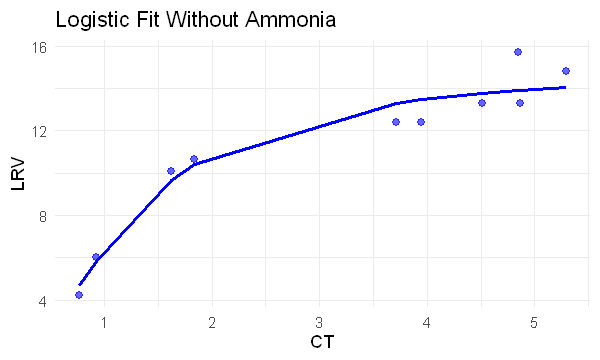

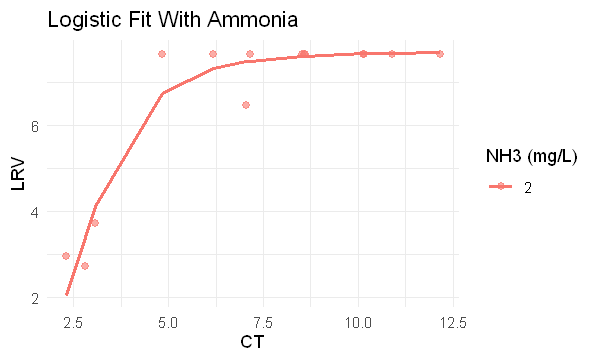

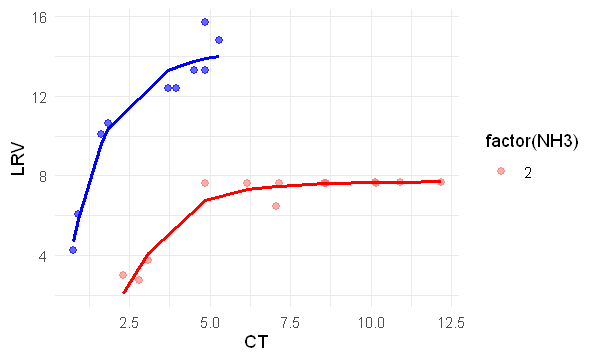

In [103]:
# Step 1: Define the logistic model
logistic_model <- function(logCT, L, k, x0) {
  L / (1 + exp(-k * (logCT - x0)))
}

# Step 2: Fit the logistic model to the dataset without ammonia
#data_no_nh3 <- read.csv("data_no_ammonia.csv")  # Load your dataset without ammonia

# Fit the logistic model using nls
fit_logistic_no_nh3 <- nls(LRV ~ logistic_model(log(CT), L, k, x0),
                           data = data_no_nh3,
                           start = list(L = max(data_no_nh3$LRV), k = 1, x0 = median(log(data_no_nh3$CT))))

# Extract parameters for the no-ammonia fit
L0 <- coef(fit_logistic_no_nh3)["L"]
k0 <- coef(fit_logistic_no_nh3)["k"]
x00 <- coef(fit_logistic_no_nh3)["x0"]

# Step 3: Fit the logistic model to the dataset with ammonia
#data_with_nh3 <- read.csv("data_with_ammonia.csv")  # Load your dataset with ammonia

# Modify the logistic model to include ammonia effects
logistic_model_with_nh3 <- function(logCT, NH3, L0, k0, x00, k1, k2, k3) {
  L <- L0 + k1 * NH3
  k <- k0 + k2 * NH3
  x0 <- x00 + k3 * NH3
  L / (1 + exp(-k * (logCT - x0)))
}

# Fit the modified logistic model using nls
fit_logistic_with_nh3 <- nls(LRV ~ logistic_model_with_nh3(log(CT), NH3, L0, k0, x00, k1, k2, k3),
                             data = data_with_nh3,
                             start = list(k1 = 0, k2 = 0, k3 = 0))  # Provide initial guesses for k1, k2, k3

# Extract parameters for the with-ammonia fit
k1_est <- coef(fit_logistic_with_nh3)["k1"]
k2_est <- coef(fit_logistic_with_nh3)["k2"]
k3_est <- coef(fit_logistic_with_nh3)["k3"]

# Step 4: Generate predicted values for plotting
# For the no-ammonia dataset
data_no_nh3$predicted_no_nh3 <- predict(fit_logistic_no_nh3, newdata = data_no_nh3)

# For the with-ammonia dataset
data_with_nh3$predicted_with_nh3 <- predict(fit_logistic_with_nh3, newdata = data_with_nh3)

# Step 5: Plot the logistic curves
# Plot for the no-ammonia dataset
plot_no_nh3 <- ggplot(data_no_nh3, aes(x = CT, y = LRV)) +
  geom_point(color = "blue", alpha = 0.6, size = 2) +  # Original data points
  geom_line(aes(y = predicted_no_nh3), color = "blue", size = 1) +  # Fitted logistic curve
  labs(title = "Logistic Fit Without Ammonia",
       x = "CT",
       y = "LRV") +
  theme_minimal()

print(plot_no_nh3)

# Plot for the with-ammonia dataset
plot_with_nh3 <- ggplot(data_with_nh3, aes(x = CT, y = LRV)) +
  geom_point(aes(color = factor(NH3)), alpha = 0.6, size = 2) +  # Original data points, colored by NH3 concentration
  geom_line(aes(y = predicted_with_nh3, color = factor(NH3)), size = 1) +  # Fitted logistic curve
  labs(title = "Logistic Fit With Ammonia",
       x = "CT",
       y = "LRV",
       color = "NH3 (mg/L)") +
  theme_minimal()

print(plot_with_nh3)

# Step 6: Combine the plots (optional)
# Overlay both logistic fits on the same plot for comparison
combined_plot <- ggplot() +
  geom_point(data = data_no_nh3, aes(x = CT, y = LRV), color = "blue", alpha = 0.6, size = 2) +  # Data without ammonia
  geom_line(data = data_no_nh3, aes(x = CT, y = predicted_no_nh3), color = "blue", size = 1) +  # Logistic fit without ammonia
  geom_point(data = data_with_nh3, aes(x = CT, y = LRV, color = factor(NH3)), alpha = 0.6, size = 2) +  # Data with ammonia
  geom_line(data = data_with_nh3, aes(x = CT, y = predicted_with_nh3), color = "red", size = 1)  + # Logistic fit with ammonia
  theme_minimal()
combined_plot

In [105]:
AIC(fit_logistic_no_nh3)
AIC(fit_logistic_with_nh3)

[1] 32.98294

[1] 27.84472

In [120]:
log_LRV <- log(data_no_nh3$LRV)
log_CT <- log(data_no_nh3$CT)
lm_fit <- lm(log_LRV ~ log_CT)

# Extract initial guesses
alpha_start <- -coef(lm_fit)[2]  # Slope of the linear fit
beta_start <- exp(coef(lm_fit)[1]/alpha_start)
alpha_start
beta_start

log_CT 
-0.5419709

(Intercept) 
 0.03433685

In [121]:
# Step 1: Define the gamma model
gamma_model <- function(x, alpha, beta) {
  if (beta <= 0) return(NA)
    (1 + x / beta)^(-alpha)
}

# Step 2: Fit the gamma model to the dataset without ammonia
fit_gamma_no_nh3 <- nls(LRV ~ gamma_model(CT, alpha, beta),
                        data = data_no_nh3,
                        start = list(alpha = -0.54, beta = 0.034))  

In [122]:
AIC(fit_gamma_no_nh3)
BIC(fit_gamma_no_nh3)

[1] 36.28336

[1] 37.19112

In [92]:
# Robust implementation of the Lambert W function (principal branch)
lambertW <- function(x) {
  sapply(x, function(xi) {
    # Check if the input is within the domain of the Lambert W function
    if (xi < -1/exp(1)) {
      stop("Input value is outside the domain of the Lambert W function.")
    }
    if (xi == 0) {
      return(0)
    }
    
    # Initial guess for W(x)
    if (xi < -0.35) {
      # Use a better initial guess for values close to the lower bound
      w <- -1 + sqrt(2 * (1 + exp(1) * xi))
    } else {
      w <- log(xi + 1)  # Default initial guess
    }
    
    # Newton-Raphson iteration
    for (i in 1:100) {
      ew <- exp(w)
      denominator <- (ew + w * ew)
      
      # Avoid division by zero or very small numbers
      if (abs(denominator) < 1e-10) {
        stop("Newton-Raphson iteration failed: denominator too small.")
      }
      
      w_new <- w - (w * ew - xi) / denominator
      
      # Check for convergence or invalid values
      if (is.na(w_new) || is.infinite(w_new)) {
        stop("Newton-Raphson iteration failed to converge: invalid value encountered.")
      }
      if (abs(w_new - w) < 1e-10) {
        return(w_new)
      }
      w <- w_new
    }
    stop("Newton-Raphson iteration failed to converge: maximum iterations reached.")
  })
}

In [97]:
# Step 1: Define the lognormal model
lognormal_model <- function(x, mu, sd) {
  # Compute the argument for the Lambert W function
  arg <- (exp(mu) * (sd^2) * x)
  
  # Compute the Lambert W function
  W_val <- lambertW(arg)  # Use the robust Lambert W function
  
  # Compute the model output
  y <- (1 / sqrt(1 + W_val)) * exp(-(W_val^2 + 2 * W_val) / (2 * sd^2))
  return(y)
}

# Step 2: Define the objective function (RSS)
objective_function <- function(params) {
  mu <- params[1]
  sd <- params[2]
  predicted <- lognormal_model(data_no_nh3$CT, mu, sd)
  rss <- sum((data_no_nh3$LRV - predicted)^2)
  return(rss)
}

# Step 3: Perform a grid search for initial guesses
mu_grid <- seq(0.01, 5, length.out = 10)
sd_grid <- seq(0.01, 5, length.out = 10)
best_mu <- NA
best_sd <- NA
best_rss <- Inf

for (mu in mu_grid) {
  for (sd in sd_grid) {
    predicted <- lognormal_model(data_no_nh3$CT, mu, sd)
    rss <- sum((data_no_nh3$LRV - predicted)^2)
    if (rss < best_rss) {
      best_mu <- mu
      best_sd <- sd
      best_rss <- rss
    }
  }
}

# Step 4: Use optim for robust fitting
result <- optim(par = c(best_mu, best_sd),  # Initial guesses
                fn = objective_function,    # Objective function
                method = "L-BFGS-B",        # Optimization method
                lower = c(0.01, 0.01),        # Lower bounds for mu and sd
                upper = c(10, 10))          # Upper bounds for mu and sd

# Extract the optimized parameters
mu0 <- result$par[1]
sd0 <- result$par[2]

# Print the optimized parameters
cat("Optimized mu:", mu0, "\n")
cat("Optimized sd:", sd0, "\n")


Optimized mu: 0.01 
Optimized sd: 10 


[1] 0.4495108 0.4398226 0.4105030 0.4044069 0.3717675 0.3690547 0.3632123
 [8] 0.3599905 0.3601232 0.3563704

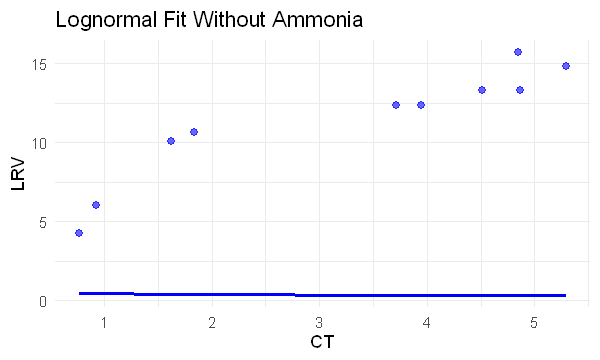

In [98]:
# Step 6: Fit the lognormal model to the dataset without ammonia

data_no_nh3$predicted_no_nh3 <- lognormal_model(data_no_nh3$CT, 0.01, 10)
data_no_nh3$predicted_no_nh3
# Step 7: Plot the lognormal curve
plot_no_nh3 <- ggplot(data_no_nh3, aes(x = CT, y = LRV)) +
  geom_point(color = "blue", alpha = 0.6, size = 2) +  # Original data points
  geom_line(aes(y = predicted_no_nh3), color = "blue", size = 1) +  # Fitted lognormal curve
  labs(title = "Lognormal Fit Without Ammonia",
       x = "CT",
       y = "LRV") +
  theme_minimal()

print(plot_no_nh3)

In [99]:
# Step 1: Compute the residuals
residuals <- data_no_nh3$LRV - data_no_nh3$predicted_no_nh3

# Step 2: Compute the variance of the residuals
sigma2 <- var(residuals)

# Step 3: Compute the log-likelihood
n <- nrow(data_no_nh3)  # Number of observations
log_likelihood <- -n/2 * log(2 * pi) - n/2 * log(sigma2) - 1/(2 * sigma2) * sum(residuals^2)

# Step 4: Compute the AIC
k <- 2  # Number of parameters (mu and sd)
AIC_value <- 2 * k - 2 * log_likelihood

# Print the AIC
cat("AIC for the lognormal model:", AIC_value, "\n")

AIC for the lognormal model: 143.8187 


### Percent Diff

In [77]:
Indo <- data.frame(One=c(0.00,0.92,1.84,3.95,4.87,5.30), Two=c(0.00,0.77,1.63,3.72,4.52,4.85))
Indo_pd <- Indo %>%mutate(Pd12 = abs(One - Two) / ((One + Two) / 2) * 100)

In [79]:
DPD <- data.frame(One=c(0.00,0.92,2.32,5.25,6.32,7.03), Two=c(0.00,0.91,2.18,4.98,5.93,6.47))
DPD_pd <- DPD %>%mutate(Pd12 = abs(One - Two) / ((One + Two) / 2) * 100)

In [80]:
Indo_pd
DPD_pd

One,Two,Pd12
<dbl>,<dbl>,<dbl>
0.00,0.00,NaN
0.92,0.77,17.751479
1.84,1.63,12.103746
3.95,3.72,5.997392
4.87,4.52,7.454739
5.30,4.85,8.866995


One,Two,Pd12
<dbl>,<dbl>,<dbl>
0.00,0.00,NaN
0.92,0.91,1.092896
2.32,2.18,6.222222
5.25,4.98,5.278592
6.32,5.93,6.367347
7.03,6.47,8.296296


In [81]:
wilcox.test(Indo_pd$Pd12, DPD_pd$Pd12)


	Wilcoxon rank sum exact test

data:  Indo_pd$Pd12 and DPD_pd$Pd12
W = 21, p-value = 0.09524
alternative hypothesis: true location shift is not equal to 0


#### Ammonia

In [84]:
Indo <- data.frame(One=c(0.00,3.08,6.18,8.61,10.15,12.18), Two=c(0.00,2.80,NA,7.05,8.59,10.90),
                   Three=c(0.00,2.30,4.85,7.15,8.54,10.13))
Indo_pd_am <- Indo %>%mutate(Pd12 = abs(One - Two) / ((One + Two) / 2) * 100) %>%
        mutate(Pd13 = abs(One - Three) / ((One + Three) / 2) * 100)%>%
        mutate(Pd32 = abs(Three - Two) / ((Three + Two) / 2) * 100)


Indo_pd_am <- Indo_pd_am %>%
  pivot_longer(cols = starts_with("Pd"), names_to = "pair", values_to = "percent_diff")

  
  

In [85]:
DPD <- data.frame(One=c(0.00,3.55,6.53,8.68,10.13,11.64), Two=c(0.00,NA,5.10,7.35,8.94,10.16),
                   Three=c(0.00,1.90,3.58,5.10,6.51,8.47))
DPD_pd_am <- DPD %>%mutate(Pd12 = abs(One - Two) / ((One + Two) / 2) * 100) %>%
        mutate(Pd13 = abs(One - Three) / ((One + Three) / 2) * 100)%>%
        mutate(Pd32 = abs(Three - Two) / ((Three + Two) / 2) * 100)

DPD_pd_am <- DPD_pd_am %>%
  pivot_longer(cols = starts_with("Pd"), names_to = "pair", values_to = "percent_diff")

  DPD_pd_am

One,Two,Three,pair,percent_diff
<dbl>,<dbl>,<dbl>,<chr>,<dbl>
0.00,0.00,0.00,Pd12,NaN
0.00,0.00,0.00,Pd13,NaN
0.00,0.00,0.00,Pd32,NaN
3.55,NA,1.90,Pd12,NA
3.55,NA,1.90,Pd13,60.55046
3.55,NA,1.90,Pd32,NA
6.53,5.10,3.58,Pd12,24.59157
6.53,5.10,3.58,Pd13,58.35806
6.53,5.10,3.58,Pd32,35.02304


In [89]:
Indo_pd_am$percent_diff
DPD_pd_am$percent_diff

[1]        NaN        NaN        NaN  9.5238095 28.9962825 19.6078431
 [7]         NA 24.1160471         NA 19.9233716 18.5279188  1.4084507
[13] 16.6488794 17.2284644  0.5837712 11.0918544 18.3774092  7.3228721

[1]      NaN      NaN      NaN       NA 60.55046       NA 24.59157 58.35806
 [9] 35.02304 16.59389 51.95936 36.14458 12.48034 43.50962 31.45631 13.57798
[17] 31.52660 18.14278

In [87]:
wilcox.test(Indo_pd_am$percent_diff, DPD_pd_am$percent_diff)


	Wilcoxon rank sum exact test

data:  Indo_pd_am$percent_diff and DPD_pd_am$percent_diff
W = 31, p-value = 0.005072
alternative hypothesis: true location shift is not equal to 0


# Figure S1

In [222]:
cl_no <- read_excel('Virus.xlsx',sheet = "Figure_S1a")
cl_w <- read_excel('Virus.xlsx',sheet = "Figure_S1b")

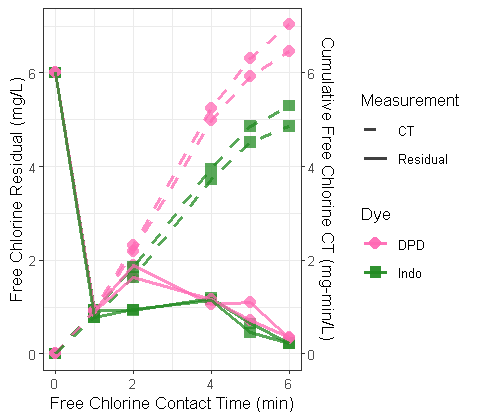

In [145]:
options(repr.plot.width=4, repr.plot.height=3.5)

Figure_S6a <- ggplot(cl_no, 
                   aes(x=Time,color = Dye, shape = Dye,group = interaction(Dye, Replicate)))+  
 scale_color_manual(values = c("DPD" = "#FF69B4",  "Indo" = "#228B22")) + # Custom colors for treatment
 geom_point(aes(y = Residual), size=3, alpha =0.75)+
 geom_point(aes(y = CT), size=3, alpha =0.75)+
 geom_line(size=1, alpha =0.75, aes(y = CT, linetype = "CT")) +   # Line for y2
 geom_line(size=1, alpha =0.75, aes(y = Residual, linetype = "Residual")) +   # Line for y1
 scale_linetype_manual(values = c("CT" = "dashed", "Residual" = "solid")) +  # Different line types
 scale_shape_manual(
    values = c("DPD" = 16,   # Solid circle for DPD detected, open circle for DPD non-detect
               "Indo" = 15) ) +    # Solid square for C detected, open square for C non-detect
  scale_y_continuous(
    name = "Free Chlorine Residual (mg/L)",                     # Label for the primary y-axis
    sec.axis = sec_axis(~ . , name = "Cumulative Free Chlorine CT (mg-min/L)")  # Transformation for secondary y-axis
  ) +
 labs(x="Free Chlorine Contact Time (min)",linetype = "Measurement") + 
 theme_bw(base_size = 10 )+
 theme(axis.text.x = element_text( size=8),legend.position = "right")

Figure_S6a


 

Warning message:
"Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."


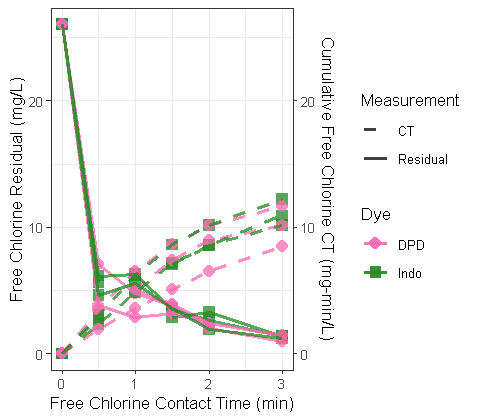

In [146]:
options(repr.plot.width=4, repr.plot.height=3.5)

Figure_S6b <- ggplot(cl_w, 
                   aes(x=Time,color = Dye, shape = Dye,group = interaction(Dye, Replicate)))+  
 scale_color_manual(values = c("DPD" = "#FF69B4",  "Indo" = "#228B22")) + # Custom colors for treatment
 geom_point(aes(y = Residual), size=3, alpha =0.75)+
 geom_point(aes(y = CT), size=3, alpha =0.75)+
 geom_line(size=1, alpha =0.75, aes(y = CT, linetype = "CT")) +   # Line for y2
 geom_line(size=1, alpha =0.75, aes(y = Residual, linetype = "Residual")) +   # Line for y1
 scale_linetype_manual(values = c("CT" = "dashed", "Residual" = "solid")) +  # Different line types
 scale_shape_manual(
    values = c("DPD" = 16,   # Solid circle for DPD detected, open circle for DPD non-detect
               "Indo" = 15) ) +    # Solid square for C detected, open square for C non-detect
  scale_y_continuous(
    name = "Free Chlorine Residual (mg/L)",                     # Label for the primary y-axis
    sec.axis = sec_axis(~ . , name = "Cumulative Free Chlorine CT (mg-min/L)")  # Transformation for secondary y-axis
  ) +
 labs(x="Free Chlorine Contact Time (min)",linetype = "Measurement") + 
 theme_bw(base_size = 10 )+
 theme(axis.text.x = element_text( size=8),legend.position = "right")

Figure_S6b


 

Warning message:
"Removed 3 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`)."
Warning message:
"Removed 1 row containing missing values or values outside the scale range
(`geom_line()`)."


ERROR: [1m[33mError[39m in `ggsave()`:[22m
[1m[22m[33m![39m Cannot find directory [34m/Users/almabartholow/Desktop/Virus_Figures[39m.
[36mℹ[39m Please supply an existing directory or use `create.dir = TRUE`.


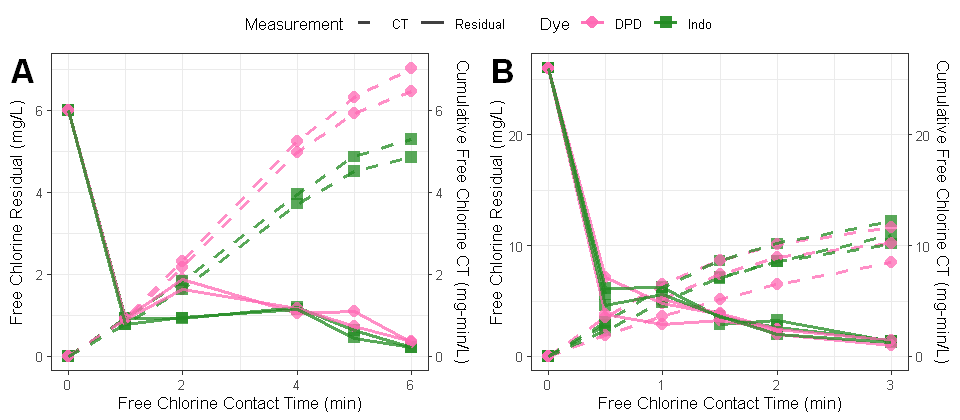

In [147]:
options(repr.plot.width = 8, repr.plot.height =3.5)
Figure_S6 <- ggarrange(Figure_S6a, Figure_S6b, ncol = 2, nrow=1,labels=c('A','B'), 
                      font.label = list(size = 20, color = "black", face = "bold", family = NULL), 
                      legend = "top", common.legend = T, align = c("hv"))
Figure_S6
# Save the stacked plot
ggsave(filename = file.path(fig_dir, "Figure_S6.png"),
       plot = Figure_S6, width = 8, height = 3.5, dpi = 300)



## Tests

In [148]:
cl_test <- rbind(cl_no,cl_w)

In [149]:
cl_indo<- as.numeric(unlist(cl_test[cl_test$Dye == "Indo", "Residual"] ))
cl_dpd<- as.numeric(unlist(cl_test[cl_test$Dye == "DPD", "Residual"] ))


In [150]:
valid_pairs <- complete.cases(cl_indo, cl_dpd) & cl_indo != cl_dpd
valid_pairs

[1] FALSE FALSE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE
[13] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE  TRUE  TRUE FALSE
[25] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE

In [151]:
wilcox.test(cl_indo[valid_pairs], cl_dpd[valid_pairs], paired = TRUE)



	Wilcoxon signed rank exact test

data:  cl_indo[valid_pairs] and cl_dpd[valid_pairs]
V = 107, p-value = 0.7854
alternative hypothesis: true location shift is not equal to 0


In [152]:
cl_indo<- as.numeric(unlist(cl_no[cl_no$Dye == "Indo", "Residual"] ))
cl_dpd<- as.numeric(unlist(cl_no[cl_no$Dye == "DPD", "Residual"] ))
valid_pairs <- complete.cases(cl_indo, cl_dpd) & cl_indo != cl_dpd
valid_pairs

[1] FALSE FALSE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE

In [153]:
wilcox.test(cl_indo[valid_pairs], cl_dpd[valid_pairs], paired = TRUE)



	Wilcoxon signed rank exact test

data:  cl_indo[valid_pairs] and cl_dpd[valid_pairs]
V = 3, p-value = 0.01953
alternative hypothesis: true location shift is not equal to 0


In [154]:
cl_indo<- as.numeric(unlist(cl_w[cl_w$Dye == "Indo", "Residual"] ))
cl_dpd<- as.numeric(unlist(cl_w[cl_w$Dye == "DPD", "Residual"] ))
valid_pairs <- complete.cases(cl_indo, cl_dpd) & cl_indo != cl_dpd
valid_pairs

[1] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE FALSE  TRUE  TRUE FALSE
[13] FALSE  TRUE  TRUE  TRUE  TRUE  TRUE

In [155]:
wilcox.test(cl_indo[valid_pairs], cl_dpd[valid_pairs], paired = TRUE)



	Wilcoxon signed rank exact test

data:  cl_indo[valid_pairs] and cl_dpd[valid_pairs]
V = 51, p-value = 0.3804
alternative hypothesis: true location shift is not equal to 0


Experiments without NH3 were staistically significant

# Figure 2

## Calc rate our experiment

### No Ammonia

In [ ]:
CVB5_rate <- CVB5_no %>% filter(Dye =='Indo')

Best threshold: 1.950789 
Largest slope change: 4.701304 


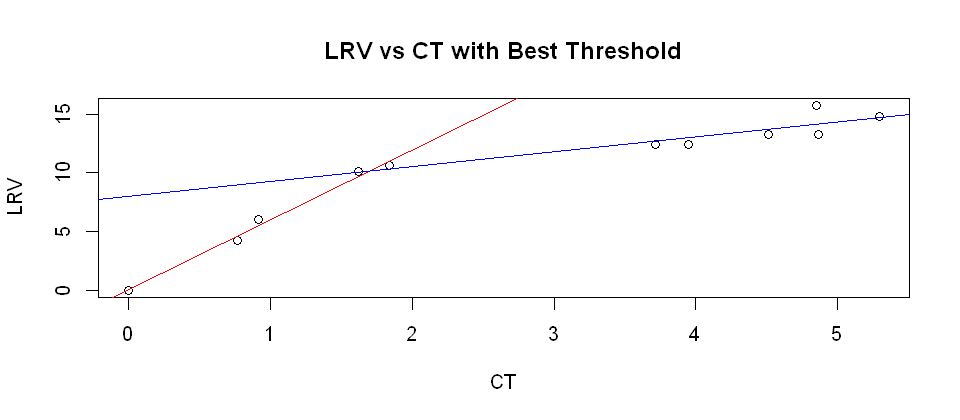

In [ ]:
# Step 1: Create a grid of possible threshold values (e.g., from min to max CT)
thresholds <- seq(min(CVB5_rate$CT), max(CVB5_rate$CT), length.out = 20)

# Initialize variables to store the best threshold and the largest slope change
best_threshold <- NULL
largest_slope_change <- -Inf  # Start with a very small value for the change in slope
best_model_before <- NULL
best_model_after <- NULL

# Set a small tolerance range around the threshold (e.g., 1 unit)
tolerance <- 1

# Step 2: Loop through the threshold values and calculate the slope change
for (threshold in thresholds) {
  # Subset data before and after the threshold, allowing for overlap of points near the threshold
  data_before <- subset(CVB5_rate, CT <= (threshold + tolerance))  # Include points just above threshold
  data_after <- subset(CVB5_rate, CT > (threshold - tolerance))   # Include points just below threshold
  
  # Check if both subsets have enough data points
  if (nrow(data_before) > 1 && nrow(data_after) > 1) {
    # Fit the linear models before and after the threshold
    model_before <- lm(LRV ~ CT, data = data_before)
    model_after <- lm(LRV ~ CT, data = data_after)
    
    # Step 3: Calculate the slopes of the two linear models
    slope_before <- coef(model_before)[2]
    slope_after <- coef(model_after)[2]
    
    # Check if slope_before and slope_after are not NA
    if (!is.na(slope_before) && !is.na(slope_after)) {
      # Calculate the absolute difference in slopes
      slope_diff <- abs(slope_before - slope_after)
      
      # Step 4: Update the best threshold if this threshold gives a larger change in slope
      if (slope_diff > largest_slope_change) {
        largest_slope_change <- slope_diff
        best_threshold <- threshold
        best_model_before <- model_before
        best_model_after <- model_after
      }
    }
  }
}

# Step 5: Output the best threshold and the associated models
cat("Best threshold:", best_threshold, "\n")
cat("Largest slope change:", largest_slope_change, "\n")

# Optionally: Plot the data with the best threshold and the two linear fits
plot(CVB5_rate$CT, CVB5_rate$LRV, main="LRV vs CT with Best Threshold", xlab="CT", ylab="LRV")
abline(best_model_before, col="red")  # Red line for model before the threshold
abline(best_model_after, col="blue")  # Blue line for model after the threshold

In [159]:
lm_model <- lm(LRV ~ CT, data = CVB5_rate)

# Fit the segmented regression model with one breakpoint
seg_model <- segmented(lm_model, seg.Z = ~CT)
print(seg_model$psi)
# Calculate AIC for the segmented model
aic_segmented <- AIC(seg_model)
print(aic_segmented)

slopes <- coef(seg_model)
print("Slopes for each segment:")
print(slopes)

        Initial  Est.    St.Err
psi1.CT      NA 1.625 0.2053172
[1] 31.10624
[1] "Slopes for each segment:"
(Intercept)          CT       U1.CT     psi1.CT 
-0.08517033  6.23098124 -4.97214369  0.00000000 


In [160]:
6.23098124 -4.97214369

[1] 1.258838

Warning message in geom_segment(data = data1, aes(x = min(CT), y = min(LRV), xend = max(CT), :
"All aesthetics have length 1, but the data has 4 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row."
Warning message in geom_segment(data = data2, aes(x = min(CT), y = min(LRV), xend = max(CT), :
"All aesthetics have length 1, but the data has 7 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row."


ERROR: [1m[33mError[39m in `ggsave()`:[22m
[1m[22m[33m![39m Cannot find directory [34m/Users/almabartholow/Desktop/Virus_Figures[39m.
[36mℹ[39m Please supply an existing directory or use `create.dir = TRUE`.


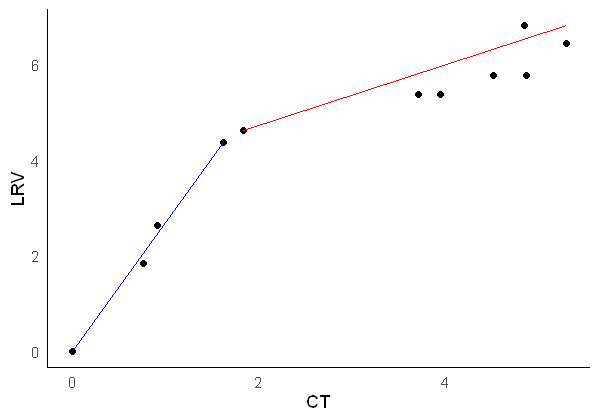

In [161]:

# Assume the breakpoint is at CT = 1.625
breakpoint <- 1.625

# Split data into two segments based on the breakpoint
CVB5_rate$LRV <- log10(exp(CVB5_rate$LRV))

data1 <- CVB5_rate[CVB5_rate$CT <= breakpoint, ]
data2 <- CVB5_rate[CVB5_rate$CT > breakpoint, ]

options(repr.plot.width=5, repr.plot.height=3.5)
# Create the plot
Figure_S7 <- ggplot(CVB5_rate, aes(x = CT, y = LRV)) +
  geom_point() +
  geom_segment(data = data1, aes(x = min(CT), y = min(LRV), xend = max(CT), yend = max(LRV)), color = "blue") +
  geom_segment(data = data2, aes(x = min(CT), y = min(LRV), xend = max(CT), yend = max(LRV)), color = "red") +
  labs( x = "CT", y = "LRV") +
  theme_minimal() +
 
  theme(legend.position = "bottom",
    panel.background = element_blank(),  # Remove background from the panel
    plot.background = element_blank(),   # Remove background from the whole plot
    panel.grid.major = element_blank(),  # Optional: remove major grid lines
    panel.grid.minor = element_blank(),  # Optional: remove minor grid lines
    axis.line = element_line(color = "black")  # Optional: add black axis lines
  ) 

Figure_S7
ggsave(filename = file.path(fig_dir, "Figure_S7.png"),
       plot = Figure_S7, width = 5, height = 3.5, dpi = 300)

In [162]:
CVB5_rate$LRV <- log(10^(CVB5_rate$LRV))

# Split the data into two segments based on the threshold
#data_segment1 <- CVB5_rate[CVB5_rate$CT <= 1.950789, ]
data_segment1 <- CVB5_rate[CVB5_rate$CT <= 1.625, ]
data_segment2 <- CVB5_rate[CVB5_rate$CT > 1.625, ]

# Fit linear models to each segment
model1 <- lm(LRV ~ CT, data = data_segment1)
model2 <- lm(LRV ~ CT, data = data_segment2)
modeltot <- lm(LRV ~ CT, data=CVB5_rate)
# Plotting and inspecting the models
summary(model1)
summary(model2)
summary(modeltot)

coef(model1)["CT"]
confint(model1)["CT", ]
coef(model2)["CT"]
confint(model2)["CT", ]
coef(modeltot)["CT"]
confint(modeltot)["CT", ]



Call:
lm(formula = LRV ~ CT, data = data_segment1)

Residuals:
       1        2        3        4 
 0.09036 -0.48638  0.38158  0.01444 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.09036    0.38660  -0.234  0.83693   
CT           6.24364    0.38279  16.311  0.00374 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4419 on 2 degrees of freedom
Multiple R-squared:  0.9925,	Adjusted R-squared:  0.9888 
F-statistic:   266 on 1 and 2 DF,  p-value: 0.003738



Call:
lm(formula = LRV ~ CT, data = data_segment2)

Residuals:
      1       2       3       4       5       6       7 
 0.3481 -0.2927 -0.5901 -0.3888 -0.8317  1.6049  0.1502 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   7.9639     1.3528   5.887  0.00201 **
CT            1.2655     0.3159   4.006  0.01026 * 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.894 on 5 degrees of freedom
Multiple R-squared:  0.7625,	Adjusted R-squared:  0.715 
F-statistic: 16.05 on 1 and 5 DF,  p-value: 0.01026



Call:
lm(formula = LRV ~ CT, data = CVB5_rate)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4025 -0.9481 -0.2371  0.7437  2.9492 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   3.4025     1.1078   3.071   0.0133 *  
CT            2.3309     0.3192   7.302 4.55e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.951 on 9 degrees of freedom
Multiple R-squared:  0.8556,	Adjusted R-squared:  0.8395 
F-statistic: 53.32 on 1 and 9 DF,  p-value: 4.555e-05


CT 
6.243637

2.5 %   97.5 % 
4.596616 7.890659

CT 
1.265506

2.5 %    97.5 % 
0.4535431 2.0774698

CT 
2.330929

2.5 %   97.5 % 
1.608810 3.053048

### Ammonia

In [163]:
CVB5_rate <- CVB5_w %>% filter(Dye =='Indo' )

In [164]:
CVB5_rate$LRV <- log(10^(CVB5_rate$LRV))
CVB5_rate

CT,LRV,Dye,Detect,num
<dbl>,<dbl>,<chr>,<chr>,<dbl>
0.0000,0.000000,Indo,Y,NA
2.3000,6.822762,Indo,Y,3
2.8000,6.272716,Indo,Y,2
3.0750,8.575301,Indo,Y,1
7.0500,14.898123,Indo,Y,2
7.1500,17.588473,Indo,Y,3
4.8500,17.588473,Indo,N,3
8.5375,17.588473,Indo,N,3
6.1750,17.588473,Indo,N,1


In [165]:
lm_model <- lm(LRV ~ CT, data = CVB5_rate)

# Fit the segmented regression model with one breakpoint
seg_model <- segmented(lm_model, seg.Z = ~CT)
print(seg_model$psi)
# Calculate AIC for the segmented model
aic_segmented <- AIC(seg_model)
print(aic_segmented)

slopes <- coef(seg_model)
print("Slopes for each segment:")
print(slopes)


        Initial    Est.    St.Err
psi1.CT      NA 5.12831 0.4187636
[1] 54.25261
[1] "Slopes for each segment:"
(Intercept)          CT       U1.CT     psi1.CT 
  -1.273297    3.502936   -3.334957    0.000000 


In [166]:
3.502936   -3.334957

[1] 0.167979

Warning message in geom_segment(data = data1, aes(x = min(CT), y = min(LRV), xend = max(CT), :
"All aesthetics have length 1, but the data has 4 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row."
Warning message in geom_segment(data = data2, aes(x = min(CT), y = min(LRV), xend = max(CT), :
"All aesthetics have length 1, but the data has 11 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing
  a single row."


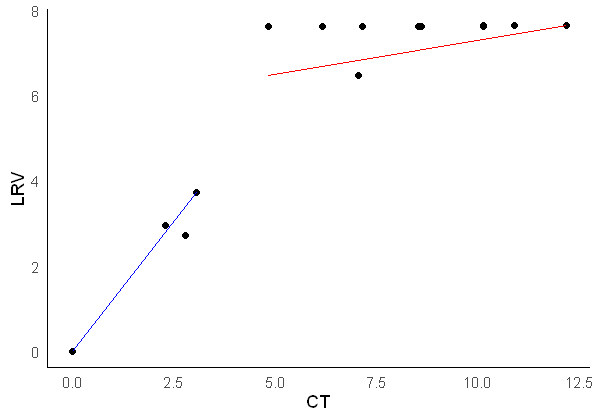

In [167]:
CVB5_rate$LRV <- log10(exp(CVB5_rate$LRV))
# Assume the breakpoint is at CT = 1.625
breakpoint <- 4.5

# Split data into two segments based on the breakpoint
data1 <- CVB5_rate[CVB5_rate$CT <= breakpoint, ]
data2 <- CVB5_rate[CVB5_rate$CT > breakpoint, ]

# Create the plot
ggplot(CVB5_rate, aes(x = CT, y = LRV)) +
  geom_point() +
  geom_segment(data = data1, aes(x = min(CT), y = min(LRV), xend = max(CT), yend = max(LRV)), color = "blue") +
  geom_segment(data = data2, aes(x = min(CT), y = min(LRV), xend = max(CT), yend = max(LRV)), color = "red") +
  labs( x = "CT", y = "LRV") +
  theme_minimal() +
 
  theme(legend.position = "bottom",
    panel.background = element_blank(),  # Remove background from the panel
    plot.background = element_blank(),   # Remove background from the whole plot
    panel.grid.major = element_blank(),  # Optional: remove major grid lines
    panel.grid.minor = element_blank(),  # Optional: remove minor grid lines
    axis.line = element_line(color = "black")  # Optional: add black axis lines
  ) 


In [168]:
log(10^(7.63857682515372))


[1] 17.58847

In [169]:
#CVB5_rate$LRV <- log(10^(CVB5_rate$LRV))

# Split the data into two segments based on the threshold
#data_segment1 <- CVB5_rate[CVB5_rate$CT <= 1.950789, ]
data_segment1 <- CVB5_rate[CVB5_rate$CT <= 4.5, ]
data_segment2 <- CVB5_rate[CVB5_rate$CT > 4.5, ]

# Fit linear models to each segment
model1 <- lm(LRV ~ CT, data = data_segment1)
model2 <- lm(LRV ~ CT, data = data_segment2)
modeltot <- lm(LRV ~ CT, data=CVB5_rate)
# Plotting and inspecting the models
summary(model1)
summary(model2)
summary(modeltot)

coef(model1)["CT"]
confint(model1)["CT", ]
coef(model2)["CT"]
confint(model2)["CT", ]
coef(modeltot)["CT"]
confint(modeltot)["CT", ]



Call:
lm(formula = LRV ~ CT, data = data_segment1)

Residuals:
       1        2        3        4 
-0.03719  0.31987 -0.48554  0.20287 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  0.03719    0.42756   0.087   0.9386  
CT           1.13305    0.17993   6.297   0.0243 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4362 on 2 degrees of freedom
Multiple R-squared:  0.952,	Adjusted R-squared:  0.928 
F-statistic: 39.65 on 1 and 2 DF,  p-value: 0.0243



Call:
lm(formula = LRV ~ CT, data = data_segment2)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.00531  0.03116  0.09959  0.13083  0.25250 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.18897    0.46371  15.503 8.47e-08 ***
CT           0.04064    0.05256   0.773    0.459    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3614 on 9 degrees of freedom
Multiple R-squared:  0.06228,	Adjusted R-squared:  -0.04191 
F-statistic: 0.5978 on 1 and 9 DF,  p-value: 0.4593



Call:
lm(formula = LRV ~ CT, data = CVB5_rate)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.0189 -0.7423 -0.1560  0.4370  2.6840 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.0189     0.7577   2.665   0.0195 *  
CT            0.6053     0.0990   6.114  3.7e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.322 on 13 degrees of freedom
Multiple R-squared:  0.742,	Adjusted R-squared:  0.7221 
F-statistic: 37.38 on 1 and 13 DF,  p-value: 3.697e-05


CT 
1.133055

2.5 %    97.5 % 
0.3588692 1.9072399

CT 
0.04064002

2.5 %      97.5 % 
-0.07826703  0.15954707

CT 
0.6052755

2.5 %    97.5 % 
0.3913957 0.8191553

In [170]:
CVB5_rate$LRV <- log(10^(CVB5_rate$LRV))

tobit_model <- survreg(Surv(LRV, LRV < 17.5884731292887, type = "right") ~ CT, dist = "gaussian", data = CVB5_rate)
summary(tobit_model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]



Call:
survreg(formula = Surv(LRV, LRV < 17.5884731292887, type = "right") ~ 
    CT, data = CVB5_rate, dist = "gaussian")
            Value Std. Error    z       p
(Intercept) 0.271      2.206 0.12 0.90221
CT          2.859      0.507 5.64 1.7e-08
Log(scale)  1.120      0.334 3.35 0.00081

Scale= 3.06 

Gaussian distribution
Loglik(model)= -14.9   Loglik(intercept only)= -25.5
	Chisq= 21.25 on 1 degrees of freedom, p= 4e-06 
Number of Newton-Raphson Iterations: 7 
n= 15 


CT 
2.859065

2.5 %   97.5 % 
1.864845 3.853285

## Import Other Experiment Rates

### Calculating Rate Constants

#### Sobsey

In [81]:
Sobsey_8 <- data.frame(
  time = c(0, 1, 2, 3, 10, 30),
  LRV = c(0, 0, 0, 0,0.6,3.5)
)
Sobsey_6 <- data.frame(
  time = c(0, 0.4, 1, 3, 10),
  LRV = c(0, 0, 0, 0.8,3.5)
)
Sobsey_10 <- data.frame(
  time = c(0, 1,4, 10, 30, 60),
  LRV = c(0,0, 0, 0, 0,0.3)
)

Sobsey_8$CT <- Sobsey_8$time*0.5
Sobsey_6$CT <- Sobsey_6$time*0.5
Sobsey_10$CT <- Sobsey_10$time*0.5
Sobsey_10$LRV <- log(10^(Sobsey_10$LRV))
Sobsey_8$LRV <- log(10^(Sobsey_8$LRV))
Sobsey_6$LRV <- log(10^(Sobsey_6$LRV))

In [69]:
log(10^(3.5))

[1] 8.059048

In [77]:
lm_model <- lm(LRV ~ CT, data = Sobsey_8)
tobit_model <- survreg(Surv(LRV, LRV < 8.05904782547916, type = "right") ~ CT, dist = "gaussian", data = Sobsey_8)
coef(tobit_model)["CT"]

aic_tobit <- AIC(tobit_model)
print("AIC tobit model:")
print(aic_tobit)

# Fit the segmented regression model with one breakpoint
seg_model <- segmented(lm_model, seg.Z = ~CT)
print(seg_model$psi)
coef(seg_model)["CT"]

# Calculate AIC for the segmented model
aic_segmented <- AIC(seg_model)
print("AIC segmented model:")
print(aic_segmented)

slopes <- coef(seg_model)
print("Slopes for each segment:")
print(slopes)


CT 
0.586181

[1] "AIC tobit model:"
[1] 14.96652
        Initial     Est.      St.Err
psi1.CT      NA 2.931034 5.57208e-11


CT 
-1.652255e-11

[1] "AIC segmented model:"
[1] -278.0266
[1] "Slopes for each segment:"
  (Intercept)            CT         U1.CT       psi1.CT 
 1.002116e-11 -1.652255e-11  6.677497e-01  0.000000e+00 


In [71]:
-1.652255e-11 +  6.677497e-01

[1] 0.6677497

In [82]:
model <- lm(LRV ~ CT, data = Sobsey_8)
#summary(model)
#confint(model)
#coef(model)["CT"]
#confint(model)["CT", ]
tobit_model <- survreg(Surv(LRV, LRV < 8.059048	, type = "right") ~ CT, dist = "gaussian", data = Sobsey_8)
#summary(model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]

CT 
0.5540595

2.5 %    97.5 % 
0.4845292 0.6235899

In [84]:
model <- lm(LRV ~ CT, data = Sobsey_6)
#summary(model)
#confint(model)
#coef(model)["CT"]
#confint(model)["CT", ]
tobit_model <- survreg(Surv(LRV, LRV < 8.059048, type = "right") ~ CT, dist = "gaussian", data = Sobsey_6)
summary(model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]


Call:
lm(formula = LRV ~ CT, data = Sobsey_6)

Residuals:
       1        2        3        4        5 
 0.43493  0.09949 -0.40366 -0.23879  0.10802 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.43493    0.21459  -2.027 0.135763    
CT           1.67719    0.09144  18.343 0.000354 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3789 on 3 degrees of freedom
Multiple R-squared:  0.9912,	Adjusted R-squared:  0.9882 
F-statistic: 336.5 on 1 and 3 DF,  p-value: 0.0003535


CT 
1.677192

2.5 %   97.5 % 
1.538376 1.816007

In [86]:
model <- lm(LRV ~ CT, data = Sobsey_10)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]



Call:
lm(formula = LRV ~ CT, data = Sobsey_10)

Residuals:
       1        2        3        4        5        6 
 0.06971  0.05915  0.02746 -0.03591 -0.24716  0.12675 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.069711   0.077845  -0.896   0.4211  
CT           0.021125   0.005612   3.764   0.0197 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1479 on 4 degrees of freedom
Multiple R-squared:  0.7798,	Adjusted R-squared:  0.7248 
F-statistic: 14.17 on 1 and 4 DF,  p-value: 0.01971


CT 
0.02112463

2.5 %      97.5 % 
0.005541872 0.036707396

#### EPA

In [257]:
EPA <- data.frame(
  CT = c(0,1,2,3),
  LRV = c(0,2,3,4)
)
EPA$LRV <- log(10^(EPA$LRV))


In [258]:
model <- lm(LRV ~ CT, data = EPA)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]


Call:
lm(formula = LRV ~ CT, data = EPA)

Residuals:
      1       2       3       4 
-0.6908  0.9210  0.2303 -0.4605 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   0.6908     0.7461   0.926   0.4523  
CT            2.9934     0.3988   7.506   0.0173 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8918 on 2 degrees of freedom
Multiple R-squared:  0.9657,	Adjusted R-squared:  0.9486 
F-statistic: 56.33 on 1 and 2 DF,  p-value: 0.01729


CT 
2.993361

2.5 %   97.5 % 
1.277379 4.709342

#### Payment

In [89]:
Payment_raw <- data.frame(
  CT = c(0, 0.4, 4, 40, 265),
  LRV = c(0, 0.07919861817, 0.15490196, 0.6641410887, 3.102372909)
)
Payment_raw$LRV <- log(10^(Payment_raw$LRV))

Payment_cltap <- data.frame(
  CT = c(0, 0.4, 4, 40, 265),
  LRV = c(0,0.105517785,0.2162393043,0.9292235372,3.27572413)
)
Payment_cltap$LRV <- log(10^(Payment_cltap$LRV))

Payment_clfilt <- data.frame(
  CT = c(0, 0.4, 4, 40, 265),
  LRV = c(0,0.3491099221,1.46470588,2.619788758,3.387216143)
)
Payment_clfilt$LRV <- log(10^(Payment_clfilt$LRV))

Payment_lab <- data.frame(
  CT = c(0, 0.4, 4, 40, 265),
  LRV = c(0,0.7028963499,1.841637508,1.913640169,5)
)
Payment_lab$LRV <- log(10^(Payment_lab$LRV))

In [90]:
Payment_lab

CT,LRV
<dbl>,<dbl>
0.0,0.000000
0.4,1.618479
4.0,4.240527
40.0,4.406319
265.0,11.512925


In [92]:
model <- lm(LRV ~ CT, data = Payment_raw)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]

model <- lm(LRV ~ CT, data = Payment_cltap)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]

model <- lm(LRV ~ CT, data = Payment_clfilt)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]

model <- lm(LRV ~ CT, data = Payment_lab)
#summary(model)
#confint(model)
#coef(model)["CT"]
#confint(model)["CT", ]
tobit_model <- survreg(Surv(LRV, LRV < 11.512925, type = "right") ~ CT, dist = "gaussian", data = Payment_lab)
summary(model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]


Call:
lm(formula = LRV ~ CT, data = Payment_raw)

Residuals:
       1        2        3        4        5 
-0.21517 -0.04333  0.03632  0.26224 -0.04007 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.2151700  0.1043783   2.061    0.131    
CT          0.0262958  0.0008708  30.198 7.98e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1999 on 3 degrees of freedom
Multiple R-squared:  0.9967,	Adjusted R-squared:  0.9956 
F-statistic: 911.9 on 1 and 3 DF,  p-value: 7.977e-05


CT 
0.02629575

2.5 %     97.5 % 
0.02352454 0.02906696


Call:
lm(formula = LRV ~ CT, data = Payment_cltap)

Residuals:
        1         2         3         4         5 
-0.391893 -0.159871 -0.003404  0.653521 -0.098352 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 0.391893   0.236600   1.656 0.196227    
CT          0.027355   0.001974  13.859 0.000813 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4531 on 3 degrees of freedom
Multiple R-squared:  0.9846,	Adjusted R-squared:  0.9795 
F-statistic: 192.1 on 1 and 3 DF,  p-value: 0.0008132


CT 
0.02735507

2.5 %     97.5 % 
0.02107342 0.03363671


Call:
lm(formula = LRV ~ CT, data = Payment_clfilt)

Residuals:
     1      2      3      4      5 
-2.184 -1.389  1.097  2.932 -0.457 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  2.18355    1.23227   1.772    0.175
CT           0.02292    0.01028   2.229    0.112

Residual standard error: 2.36 on 3 degrees of freedom
Multiple R-squared:  0.6236,	Adjusted R-squared:  0.4981 
F-statistic: 4.969 on 1 and 3 DF,  p-value: 0.1121


CT 
0.02291639

2.5 %       97.5 % 
-0.009799899  0.055632686


Call:
lm(formula = LRV ~ CT, data = Payment_lab)

Residuals:
      1       2       3       4       5 
-2.1278 -0.5238  1.9687  0.8384 -0.1555 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) 2.127839   0.924547   2.301   0.1048  
CT          0.036002   0.007713   4.668   0.0186 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.771 on 3 degrees of freedom
Multiple R-squared:  0.879,	Adjusted R-squared:  0.8386 
F-statistic: 21.79 on 1 and 3 DF,  p-value: 0.01856


CT 
0.07114372

2.5 %      97.5 % 
-0.01149204  0.15377949

#### Engelbrecht

In [93]:
Englebrecht_ph7.8 <- data.frame(
  CT = c(0,0.125,0.25,0.375,0.5,0.75,1,1.25,1.5,1.75,2,2.25,2.5,2.75),
  LRV = c(0,0.04575749056,0.3010299957,0.6020599913,0.4559319556,0.6989700043,0.6575773192,0.8239087409,1.045757491,1.301029996,1.522878745,2,2.22184875,2.823908741)
)
Englebrecht_ph7.8$LRV <- log(10^(Englebrecht_ph7.8$LRV))

Englebrecht_ph6 <- data.frame(
  CT = c(0,0.125,0.25,0.375,0.5,0.625,0.75,0.875,1,1.125,1.25,1.375,1.5),
  LRV = c(0,0.15490196,0.3010299957,0.5228787453,0.7695510786,0.7447274949,1,1.045757491,1.22184875,1.522878745,1.22184875,1.522878745,1.698970004))
Englebrecht_ph6$LRV <- log(10^(Englebrecht_ph6$LRV))

Englebrecht_ph10 <- data.frame(
  CT = c(0,0.5,1.5,2.5,4.5,5,5.5,7.5,10,12.5,15,17.5,20,22.5,25,27.5,30,35),
  LRV = c(0,0.15490196,0.15490196,0.15490196,0.15490196,0.15490196,0.2218487496,0.3010299957,0.3010299957,0.6020599913,0.6575773192,0.6989700043,0.920818754,1,1.22184875,1.522878745,1.920818754,2.22184875))
Englebrecht_ph10$LRV <- log(10^(Englebrecht_ph10$LRV))

In [93]:
dim(Englebrecht_ph6)

[1] 13  2

In [94]:
model <- lm(LRV ~ CT, data = Englebrecht_ph7.8)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = Englebrecht_ph6)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = Englebrecht_ph10)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]


Call:
lm(formula = LRV ~ CT, data = Englebrecht_ph7.8)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.56053 -0.46733  0.09946  0.15727  0.99027 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.08766    0.22244  -0.394      0.7    
CT           2.03625    0.14763  13.793 1.01e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4927 on 12 degrees of freedom
Multiple R-squared:  0.9407,	Adjusted R-squared:  0.9357 
F-statistic: 190.2 on 1 and 12 DF,  p-value: 1.011e-08


CT 
2.036248

2.5 %   97.5 % 
1.714584 2.357912


Call:
lm(formula = LRV ~ CT, data = Englebrecht_ph6)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.52499 -0.14393 -0.04705  0.10563  0.48347 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.1853     0.1396   1.328    0.211    
CT            2.5225     0.1579  15.974 5.87e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2663 on 11 degrees of freedom
Multiple R-squared:  0.9587,	Adjusted R-squared:  0.9549 
F-statistic: 255.2 on 1 and 11 DF,  p-value: 5.866e-09


CT 
2.52248

2.5 %   97.5 % 
2.174926 2.870034


Call:
lm(formula = LRV ~ CT, data = Englebrecht_ph10)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.51272 -0.29979 -0.05148  0.22729  0.66207 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.209612   0.143525   -1.46    0.164    
CT           0.133244   0.008332   15.99 2.92e-11 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.3807 on 16 degrees of freedom
Multiple R-squared:  0.9411,	Adjusted R-squared:  0.9374 
F-statistic: 255.7 on 1 and 16 DF,  p-value: 2.917e-11


CT 
0.133244

2.5 %    97.5 % 
0.1155800 0.1509079

#### Jensen

In [95]:
Jensen_0.52 <- data.frame(
  CT = c(0,0.262285,0.3934275,0.52457,0.6557125),
  LRV = c(0,1.5,2.2,2.8,3))
Jensen_0.52$LRV <- log(10^(Jensen_0.52$LRV))

Jensen_0.79 <- data.frame(
  CT = c(0,0.19671375,0.32785625,0.45899875,0.59014125,0.72128375),
  LRV = c(0,1,1.5,2.5,2.5,3.5))
Jensen_0.79$LRV <- log(10^(Jensen_0.79$LRV))

Jensen_1.05 <- data.frame(
  CT = c(0,0.262285,0.4371416667,0.6119983333,0.786855),
  LRV = c(0,1.1,2.4,3.5,4))
Jensen_1.05$LRV <- log(10^(Jensen_1.05$LRV))

Jensen_1.57 <- data.frame(
  CT = c(0,0.3934275,0.6557125,0.786855,0.9179975,1.04914),
  LRV = c(0,2.2,3,3.2,3.8,4.5))
Jensen_1.57$LRV <- log(10^(Jensen_1.57$LRV))

Jensen_ph10 <- data.frame(
  CT = c(0,1.02898,1.54347,2.05796,2.57245,4.11592,6.17388,8.74633),
  LRV = c(0,0.4,0.5,0.4,1,1,1.2,2))
Jensen_ph10$LRV <- log(10^(Jensen_ph10$LRV))

In [96]:
model <- lm(LRV ~ CT, data = Jensen_0.52)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]

model <- lm(LRV ~ CT, data = Jensen_0.79)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]

model <- lm(LRV ~ CT, data = Jensen_1.05)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]

model <- lm(LRV ~ CT, data = Jensen_1.57)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]

model <- lm(LRV ~ CT, data = Jensen_ph10)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]


Call:
lm(formula = LRV ~ CT, data = Jensen_0.52)

Residuals:
      1       2       3       4       5 
-0.3672  0.2240  0.4045  0.3547 -0.6161 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)   0.3672     0.4558   0.806  0.47942   
CT           10.9144     1.0576  10.320  0.00194 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5336 on 3 degrees of freedom
Multiple R-squared:  0.9726,	Adjusted R-squared:  0.9635 
F-statistic: 106.5 on 1 and 3 DF,  p-value: 0.00194


CT 
10.91436

2.5 %    97.5 % 
 7.548749 14.279974


Call:
lm(formula = LRV ~ CT, data = Jensen_0.79)

Residuals:
       1        2        3        4        5        6 
-0.09495  0.08546 -0.17803  0.70977 -0.70502  0.18278 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.09495    0.39873   0.238 0.823479    
CT          10.78814    0.88232  12.227 0.000257 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5202 on 4 degrees of freedom
Multiple R-squared:  0.9739,	Adjusted R-squared:  0.9674 
F-statistic: 149.5 on 1 and 4 DF,  p-value: 0.0002569


CT 
10.78814

2.5 %    97.5 % 
 8.338445 13.237844


Call:
lm(formula = LRV ~ CT, data = Jensen_1.05)

Residuals:
      1       2       3       4       5 
 0.1434 -0.5794  0.2435  0.6058 -0.4133 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.1434     0.4622   -0.31 0.776608    
CT           12.4128     0.9231   13.45 0.000889 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5638 on 3 degrees of freedom
Multiple R-squared:  0.9837,	Adjusted R-squared:  0.9782 
F-statistic: 180.8 on 1 and 3 DF,  p-value: 0.0008891


CT 
12.41285

2.5 %    97.5 % 
 9.475251 15.350448


Call:
lm(formula = LRV ~ CT, data = Jensen_1.57)

Residuals:
       1        2        3        4        5        6 
-0.51517  0.89236  0.29566 -0.46320 -0.30104  0.09139 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.5152     0.5103    1.01  0.36980    
CT            9.2982     0.7045   13.20  0.00019 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6047 on 4 degrees of freedom
Multiple R-squared:  0.9775,	Adjusted R-squared:  0.9719 
F-statistic: 174.2 on 1 and 4 DF,  p-value: 0.0001904


CT 
9.298165

2.5 %    97.5 % 
 7.342038 11.254291


Call:
lm(formula = LRV ~ CT, data = Jensen_ph10)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47606 -0.33309  0.06894  0.12325  0.76621 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.32009    0.23663   1.353 0.224889    
CT           0.47281    0.05542   8.532 0.000142 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4285 on 6 degrees of freedom
Multiple R-squared:  0.9238,	Adjusted R-squared:  0.9112 
F-statistic: 72.79 on 1 and 6 DF,  p-value: 0.0001421


CT 
0.4728099

2.5 %    97.5 % 
0.3372056 0.6084141

#### Black

In [99]:
Black_ph7.5 <- data.frame(
  CT = c(0,1.55,3.05,5.9,11.55,17),
  LRV = c(0,0.42,0.83,1.97,4.4,4.4))
Black_ph7.5$LRV <- log(10^(Black_ph7.5$LRV))

Black_ph9 <- data.frame(
  CT = c(0,2.2,4.375,8.625,16.975,25.025),
  LRV = c(0,0.23,0.41,0.84,1.11,2.34))
Black_ph9$LRV <- log(10^(Black_ph9$LRV))

In [100]:
log(10^4.4)

[1] 10.13137

In [101]:
Black_ph7.5

CT,LRV
<dbl>,<dbl>
0.00,0.0000000
1.55,0.9670857
3.05,1.9111456
5.90,4.5360926
11.55,10.1313744
17.00,10.1313744


In [102]:
model <- lm(LRV ~ CT, data = Black_ph7.5)
#summary(model)
#confint(model)
#coef(model)["CT"]
#confint(model)["CT", ]
tobit_model <- survreg(Surv(LRV, LRV < 10.1313744, type = "right") ~ CT, dist = "gaussian", data = Black_ph7.5)
summary(tobit_model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]
model <- lm(LRV ~ CT, data = Black_ph9)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]


Call:
survreg(formula = Surv(LRV, LRV < 10.1313744, type = "right") ~ 
    CT, data = Black_ph7.5, dist = "gaussian")
              Value Std. Error     z      p
(Intercept) -0.4766     0.2526 -1.89 0.0592
CT           0.9171     0.0489 18.76 <2e-16
Log(scale)  -0.9845     0.3718 -2.65 0.0081

Scale= 0.374 

Gaussian distribution
Loglik(model)= -2.4   Loglik(intercept only)= -14.8
	Chisq= 24.63 on 1 degrees of freedom, p= 7e-07 
Number of Newton-Raphson Iterations: 20 
n= 6 


CT 
0.917056

2.5 %    97.5 % 
0.8212651 1.0128468


Call:
lm(formula = LRV ~ CT, data = Black_ph9)

Residuals:
       1        2        3        4        5        6 
-0.01616  0.08056  0.06707  0.22094 -0.80032  0.44792 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.01616    0.28523   0.057 0.957533    
CT           0.19676    0.02195   8.963 0.000857 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4747 on 4 degrees of freedom
Multiple R-squared:  0.9526,	Adjusted R-squared:  0.9407 
F-statistic: 80.33 on 1 and 4 DF,  p-value: 0.0008575


CT 
0.1967619

2.5 %    97.5 % 
0.1358084 0.2577154

#### Cromeans

In [103]:
Cromeans_ph7 <- data.frame(
  CT = c(0,0.4,1,2,4, 3.6, 5.5,7.4),
  LRV = c(0,0.5,1,1.8,3.2,2,3,4))
Cromeans_ph7$LRV <- log(10^(Cromeans_ph7$LRV))

Cromeans_ph7_2 <- data.frame(
  CT = c(0,3.6,5.5,7.4),
  LRV = c(0,2,3,4))
Cromeans_ph7_2$LRV <- log(10^(Cromeans_ph7_2$LRV))

Cromeans_ph8 <- data.frame(
  CT = c(0,0.4,1,2,4,6,9,12,4.7,7.6,10),
  LRV = c(0,0.5,0.8,1.2,2,2.5,3.5,4.5,2,3,4))
Cromeans_ph8$LRV <- log(10^(Cromeans_ph8$LRV))

Cromeans_ph8_2 <- data.frame(
  CT = c(0,4.7,7.6,10),
  LRV = c(0,2,3,4))
Cromeans_ph8_2$LRV <- log(10^(Cromeans_ph8_2$LRV))

model <- lm(LRV ~ CT, data = Cromeans_ph7)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
#model <- lm(LRV ~ CT, data = Cromeans_ph7_2)
#summary(model)
#confint(model)
#coef(model)["CT"]
#confint(model)["CT", ]
model <- lm(LRV ~ CT, data = Cromeans_ph8)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
#model <- lm(LRV ~ CT, data = Cromeans_ph8_2)
#summary(model)
#confint(model)
#coef(model)["CT"]
#confint(model)["CT", ]


Call:
lm(formula = LRV ~ CT, data = Cromeans_ph7)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.9166 -0.5466 -0.3631  0.3634  1.7057 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.9166     0.5319   1.723 0.135572    
CT            1.1865     0.1378   8.609 0.000135 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9522 on 6 degrees of freedom
Multiple R-squared:  0.9251,	Adjusted R-squared:  0.9126 
F-statistic: 74.11 on 1 and 6 DF,  p-value: 0.0001352


CT 
1.18648

2.5 %    97.5 % 
0.8492308 1.5237290


Call:
lm(formula = LRV ~ CT, data = Cromeans_ph8)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.80127 -0.11714  0.02234  0.21939  0.52714 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.80127    0.18354   4.366  0.00181 ** 
CT           0.81919    0.02832  28.925 3.44e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.369 on 9 degrees of freedom
Multiple R-squared:  0.9894,	Adjusted R-squared:  0.9882 
F-statistic: 836.7 on 1 and 9 DF,  p-value: 3.439e-10


CT 
0.8191896

2.5 %    97.5 % 
0.7551229 0.8832563

#### Meister

In [8]:
Meister_faulkner <- data.frame(
  CT = c(0,0.2,0.7,1,1.5,2),
  LRV = c(0,0.8685889638,1.085736205,1.737177928,3.040061373,3.474355855))
Meister_L03 <- data.frame(
  CT = c(0,0.2,0.7,1,1.5,2,2.7,3.3,3.7),
  LRV = c(0,0.8685889638,2.17147241,1.737177928,3.040061373,3.908650337,5.211533783,4.777239301,5.645828265))
Meister_L0608 <- data.frame(
  CT = c(0,0.2,0.7,1,1.5,1.8,2.1,2.7),
  LRV = c(0,0.08685889638,1.085736205,1.302883446,3.908650337,2.17147241,6.080122747,3.474355855))
Meister_L0618 <- data.frame(
  CT = c(0,0.2,0.7,1.5,1.7,2,2.6,3.3,4),
  LRV = c(0,0,0.4342944819,1.737177928,1.954325169,2.605766891,3.040061373,5.211533783,4.777239301))
Meister_L0702 <- data.frame(
  CT = c(0,0.8,1.8,2.3,3,3.8,4.5,5.7,7.3),
  LRV = c(0,0.4342944819,0.4342944819,0.8685889638,1.085736205,1.085736205,1.954325169,2.605766891,1.954325169))
Meister_L0709 <- data.frame(
  CT = c(0,0.2,0.7,1,1.5,1.7,2.2,2.6,2.8,2.9,3.5,4,4.3),
  LRV = c(0,1.302883446,1.302883446,0,2.17147241,1.302883446,3.474355855,4.342944819,3.908650337,5.428681024,5.645828265,5.645828265,3.474355855))
Meister_M06 <- data.frame(
  CT = c(0,0.2,0.7,1.5,2.2,3,3.5,3.7,4.2,4.5),
  LRV = c(0,0.4342944819,1.085736205,1.737177928,3.040061373,3.908650337,5.211533783,4.56009206,5.211533783,4.777239301))

In [9]:
Meister_faulkner <- Meister_faulkner %>% mutate(LRV = log(10^LRV))
Meister_L03 <- Meister_L03 %>% mutate(LRV = log(10^LRV))
Meister_L0608 <- Meister_L0608 %>% mutate(LRV = log(10^LRV))
Meister_L0618 <- Meister_L0618 %>% mutate(LRV = log(10^LRV))
Meister_L0702 <- Meister_L0702 %>% mutate(LRV = log(10^LRV))
Meister_L0709 <- Meister_L0709 %>% mutate(LRV = log(10^LRV))
Meister_M06 <- Meister_M06 %>% mutate(LRV = log(10^LRV))

In [250]:
model <- lm(LRV ~ CT, data = Meister_faulkner)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = Meister_L03)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = Meister_L0608)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = Meister_L0618)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = Meister_L0702)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = Meister_L0709)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = Meister_M06)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]


Call:
lm(formula = LRV ~ CT, data = Meister_faulkner)

Residuals:
      1       2       3       4       5       6 
-0.3721  0.8402 -0.6290 -0.3105  0.7203 -0.2489 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.3721     0.4614   0.807 0.465098    
CT            3.9384     0.4052   9.721 0.000627 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6923 on 4 degrees of freedom
Multiple R-squared:  0.9594,	Adjusted R-squared:  0.9492 
F-statistic: 94.49 on 1 and 4 DF,  p-value: 0.0006271


CT 
3.938356

2.5 %   97.5 % 
2.813478 5.063235


Call:
lm(formula = LRV ~ CT, data = Meister_L03)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.43302 -0.75109 -0.09663  0.93084  1.60820 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.4330     0.6759    2.12   0.0717 .  
CT            3.3181     0.3220   10.30 1.76e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.218 on 7 degrees of freedom
Multiple R-squared:  0.9381,	Adjusted R-squared:  0.9293 
F-statistic: 106.2 on 1 and 7 DF,  p-value: 1.756e-05


CT 
3.318069

2.5 %   97.5 % 
2.556599 4.079539


Call:
lm(formula = LRV ~ CT, data = Meister_L0608)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.3121 -1.5022 -0.4972  0.7183  5.2119 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.04574    1.83774  -0.025   0.9810  
CT           4.20659    1.20137   3.502   0.0128 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.996 on 6 degrees of freedom
Multiple R-squared:  0.6714,	Adjusted R-squared:  0.6167 
F-statistic: 12.26 on 1 and 6 DF,  p-value: 0.0128


CT 
4.206592

2.5 %   97.5 % 
1.266953 7.146230


Call:
lm(formula = LRV ~ CT, data = Meister_L0618)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.1158 -0.6313 -0.1730  0.2384  2.1082 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.5926     0.5716  -1.037    0.334    
CT            3.1771     0.2606  12.194 5.71e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.005 on 7 degrees of freedom
Multiple R-squared:  0.955,	Adjusted R-squared:  0.9486 
F-statistic: 148.7 on 1 and 7 DF,  p-value: 5.71e-06


CT 
3.177099

2.5 %   97.5 % 
2.560993 3.793205


Call:
lm(formula = LRV ~ CT, data = Meister_L0702)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2736 -0.5601  0.0206  0.2060  1.4521 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.1811     0.5122   0.354 0.734051    
CT            0.7661     0.1305   5.870 0.000618 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8647 on 7 degrees of freedom
Multiple R-squared:  0.8312,	Adjusted R-squared:  0.8071 
F-statistic: 34.46 on 1 and 7 DF,  p-value: 0.0006176


CT 
0.7660964

2.5 %   97.5 % 
0.457514 1.074679


Call:
lm(formula = LRV ~ CT, data = Meister_L0709)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.0558 -0.6498  0.3306  1.7731  3.4833 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.6498     1.3065   0.497  0.62872    
CT            2.8851     0.5226   5.521  0.00018 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 2.534 on 11 degrees of freedom
Multiple R-squared:  0.7348,	Adjusted R-squared:  0.7107 
F-statistic: 30.48 on 1 and 11 DF,  p-value: 0.0001804


CT 
2.885119

2.5 %   97.5 % 
1.734948 4.035289


Call:
lm(formula = LRV ~ CT, data = Meister_M06)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.77681 -0.37991  0.01001  0.27000  1.95659 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   0.4765     0.5623   0.847    0.421    
CT            2.7334     0.1983  13.787  7.4e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9957 on 8 degrees of freedom
Multiple R-squared:  0.9596,	Adjusted R-squared:  0.9546 
F-statistic: 190.1 on 1 and 8 DF,  p-value: 7.396e-07


CT 
2.733399

2.5 %   97.5 % 
2.276212 3.190586

#### Shirasaki

In [104]:

Shirasaki_0.1 <- data.frame(
  CT = c(0, 0.71,0.95,1.19),
  LRV = c(0, 2,3,4))
Shirasaki_0.1$LRV <- log(10^(Shirasaki_0.1$LRV))

Shirasaki_0.5 <- data.frame(
  CT = c(0,0.73,0.97,1.15),
  LRV = c(0, 2,3,4))
Shirasaki_0.5$LRV <- log(10^(Shirasaki_0.5$LRV))

In [105]:
model <- lm(LRV ~ CT, data = Shirasaki_0.1)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = Shirasaki_0.5)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]


Call:
lm(formula = LRV ~ CT, data = Shirasaki_0.1)

Residuals:
       1        2        3        4 
 0.24070 -0.55662 -0.08023  0.39616 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -0.2407     0.4864  -0.495  0.66973   
CT            7.6091     0.5790  13.141  0.00574 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.5153 on 2 degrees of freedom
Multiple R-squared:  0.9886,	Adjusted R-squared:  0.9828 
F-statistic: 172.7 on 1 and 2 DF,  p-value: 0.005741


CT 
7.609149

2.5 %    97.5 % 
 5.117745 10.100553


Call:
lm(formula = LRV ~ CT, data = Shirasaki_0.5)

Residuals:
      1       2       3       4 
 0.2991 -0.7102 -0.2535  0.6647 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)  -0.2991     0.7086  -0.422   0.7140  
CT            7.6911     0.8475   9.075   0.0119 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7416 on 2 degrees of freedom
Multiple R-squared:  0.9763,	Adjusted R-squared:  0.9644 
F-statistic: 82.35 on 1 and 2 DF,  p-value: 0.01193


CT 
7.691072

2.5 %    97.5 % 
 4.044489 11.337655

#### Kahler

In [106]:
Kahler_raw <- data.frame(
  CT = c(0,0.4,1,2,4,6),
  LRV = c(0,0.5,1,1.7,3.2,4.9))
Kahler_raw$LRV <- log(10^(Kahler_raw$LRV))

Kahler_ccwma <- data.frame(
  CT = c(0,0.8,1.6,2.4,3.2,4),
  LRV = c(0,0.8,1.8,2.8,3.8,4.8))
Kahler_ccwma$LRV <- log(10^(Kahler_ccwma$LRV))

Kahler_wash <- data.frame(
  CT = c(0,2,4,6),
  LRV = c(0,1.2,2.4,3.9))
Kahler_wash$LRV <- log(10^(Kahler_wash$LRV))

Kahler_bgc <- data.frame(
  CT = c(0,1,2.2,3,4),
  LRV = c(0,0.8,1.8,2.5,3.8))
Kahler_bgc$LRV <- log(10^(Kahler_bgc$LRV))

model <- lm(LRV ~ CT, data = Kahler_raw)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = Kahler_ccwma)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = Kahler_wash)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = Kahler_bgc)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]


Call:
lm(formula = LRV ~ CT, data = Kahler_raw)

Residuals:
        1         2         3         4         5         6 
-0.264755  0.157263  0.214645  0.003269 -0.189223  0.078801 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.26476    0.12648   2.093    0.104    
CT           1.82319    0.04098  44.491 1.53e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2138 on 4 degrees of freedom
Multiple R-squared:  0.998,	Adjusted R-squared:  0.9975 
F-statistic:  1979 on 1 and 4 DF,  p-value: 1.526e-06


CT 
1.823185

2.5 %   97.5 % 
1.709411 1.936960


Call:
lm(formula = LRV ~ CT, data = Kahler_ccwma)

Residuals:
       1        2        3        4        5        6 
 0.21929 -0.17544 -0.10965 -0.04386  0.02193  0.08772 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.21929    0.11500  -1.907    0.129    
CT           2.79600    0.04748  58.890 4.98e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1589 on 4 degrees of freedom
Multiple R-squared:  0.9988,	Adjusted R-squared:  0.9986 
F-statistic:  3468 on 1 and 4 DF,  p-value: 4.979e-07


CT 
2.795996

2.5 %   97.5 % 
2.664175 2.927818


Call:
lm(formula = LRV ~ CT, data = Kahler_wash)

Residuals:
       1        2        3        4 
 0.13816 -0.06908 -0.27631  0.20723 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.13816    0.22384  -0.617  0.60000   
CT           1.48517    0.05982  24.826  0.00162 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.2675 on 2 degrees of freedom
Multiple R-squared:  0.9968,	Adjusted R-squared:  0.9951 
F-statistic: 616.3 on 1 and 2 DF,  p-value: 0.001619


CT 
1.485167

2.5 %   97.5 % 
1.227770 1.742565


Call:
lm(formula = LRV ~ CT, data = Kahler_bgc)

Residuals:
       1        2        3        4        5 
 0.25780 -0.03562 -0.29563 -0.39221  0.46566 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.2578     0.3283  -0.785 0.489564    
CT            2.1355     0.1322  16.156 0.000516 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4186 on 3 degrees of freedom
Multiple R-squared:  0.9886,	Adjusted R-squared:  0.9849 
F-statistic:   261 on 1 and 3 DF,  p-value: 0.0005158


CT 
2.135492

2.5 %   97.5 % 
1.714848 2.556135

#### Keegan

In [107]:
Keegan_0.5_ph7 <- data.frame(
  CT = c(0,1.535,6.605,10.9675,17.1675,24.7675,29.2675,2.05,3.29,4.41,5.44),
  LRV = c(0, 1.35, 5, 5, 5, 5, 5,1,2,3,4))
Keegan_0.5_ph7$LRV <- log(10^(Keegan_0.5_ph7$LRV))

Keegan_0.5_ph8 <- data.frame(
  CT = c(0,1.43,6.35,10.95,17.95,27.6,33.8,5.72,9.6,12.8,15.49),
  LRV = c(0,0.07,1.59,2.89,5,5,5,1,2,3,4))
Keegan_0.5_ph8$LRV <- log(10^(Keegan_0.5_ph8$LRV))

Keegan_0.5_ph9 <- data.frame(
  CT = c(0,1.71,7.74,13.7275,23.5275,38.3275,48.9275,8.25,14.06,19.1,23.97),
  LRV = c(0,0.16,1.16,2.38,4.04,5,5,1,2,3,4))
Keegan_0.5_ph9$LRV <- log(10^(Keegan_0.5_ph9$LRV))


In [109]:
log(10^5)

[1] 11.51293

In [110]:

tobit_model <- survreg(Surv(LRV, LRV < 11.512925, type = "right") ~ CT, dist = "gaussian", data = Keegan_0.5_ph7)
summary(tobit_model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]
tobit_model <- survreg(Surv(LRV, LRV < 11.512925, type = "right") ~ CT, dist = "gaussian", data = Keegan_0.5_ph8)
summary(tobit_model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]
tobit_model <- survreg(Surv(LRV, LRV < 11.512925, type = "right") ~ CT, dist = "gaussian", data = Keegan_0.5_ph9)
summary(tobit_model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]


Call:
survreg(formula = Surv(LRV, LRV < 11.512925, type = "right") ~ 
    CT, data = Keegan_0.5_ph7, dist = "gaussian")
             Value Std. Error     z      p
(Intercept) -0.465      0.472 -0.98   0.32
CT           1.772      0.125 14.20 <2e-16
Log(scale)  -0.406      0.297 -1.37   0.17

Scale= 0.666 

Gaussian distribution
Loglik(model)= -6.9   Loglik(intercept only)= -24.1
	Chisq= 34.34 on 1 degrees of freedom, p= 4.6e-09 
Number of Newton-Raphson Iterations: 10 
n= 11 


CT 
1.772184

2.5 %   97.5 % 
1.527630 2.016738


Call:
survreg(formula = Surv(LRV, LRV < 11.512925, type = "right") ~ 
    CT, data = Keegan_0.5_ph8, dist = "gaussian")
              Value Std. Error     z      p
(Intercept) -0.7553     0.3763 -2.01  0.045
CT           0.6493     0.0364 17.85 <2e-16
Log(scale)  -0.5010     0.2578 -1.94  0.052

Scale= 0.606 

Gaussian distribution
Loglik(model)= -8.4   Loglik(intercept only)= -28
	Chisq= 39.22 on 1 degrees of freedom, p= 3.8e-10 
Number of Newton-Raphson Iterations: 10 
n= 11 


CT 
0.6492744

2.5 %    97.5 % 
0.5779746 0.7205742


Call:
survreg(formula = Surv(LRV, LRV < 11.512925, type = "right") ~ 
    CT, data = Keegan_0.5_ph9, dist = "gaussian")
              Value Std. Error     z       p
(Intercept) -0.3926     0.2228 -1.76   0.078
CT           0.3960     0.0149 26.56 < 2e-16
Log(scale)  -0.9958     0.2357 -4.22 2.4e-05

Scale= 0.369 

Gaussian distribution
Loglik(model)= -3.8   Loglik(intercept only)= -29.1
	Chisq= 50.5 on 1 degrees of freedom, p= 1.2e-12 
Number of Newton-Raphson Iterations: 13 
n= 11 


CT 
0.3959596

2.5 %    97.5 % 
0.3667399 0.4251793

#### Torii

In [5]:
Torii2020 <- data.frame(
  CT = c(0, 0.0006666666667, 0.0015, 0.001833333333, 0.002166666667),
  LRV = c(0, 1, 2, 2, 2.4))

Torii2020$LRV <- log(10^(Torii2020$LRV))

#Torii2020 <- Torii2020 %>% mutate(CT = CT*60)

model <- lm(LRV ~ CT, data = Torii2020)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]




Call:
lm(formula = LRV ~ CT, data = Torii2020)

Residuals:
      1       2       3       4       5 
-0.3311  0.3084  0.5321 -0.2994 -0.2099 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)    0.3311     0.3764   0.880  0.44375   
CT          2494.6028   256.7013   9.718  0.00231 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4552 on 3 degrees of freedom
Multiple R-squared:  0.9692,	Adjusted R-squared:  0.9589 
F-statistic: 94.44 on 1 and 3 DF,  p-value: 0.002314


CT 
2494.603

2.5 %   97.5 % 
1677.665 3311.541

In [6]:
torii2021_b5_1 <- data.frame(
  CT = c(0, 0.25, 0.5, 0.7, 0.75),
  LRV = c(0, 1, 2.1, 3.2, 4))
torii2021_b5_2 <- data.frame(
  CT = c(0, 0.25, 0.5),
  LRV = c(0, 1, 2))
torii2021_b5_3 <- data.frame(
  CT = c(0, 0.4, 0.7, 1.2, 1.35),
  LRV = c(0, 1, 2, 2.7, 3))
torii2021_b5_4 <- data.frame(
  CT = c(0, 0.25, 0.5, 0.75),
  LRV = c(0, 1, 2, 3))
torii2021_b5_5 <- data.frame(
  CT = c(0, 0.25, 0.5, 0.6, 0.75, 0.9),
  LRV = c(0, 1, 1.8, 1.8, 2.1, 2))
torii2021_b5_6 <- data.frame(
  CT = c(0, 0.5, 1, 1.5),
  LRV = c(0, 1, 2, 3.5))
torii2021_b5_7 <- data.frame(
  CT = c(0, 0.4, 0.8, 1.2),
  LRV = c(0, 1, 1.8, 2.2))
torii2021_b5_8 <- data.frame(
  CT = c(0, 0.3, 0.4, 0.6, 0.8, 1, 1.2),
  LRV = c(0, 0.7, 0.9, 0.9, 1.8, 1.8, 2.2))
torii2021_b5_9 <- data.frame(
  CT = c(0, 0.2, 0.4, 0.6),
  LRV = c(0, 1, 2, 2.5))
torii2021_b5_10 <- data.frame(
  CT = c(0, 0.5, 1, 1.4),
  LRV = c(0, 1.2, 2.3, 3.8))
torii2021_b5_11 <- data.frame(
  CT = c(0, 0.15, 0.3, 0.5),
  LRV = c(0, 1, 2, 3))
torii2021_b5_12 <- data.frame(
  CT = c(0, 0.4, 0.8, 1.2),
  LRV = c(0, 1, 1.8, 2.2))
torii2021_b5_faulkner <- data.frame(
  CT = c(0, 0.2, 0.4, 0.6),
  LRV = c(0, 1, 1.8, 2.2)
)
torii2021_b5_faulkner$LRV <- log(10^(torii2021_b5_faulkner$LRV))

#Torii2020 <- Torii2020 %>% mutate(CT = CT*60)

model <- lm(LRV ~ CT, data = torii2021_b5_faulkner)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]


Call:
lm(formula = LRV ~ CT, data = torii2021_b5_faulkner)

Residuals:
      1       2       3       4 
-0.3224  0.2763  0.4145 -0.3684 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   0.3224     0.4132   0.780   0.5170  
CT            8.5196     1.1043   7.715   0.0164 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4938 on 2 degrees of freedom
Multiple R-squared:  0.9675,	Adjusted R-squared:  0.9512 
F-statistic: 59.52 on 1 and 2 DF,  p-value: 0.01639


CT 
8.519565

2.5 %    97.5 % 
 3.768227 13.270903

#### Cong

In [7]:
cong_ph7_25 <- data.frame(
  CT = c(0,0.8,1,1.2,1.5,2),
  LRV = c(0,1,2,2.8,3,3.8))
cong_ph7_25$LRV <- log(10^(cong_ph7_25$LRV))

cong_ph8_25 <- data.frame(
  CT = c(0,1,2.5,3,4,4.5),
  LRV = c(0,0.9,1.6,2.8,3.1,4.6)
)
cong_ph8_25$LRV <- log(10^(cong_ph8_25$LRV))

cong_ph9_25 <- data.frame(
  CT = c(0,5,8,10,12,15,16,18,20),
  LRV = c(0,0.8,1.7,1.8,3,4,4.8,4,4.6))
cong_ph9_25$LRV <- log(10^(cong_ph9_25$LRV))

cong_ph10_25 <- data.frame(
  CT = c(0,10,20,30,35,40,50,60),
  LRV = c(0,0.5,1,1.8,2,2.8,3.8,4)
)
cong_ph10_25$LRV <- log(10^(cong_ph10_25$LRV))

cong_ph7_15 <- data.frame(
  CT = c(0,1.5,2.5,2.6,2.8,4.2),
  LRV = c(0,1,2,2.8,3,3.95))
cong_ph7_15$LRV <- log(10^(cong_ph7_15$LRV))

cong_ph8_15 <- data.frame(
  CT = c(0,3,5,5.1,5.5,6.1,8),
  LRV = c(0,0.9,1.7,1.95,2.3,2.9,4)
)
cong_ph8_15$LRV <- log(10^(cong_ph8_15$LRV))

cong_ph9_15 <- data.frame(
  CT = c(0,6,10,13,13,15,20,23,26,28,43),
  LRV = c(0,0.5,0.8,0.9,1,1.2,1.95,2.95,3.3,3.9,3.9))
cong_ph9_15$LRV <- log(10^(cong_ph9_15$LRV))

cong_ph10_15 <- data.frame(
  CT = c(0,30,50,60,80,80,110,140,160,170,170),
  LRV = c(0,1.1,0.85,1,1.7,2.2,2.8,3,3.8,3.95,4.1)
)
cong_ph10_15$LRV <- log(10^(cong_ph10_15$LRV))

cong_ph7_5 <- data.frame(
  CT = c(0,3.2,3.5,3.5,5,5,5.2,6.2,6.9,7.4),
  LRV = c(0,1.85,1.7,1,1.9,2.8,2.9,3.7,3.9,4))
cong_ph7_5$LRV <- log(10^(cong_ph7_5$LRV))

cong_ph8_5 <- data.frame(
  CT = c(0,4.5,4.8,7.3,7.6,9.6,10.5,12.5,14,14.6,16.3),
  LRV = c(0,0.8,0.95,1.6,1.9,1.95,2.9,2.7,3.9,3.2,4)
)
cong_ph8_5$LRV <- log(10^(cong_ph8_5$LRV))

cong_ph9_5 <- data.frame(
  CT = c(0,11,15,18,28,31,31,38,41,49,53,63,71),
  LRV = c(0,0.8,0.85,0.95,1.7,1.9,2.4,2.95,2.4,3.9,2.95,4,4.7))
cong_ph9_5$LRV <- log(10^(cong_ph9_5$LRV))

cong_ph10_5 <- data.frame(
  CT = c(0,40,55,100,140,145,195,205,230,260,270,285,300),
  LRV = c(0,0.8,0.65,1,1.95,1.3,2.3,2,2.6,2.95,3.3,3.8,3.9))
cong_ph10_5$LRV <- log(10^(cong_ph10_5$LRV))



In [8]:
model <- lm(LRV ~ CT, data = cong_ph7_25)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = cong_ph8_25)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = cong_ph9_25)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = cong_ph10_25)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = cong_ph7_15)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = cong_ph8_15)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = cong_ph9_15)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = cong_ph10_15)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = cong_ph7_5)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = cong_ph8_5)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = cong_ph9_5)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = cong_ph10_5)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]


Call:
lm(formula = LRV ~ CT, data = cong_ph7_25)

Residuals:
      1       2       3       4       5       6 
 0.1898 -1.2185  0.1563  1.0706  0.1395 -0.3378 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -0.1898     0.6928  -0.274  0.79763   
CT            4.6387     0.5556   8.350  0.00112 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8404 on 4 degrees of freedom
Multiple R-squared:  0.9457,	Adjusted R-squared:  0.9322 
F-statistic: 69.72 on 1 and 4 DF,  p-value: 0.001125


CT 
4.638711

2.5 %   97.5 % 
3.096241 6.181181


Call:
lm(formula = LRV ~ CT, data = cong_ph8_25)

Residuals:
      1       2       3       4       5       6 
 0.3454  0.2840 -1.3048  0.3914 -1.0515  1.3355 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -0.3454     0.8492  -0.407  0.70503   
CT            2.1337     0.2871   7.433  0.00175 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.112 on 4 degrees of freedom
Multiple R-squared:  0.9325,	Adjusted R-squared:  0.9156 
F-statistic: 55.24 on 1 and 4 DF,  p-value: 0.00175


CT 
2.133729

2.5 %   97.5 % 
1.336666 2.930791


Call:
lm(formula = LRV ~ CT, data = cong_ph9_25)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2481 -0.7574 -0.2870  0.5638  2.0857 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.56385    0.80464  -0.701    0.506    
CT           0.59566    0.06155   9.677 2.65e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.129 on 7 degrees of freedom
Multiple R-squared:  0.9305,	Adjusted R-squared:  0.9205 
F-statistic: 93.65 on 1 and 7 DF,  p-value: 2.655e-05


CT 
0.5956588

2.5 %    97.5 % 
0.4501109 0.7412067


Call:
lm(formula = LRV ~ CT, data = cong_ph10_25)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6997 -0.3719 -0.1240  0.3631  0.9473 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.52299    0.40809  -1.282    0.247    
CT           0.16651    0.01136  14.658 6.33e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6034 on 6 degrees of freedom
Multiple R-squared:  0.9728,	Adjusted R-squared:  0.9683 
F-statistic: 214.9 on 1 and 6 DF,  p-value: 6.33e-06


CT 
0.1665103

2.5 %    97.5 % 
0.1387147 0.1943059


Call:
lm(formula = LRV ~ CT, data = cong_ph7_15)

Residuals:
      1       2       3       4       5       6 
 0.3034 -0.8328 -0.8227  0.7901  0.7921 -0.2300 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.3034     0.6883  -0.441  0.68217    
CT            2.2925     0.2642   8.679  0.00097 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8317 on 4 degrees of freedom
Multiple R-squared:  0.9496,	Adjusted R-squared:  0.937 
F-statistic: 75.32 on 1 and 4 DF,  p-value: 0.0009702


CT 
2.29252

2.5 %   97.5 % 
1.559094 3.025946


Call:
lm(formula = LRV ~ CT, data = cong_ph8_15)

Residuals:
      1       2       3       4       5       6       7 
 0.8263 -0.5367 -0.9848 -0.5236 -0.1758  0.5187  0.8759 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.8263     0.6810  -1.213 0.279190    
CT            1.1451     0.1302   8.794 0.000315 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.8102 on 5 degrees of freedom
Multiple R-squared:  0.9393,	Adjusted R-squared:  0.9271 
F-statistic: 77.34 on 1 and 5 DF,  p-value: 0.0003155


CT 
1.14509

2.5 %    97.5 % 
0.8103763 1.4798037


Call:
lm(formula = LRV ~ CT, data = cong_ph9_15)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.7652 -0.7286 -0.3198  0.7800  2.1057 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.35144    0.67460  -0.521    0.615    
CT           0.25806    0.03184   8.104    2e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 1.195 on 9 degrees of freedom
Multiple R-squared:  0.8795,	Adjusted R-squared:  0.8661 
F-statistic: 65.68 on 1 and 9 DF,  p-value: 1.995e-05


CT 
0.258064

2.5 %    97.5 % 
0.1860309 0.3300970


Call:
lm(formula = LRV ~ CT, data = cong_ph10_15)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.91083 -0.50308  0.02747  0.40932  0.93987 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.027469   0.383726  -0.072    0.944    
CT           0.054015   0.003465  15.588 8.07e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6452 on 9 degrees of freedom
Multiple R-squared:  0.9643,	Adjusted R-squared:  0.9603 
F-statistic:   243 on 1 and 9 DF,  p-value: 8.073e-08


CT 
0.05401476

2.5 %     97.5 % 
0.04617623 0.06185329


Call:
lm(formula = LRV ~ CT, data = cong_ph7_5)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.70555 -0.07617  0.40388  0.59752  0.89367 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -0.6815     0.7675  -0.888      0.4    
CT            1.3399     0.1527   8.774 2.23e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.9886 on 8 degrees of freedom
Multiple R-squared:  0.9059,	Adjusted R-squared:  0.8941 
F-statistic: 76.98 on 1 and 8 DF,  p-value: 2.233e-05


CT 
1.33991

2.5 %    97.5 % 
0.9877491 1.6920712


Call:
lm(formula = LRV ~ CT, data = cong_ph8_5)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.7596 -0.5383 -0.1834  0.3626  1.2024 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.39289    0.46214   -0.85    0.417    
CT           0.58361    0.04447   13.12 3.58e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6998 on 9 degrees of freedom
Multiple R-squared:  0.9503,	Adjusted R-squared:  0.9448 
F-statistic: 172.2 on 1 and 9 DF,  p-value: 3.581e-07


CT 
0.5836148

2.5 %    97.5 % 
0.4830106 0.6842190


Call:
lm(formula = LRV ~ CT, data = cong_ph9_5)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.2401 -0.3431 -0.2965  0.1966  1.5557 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.02743    0.43885  -0.063    0.951    
CT           0.15208    0.01099  13.835 2.66e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.7937 on 11 degrees of freedom
Multiple R-squared:  0.9457,	Adjusted R-squared:  0.9407 
F-statistic: 191.4 on 1 and 11 DF,  p-value: 2.661e-08


CT 
0.1520776

2.5 %    97.5 % 
0.1278839 0.1762712


Call:
lm(formula = LRV ~ CT, data = cong_ph10_5)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.04788 -0.40187  0.05591  0.65925  0.85022 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.103738   0.375984  -0.276    0.788    
CT           0.028082   0.001917  14.647 1.46e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6617 on 11 degrees of freedom
Multiple R-squared:  0.9512,	Adjusted R-squared:  0.9468 
F-statistic: 214.5 on 1 and 11 DF,  p-value: 1.464e-08


CT 
0.0280819

2.5 %     97.5 % 
0.02386197 0.03230184

#### Canh

In [9]:
canh_a <- data.frame(
  CT = c(0,0.25,0.5,0.75),
  LRV = c(0,0.787,1.575,2.362))
canh_a$LRV <- log(10^(canh_a$LRV))

canh_b <- data.frame(
  CT = c(0,0.25,0.5,0.75),
  LRV = c(0,0.99,1.98,2.969)
)
canh_b$LRV <- log(10^(canh_b$LRV))

canh_c <- data.frame(
  CT = c(0,0.25,0.5,0.75),
  LRV = c(0,0.814,1.629,2.443))
canh_c$LRV <- log(10^(canh_c$LRV))

canh_d <- data.frame(
  CT = c(0,0.25,0.5,0.75),
  LRV = c(0,0.865,1.731,2.596)
)
canh_d$LRV <- log(10^(canh_d$LRV))

model <- lm(LRV ~ CT, data = canh_a)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = canh_b)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = canh_c)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]
model <- lm(LRV ~ CT, data = canh_d)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]


Call:
lm(formula = LRV ~ CT, data = canh_a)

Residuals:
         1          2          3          4 
 0.0002303 -0.0006908  0.0006908 -0.0002303 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -0.0002303  0.0006092   -0.378    0.742    
CT           7.2522220  0.0013025 5567.759 3.23e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0007281 on 2 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 3.1e+07 on 1 and 2 DF,  p-value: 3.226e-08


CT 
7.252222

2.5 %   97.5 % 
7.246618 7.257826


Call:
lm(formula = LRV ~ CT, data = canh_b)

Residuals:
         1          2          3          4 
-0.0004605  0.0002303  0.0009210 -0.0006908 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) 0.0004605  0.0007461    0.617      0.6    
CT          9.1154739  0.0015953 5714.036 3.06e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0008918 on 2 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 3.265e+07 on 1 and 2 DF,  p-value: 3.063e-08


CT 
9.115474

2.5 %   97.5 % 
9.108610 9.122338


Call:
lm(formula = LRV ~ CT, data = canh_c)

Residuals:
         1          2          3          4 
 0.0002303 -0.0006908  0.0006908 -0.0002303 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -0.0002303  0.0006092   -0.378    0.742    
CT           7.5009012  0.0013025 5758.678 3.02e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0007281 on 2 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 3.316e+07 on 1 and 2 DF,  p-value: 3.015e-08


CT 
7.500901

2.5 %   97.5 % 
7.495297 7.506506


Call:
lm(formula = LRV ~ CT, data = canh_d)

Residuals:
         1          2          3          4 
 0.0002303 -0.0006908  0.0006908 -0.0002303 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -0.0002303  0.0006092   -0.378    0.742    
CT           7.9706286  0.0013025 6119.302 2.67e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0007281 on 2 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 3.745e+07 on 1 and 2 DF,  p-value: 2.671e-08


CT 
7.970629

2.5 %   97.5 % 
7.965024 7.976233

#### Yamashita

In [10]:
YAMASHITA <- data.frame(
  CT = c(0, 2.3*0.5),
  LRV = c(0, 3))
YAMASHITA$LRV <- log(10^(YAMASHITA$LRV))

model <- lm(LRV ~ CT, data = YAMASHITA)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]



Call:
lm(formula = LRV ~ CT, data = YAMASHITA)

Residuals:
ALL 2 residuals are 0: no residual degrees of freedom!

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)    0.000        NaN     NaN      NaN
CT             6.007        NaN     NaN      NaN

Residual standard error: NaN on 0 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:    NaN 
F-statistic:   NaN on 1 and 0 DF,  p-value: NA


CT 
6.006744

Warning message in qt(a, object$df.residual):
"NaNs produced"


2.5 % 97.5 % 
   NaN    NaN

#### Kelly

In [230]:
Kelly_5_7 <- data.frame(
  CT = c(0,0.3,0.6,1.2,2.4,4.8,9),
  LRV = c(0,0,1,1.522878745,1.522878745,2.522878745,3))
Kelly_5_7$LRV <- log(10^(Kelly_5_7$LRV))

Kelly_5_8 <- data.frame(
  CT = c(0,0.26,0.52,1.04,2.08,4.16,7.8),
  LRV = c(0,0,1,0.5228787453,1.522878745,1.522878745,2.522878745))
Kelly_5_8$LRV <- log(10^(Kelly_5_8$LRV))


Kelly_25_7 <- data.frame(
  CT = c(0,0.27,0.54,1.08,2.16,4.32,8.1,16.2),
  LRV = c(0,1,2,2.522878745,2.522878745,2.522878745,2.522878745,2.522878745))
Kelly_25_7$LRV <- log(10^(Kelly_25_7$LRV))

Kelly_25_8 <- data.frame(
  CT = c(0,0.24,0.48,0.96,1.92,3.84,7.2,14.4),
  LRV = c(0,1,2.522878745,2.522878745,2.522878745,2.522878745,2.522878745,2.522878745))
Kelly_25_8$LRV <- log(10^(Kelly_25_8$LRV))


Kelly_25_6 <- data.frame(
  CT = c(0,0.29,0.58,1.16,2.32,4.64,8.7,17.4),
  LRV = c(0,2,3.522878745,4,4,4,4,4))
Kelly_25_6$LRV <- log(10^(Kelly_25_6$LRV))

Kelly_25_9 <- data.frame(
  CT = c(0,0.25,0.5,1,2,4,7.5,15),
  LRV = c(0,0,1,2,2.522878745,2.522878745,2.522878745,2.522878745))
Kelly_25_9$LRV <- log(10^(Kelly_25_9$LRV))

Kelly_25_10 <- data.frame(
  CT = c(0,0.25,0.5,1,2,4,7.5,15),
  LRV = c(0,0,0.5228787453,0.5228787453,1.522878745,2.522878745,2.522878745,3))
Kelly_25_10$LRV <- log(10^(Kelly_25_10$LRV))


In [231]:
log(10^3)

[1] 6.907755

In [232]:
log(10^2.522878745)

[1] 5.809143

In [233]:
log(10^4)

[1] 9.21034

In [234]:

tobit_model <- survreg(Surv(LRV, LRV < 6.907755, type = "right") ~ CT, dist = "gaussian", data = Kelly_5_7)
summary(tobit_model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]

tobit_model <- survreg(Surv(LRV, LRV < 5.809143, type = "right") ~ CT, dist = "gaussian", data = Kelly_5_8)
summary(tobit_model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]

tobit_model <- survreg(Surv(LRV, LRV < 5.809143, type = "right") ~ CT, dist = "gaussian", data = Kelly_25_7)
summary(tobit_model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]

tobit_model <- survreg(Surv(LRV, LRV < 5.809143, type = "right") ~ CT, dist = "gaussian", data = Kelly_25_8)
summary(tobit_model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]

tobit_model <- survreg(Surv(LRV, LRV < 9.210340, type = "right") ~ CT, dist = "gaussian", data = Kelly_25_6)
summary(tobit_model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]

tobit_model <- survreg(Surv(LRV, LRV < 5.809143, type = "right") ~ CT, dist = "gaussian", data = Kelly_25_9)
summary(tobit_model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]

tobit_model <- survreg(Surv(LRV, LRV < 6.907755, type = "right") ~ CT, dist = "gaussian", data = Kelly_25_10)
summary(tobit_model)
#confint(model)
coef(tobit_model)["CT"]
confint(tobit_model)["CT", ]


Call:
survreg(formula = Surv(LRV, LRV < 6.907755, type = "right") ~ 
    CT, data = Kelly_5_7, dist = "gaussian")
             Value Std. Error     z       p
(Intercept)  0.764      0.491  1.56    0.12
CT           1.133      0.217  5.22 1.8e-07
Log(scale)  -0.132      0.289 -0.46    0.65

Scale= 0.876 

Gaussian distribution
Loglik(model)= -7.7   Loglik(intercept only)= -15.9
	Chisq= 16.29 on 1 degrees of freedom, p= 5.4e-05 
Number of Newton-Raphson Iterations: 6 
n= 7 


CT 
1.13337

2.5 %    97.5 % 
0.7076579 1.5590820


Call:
survreg(formula = Surv(LRV, LRV < 5.809143, type = "right") ~ 
    CT, data = Kelly_5_8, dist = "gaussian")
             Value Std. Error     z       p
(Intercept)  0.790      0.413  1.91   0.056
CT           0.681      0.119  5.71 1.2e-08
Log(scale)  -0.191      0.267 -0.71   0.475

Scale= 0.826 

Gaussian distribution
Loglik(model)= -8.6   Loglik(intercept only)= -14.7
	Chisq= 12.12 on 1 degrees of freedom, p= 5e-04 
Number of Newton-Raphson Iterations: 6 
n= 7 


CT 
0.6807145

2.5 %    97.5 % 
0.4469039 0.9145252


Call:
survreg(formula = Surv(LRV, LRV < 5.809143, type = "right") ~ 
    CT, data = Kelly_25_7, dist = "gaussian")
            Value Std. Error    z       p
(Intercept) 3.725      0.806 4.62 3.8e-06
CT          0.188      0.121 1.55   0.120
Log(scale)  0.587      0.250 2.35   0.019

Scale= 1.8 

Gaussian distribution
Loglik(model)= -16   Loglik(intercept only)= -17.1
	Chisq= 2.11 on 1 degrees of freedom, p= 0.15 
Number of Newton-Raphson Iterations: 4 
n= 8 


CT 
0.1884472

2.5 %     97.5 % 
-0.0494234  0.4263178


Call:
survreg(formula = Surv(LRV, LRV < 5.809143, type = "right") ~ 
    CT, data = Kelly_25_8, dist = "gaussian")
            Value Std. Error    z       p
(Intercept) 3.954      0.852 4.64 3.5e-06
CT          0.190      0.144 1.32    0.19
Log(scale)  0.643      0.250 2.57    0.01

Scale= 1.9 

Gaussian distribution
Loglik(model)= -16.5   Loglik(intercept only)= -17.3
	Chisq= 1.57 on 1 degrees of freedom, p= 0.21 
Number of Newton-Raphson Iterations: 4 
n= 8 


CT 
0.190135

2.5 %      97.5 % 
-0.09286088  0.47313078


Call:
survreg(formula = Surv(LRV, LRV < 9.21034, type = "right") ~ 
    CT, data = Kelly_25_6, dist = "gaussian")
             Value Std. Error     z       p
(Intercept)  0.183      0.236  0.77 0.43858
CT          13.986      0.631 22.15 < 2e-16
Log(scale)  -1.351      0.408 -3.31 0.00093

Scale= 0.259 

Gaussian distribution
Loglik(model)= -0.2   Loglik(intercept only)= -12.9
	Chisq= 25.33 on 1 degrees of freedom, p= 4.8e-07 
Number of Newton-Raphson Iterations: 13 
n= 8 


CT 
13.98574

2.5 %   97.5 % 
12.74824 15.22323


Call:
survreg(formula = Surv(LRV, LRV < 5.809143, type = "right") ~ 
    CT, data = Kelly_25_9, dist = "gaussian")
            Value Std. Error    z      p
(Intercept) 2.616      0.874 2.99 0.0028
CT          0.305      0.142 2.14 0.0321
Log(scale)  0.668      0.250 2.67 0.0075

Scale= 1.95 

Gaussian distribution
Loglik(model)= -16.7   Loglik(intercept only)= -18.5
	Chisq= 3.63 on 1 degrees of freedom, p= 0.057 
Number of Newton-Raphson Iterations: 4 
n= 8 


CT 
0.3046758

2.5 %     97.5 % 
0.02597092 0.58338072


Call:
survreg(formula = Surv(LRV, LRV < 6.907755, type = "right") ~ 
    CT, data = Kelly_25_10, dist = "gaussian")
             Value Std. Error    z       p
(Intercept) 0.6657     0.5063 1.31    0.19
CT          0.8441     0.1521 5.55 2.9e-08
Log(scale)  0.0127     0.2673 0.05    0.96

Scale= 1.01 

Gaussian distribution
Loglik(model)= -10   Loglik(intercept only)= -18.7
	Chisq= 17.33 on 1 degrees of freedom, p= 3.1e-05 
Number of Newton-Raphson Iterations: 6 
n= 8 


CT 
0.8441224

2.5 %    97.5 % 
0.5460273 1.1422175

## Figure 2

In [ ]:
library("dplyr")
library("ggplot2")
library("scales")
library("tidyverse")
library('tidyr')
library('ggrepel')
library('ggpubr')
library('stringr')
library(readxl)
library('viridis')


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.4     ✔ tibble    3.3.0
✔ purrr     1.1.0     ✔ tidyr     1.3.1
✔ readr     2.1.5     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ readr::col_factor() masks scales::col_factor()
✖ purrr::discard()    masks scales::discard()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Warning message:
"package 'viridis' was built under R version 4.5.2"
Loading required package: viridisLite


Attaching package: 'viridis'


The following object is masked from 'package:scales':

    viridis_pal



In [ ]:
lit_raw <- read_excel('CVB5_Review.xlsx', sheet='Pooled_by_condition')
#lit_raw

In [ ]:
lit_raw %>% select(Dose)

Dose
<dbl>
0.0000000
0.1250000
0.2500000
0.3750000
1.2500000
3.7500000
0.3333333
0.6666667
1.0000000


In [5]:
log_1 <- lit_raw %>% dplyr::select(-Dose) %>% gather(key = "variable", value = "value") %>%
  filter(!is.na(value)) 
log_2 <- lit_raw %>% dplyr::select(Dose) %>% filter(!is.na(Dose)) 
lit_new <- cbind(log_1,log_2)

In [6]:
lit_2 <- lit_new %>% filter(#variable != 'Black_2009_ph9' & 
             #      variable != 'Cong_2023_ph10' & 
            #       variable != 'Cong_2023_ph9' & 
            #       variable != 'Englebrecht_1980_ph6' &
             #      variable != 'Englebrecht_1980_ph10' &
                   variable != 'Keegan_2012_20NTU_ph7' &
                   variable != 'Keegan_2012_20NTU_ph8' &
                   variable != 'Keegan_2012_20NTU_ph9' &
                   variable != 'Keegan_2012_2NTU_ph7' &
                   variable != 'Keegan_2012_2NTU_ph8' &
                   variable != 'Keegan_2012_2NTU_ph9' & 
                   variable != 'Keegan_2012_5NTU_ph7' &
                   variable != 'Keegan_2012_5NTU_ph8' &
                   variable != 'Keegan_2012_5NTU_ph9' & 
           #        variable != 'Keegan_2012_0.2NTU_ph9' &
                   variable != 'Meister_2018_L030315'  & 
                   variable != 'Meister_2018_L060815'  &
                   variable != 'Meister_2018_L061815'  &
                   variable != 'Meister_2018_L070215'  &
                   variable != 'Meister_2018_L070915'  &
                   variable != 'Meister_2018_M063015'  &
                   variable != 'Torii_2021_b5.1'  & 
                   variable != 'Torii_2021_b5.2'  &
                   variable != 'Torii_2021_b5.3'  &
                   variable != 'Torii_2021_b5.4'  &
                   variable != 'Torii_2021_b5.5'  &
                   variable != 'Torii_2021_b5.6'  &
                   variable != 'Torii_2021_b5.7'  & 
         variable != 'Torii_2021_b5.8'  &
                   variable != 'Torii_2021_b5.9'  &
                   variable != 'Torii_2021_b5.10'  &
                   variable != 'Torii_2021_b5.11'  &
                   variable != 'Torii_2021_b5.12'  &
                   variable != 'Torii_2020'  #&
           #        variable != 'Jensen_1980_pH10_Cl_1.05' &
                               
           #        variable != 'Payment_1985_chlorinated_plant'  &
            #       variable != 'Payment_1985_chlorinated_tap'  &
             #      variable != 'Payment_1985_lab_strain'  &
              #     variable != 'Payment_1985_raw_sewage'
                         )

Ignoring unknown labels:
• shape : "Dataset"
• linetype : "Dataset"
Warning message:
"Removed 22 rows containing missing values or values outside the scale range
(`geom_line()`)."
Warning message:
"Removed 22 rows containing missing values or values outside the scale range
(`geom_point()`)."


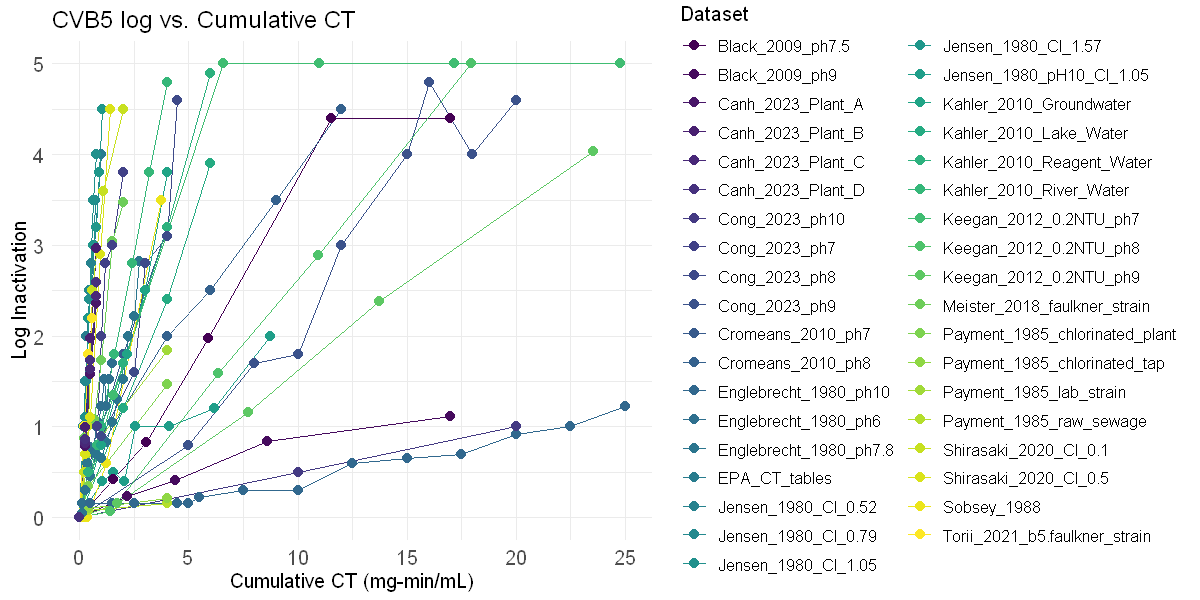

In [7]:
options(repr.plot.width = 10, repr.plot.height = 5)

ggplot(lit_2, aes(x =Dose , y = value, color=variable)) +
  geom_line() +
  geom_point(size=2.5,fill = 'gray') +
  labs(x = "Cumulative CT (mg-min/mL)", y = "Log Inactivation", title = "CVB5 log vs. Cumulative CT", color= 'Dataset',shape='Dataset',linetype='Dataset') +
  #scale_color_viridis_d() +
  xlim(0, 25) +  
  theme_minimal() +  
scale_color_viridis_d() +
#  scale_shape_manual(values = c(0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16, 17,18,19,20,21,22,23,24,25)) +  # Define different symbols for each level of the study variable
#  scale_linetype_manual(values = c("solid","solid","solid", "solid", "solid","solid","solid","solid","solid","solid","dotted","solid","solid","solid","solid","solid","solid","solid","solid","dashed","dashed","solid","solid","solid","solid","solid")) +  # Define line types for each level of the study variable
#  scale_color_manual(values = c("black","black","black", "black", "black","black","black","black","black","black","red","black","black","black","black","black","black","black","black","blue","green3","black","black","black","black","black")) +  # Define line types for each level of the study variable
  theme(
   axis.text = element_text(size = 12),
    text = element_text(size = 12)  # Adjust the size of text elements
  ) 

#gsave(paste0(fig_dir, 'cvb5_1.png'), width=10, height=5)


## Plotting Data

In [13]:
cl_lit <- read_excel('Virus.xlsx',sheet = 'Lit_Review')
cl_lit <- cl_lit %>% filter(Sample !='Torii_2020' & 
                            Sample !='This_Study_noNH3_2' & 
                            Sample !='This_Study_noNH3_3'& 
                            Sample !='Chaplin'&
                        #    Sample !='Bayesian'&
                        #    Sample !='RF'&
                       #     Sample !='GPR'&
                        #    Sample !='LMM'&
                            Paper != 'Kelly_1958')

In [14]:
# Choose papers to highlight
#highlight_papers <- c("This_Study_noNH3", "This_Study_NH3",'This_Study_noNH3_2')
highlight_papers <- c("This_Study_noNH3", "This_Study_NH3", 'EPA')
# Reorder factor levels: bring the highlighted papers to the top
cl_lit$Sample <- factor(cl_lit$Sample, levels = c(sort(setdiff(unique(cl_lit$Sample), highlight_papers), decreasing = TRUE),highlight_papers))
cl_lit$highlight_fill <- ifelse(cl_lit$Sample %in% c("This_Study_noNH3", "This_Study_NH3"), "yellow", 
                                ifelse(cl_lit$Sample == "EPA", "gray", "white"))


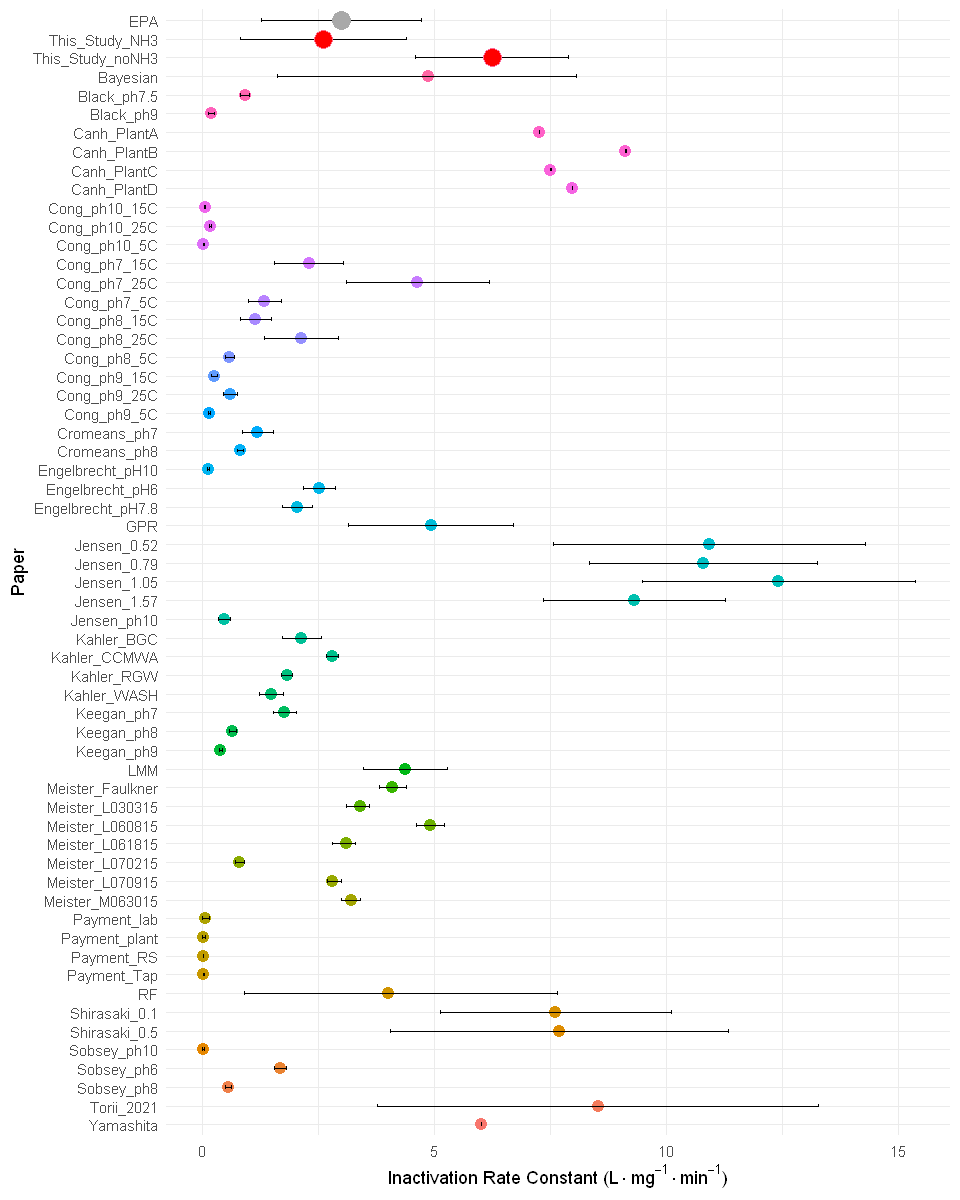

In [15]:
options(repr.plot.width = 8, repr.plot.height =10)
Figure_2<- ggplot(cl_lit , aes(x = Sample, y = Constant)) +
  geom_point(aes(color = Sample),size = 3) +  # Plot constants as points
  geom_errorbar(aes(ymin = Lower , ymax = Upper ), width = 0.2) +  # Add error bars
  geom_point(data = subset(cl_lit, Sample %in% c("This_Study_noNH3", "This_Study_NH3")), 
             aes(color = Sample), size = 5, shape = 21, fill = "red") +
  geom_point(data = subset(cl_lit, Sample %in% c("EPA")), 
              size = 5, shape = 21, color="darkgray", fill = "darkgray") +
  theme_minimal() +
  labs(y = expression("Inactivation Rate Constant ("*L %.% mg^{-1} %.% min^{-1}*")"), x = "Paper")+

  theme(legend.position = "none") +   # Optional: Remove legend if desired
  coord_flip()   # Flip the axes for a vertical orientation
Figure_2
ggsave(filename = file.path(fig_dir, "Figure_2.png"),
       plot = Figure_2, width = 8, height = 10, dpi = 300)

### Ordered by Temp

In [13]:
cl_lit <- read_excel('Virus.xlsx',sheet = 'Lit_Review')
cl_lit <- cl_lit %>% filter(Sample !='Torii_2020' & 
                            Sample !='This_Study_noNH3_2' & 
                            Sample !='This_Study_noNH3_3'& 
                            Sample !='Chaplin'&
                            Sample !='Bayesian'&
                            Sample !='RF'&
                            Sample !='GPR'&
                            Paper != 'Kelly_1958')

In [14]:
highlight_papers <- c("This_Study_noNH3", "This_Study_NH3",'EPA')
cl_lit$Sample <- factor(cl_lit$Sample, levels = c(sort(unique(cl_lit$Sample), decreasing = TRUE)))

cl_lit$Temperature <- factor(cl_lit$Temperature, levels = sort(unique(cl_lit$Temperature)))

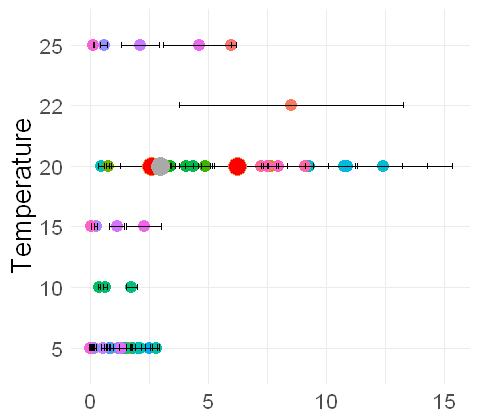

In [15]:
options(repr.plot.width = 4, repr.plot.height =3.5)
Figure_3a<- ggplot(cl_lit , aes(x = Temperature, y = Constant)) +
  geom_point(aes(color = Sample),size = 3) +  # Plot constants as points
  geom_errorbar(aes(ymin = Lower , ymax = Upper ), width = 0.1) +  # Add error bars
  geom_point(data = subset(cl_lit, Sample %in% c("This_Study_noNH3", "This_Study_NH3")), 
             aes(color = Sample), size = 5, shape = 21, fill = "red") +
  geom_point(data = subset(cl_lit, Sample %in% c("EPA")), 
              size = 5, shape = 21, color="darkgray", fill = "darkgray") +
  theme_minimal() +
  theme(axis.title.x = element_blank()) +

  #labs(y = "Inactivation Rate Constant", x = "Temperature") +
  labs( x = "Temperature")+
 
theme(legend.position = "none",text = element_text(size = 16)) +   # Optional: Remove legend if desired
  coord_flip()   # Flip the axes for a vertical orientation
Figure_3a

ggsave(filename = file.path(fig_dir, "Figure_3a.png"), plot = Figure_3a, width = 6, height = 6, dpi = 300)

### Ordered by pH

In [16]:
cl_lit <- read_excel('Virus.xlsx',sheet = 'Lit_Review')
cl_lit <- cl_lit %>% filter(Sample !='Torii_2020' & 
                            Sample !='This_Study_noNH3_2' & 
                            Sample !='This_Study_noNH3_3'& 
                            Sample !='Chaplin'&
                            Sample !='Bayesian'&
                            Sample !='RF'&
                            Sample !='GPR'&
                            Paper != 'Kelly_1958')

In [17]:
highlight_papers <- c("This_Study_noNH3", "This_Study_NH3",'EPA')
cl_lit$Sample <- factor(cl_lit$Sample, levels = c(sort(unique(cl_lit$Sample), decreasing = TRUE)))

cl_lit$pH <- factor(cl_lit$pH, levels = sort(unique(cl_lit$pH)))

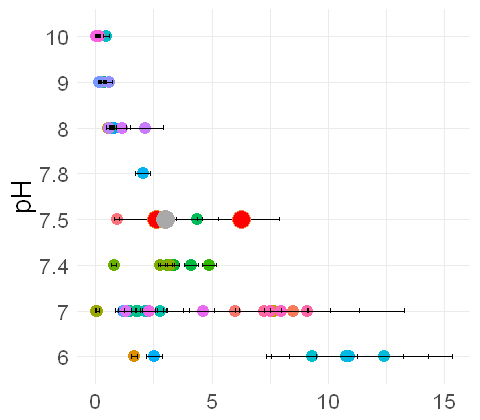

In [18]:
options(repr.plot.width = 4, repr.plot.height =3.5)
Figure_3b<- ggplot(cl_lit %>% filter(Sample !='Torii_2020' & Sample != 'EPA' & Sample !='This_Study_noNH3_2'), aes(x = pH, y = Constant)) +
  geom_point(aes(color = Sample),size = 3) +  # Plot constants as points
  geom_errorbar(aes(ymin = Lower , ymax = Upper ), width = 0.1) +  # Add error bars
  geom_point(data = subset(cl_lit, Sample %in% c("This_Study_noNH3", "This_Study_NH3")), 
             aes(color = Sample), size = 5, shape = 21, fill = "red") +
  geom_point(data = subset(cl_lit, Sample %in% c("EPA")), 
              size = 5, shape = 21, color="darkgray", fill = "darkgray") +
  theme_minimal() +
  theme(axis.title.x = element_blank()) +

  labs( x = "pH")+
  
#labs(y = "Inactivation Rate Constant", x = "pH") +
  theme(legend.position = "none",text = element_text(size = 16),) +   # Optional: Remove legend if desired
  coord_flip()   # Flip the axes for a vertical orientation
Figure_3b

ggsave(filename = file.path(fig_dir, "Figure_3b.png"), plot = Figure_3b, width = 6, height = 6, dpi = 300)

### Figure 3

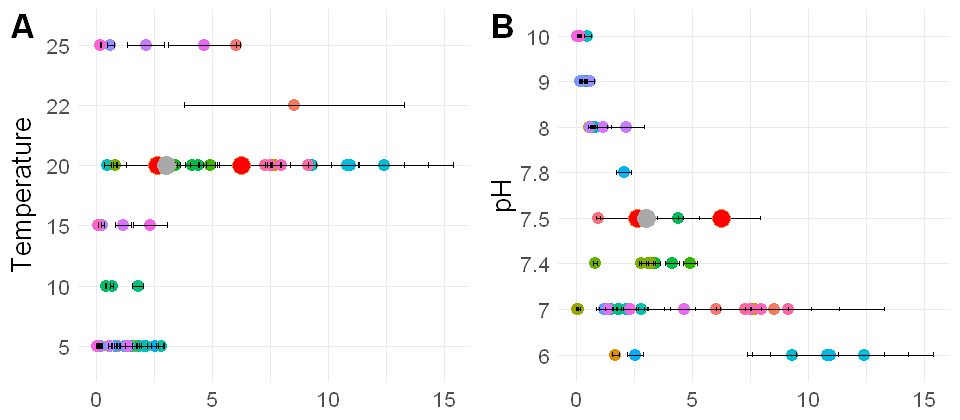

In [20]:
options(repr.plot.width = 8, repr.plot.height =3.5)
Figure_3 <- ggarrange(Figure_3a, Figure_3b, ncol = 2, nrow=1,labels=c('A','B'), 
                      font.label = list(size = 20, color = "black", face = "bold", family = NULL), 
                      align = c("hv"))
Figure_3
# Save the stacked plot


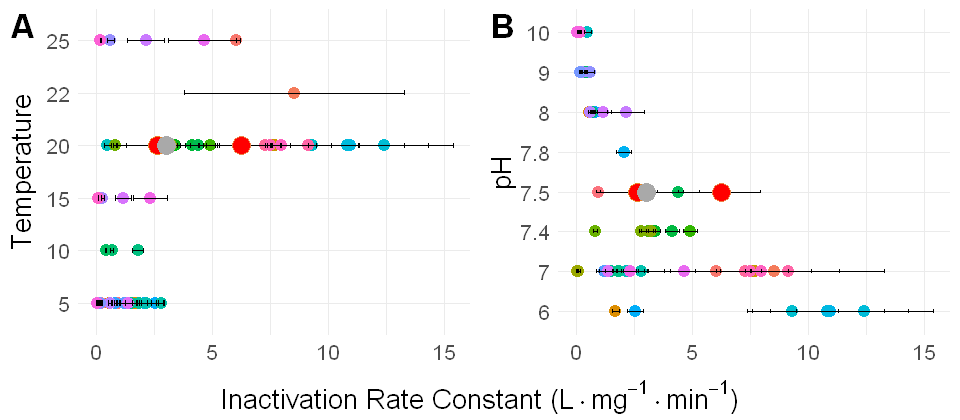

In [21]:
final_plot <- annotate_figure(
  Figure_3,
  bottom = text_grob(
    label = expression("Inactivation Rate Constant (" * L %.% mg^{-1} %.% min^{-1} * ")"),
    size = 16
  )
)

final_plot
ggsave(filename = file.path(fig_dir, "Figure_3.png"),
       plot = final_plot, width = 8, height = 3.5, dpi = 300)


### pH^2

In [43]:
cl_lit <- read_excel('Virus.xlsx',sheet = 'Lit_Review')


In [44]:
cl_lit <- cl_lit %>% mutate(pH_2 = as.numeric(pH)^2)

In [45]:
highlight_papers <- c("This_Study_noNH3", "This_Study_NH3")
cl_lit$Paper <- factor(cl_lit$Paper, levels = c(sort(unique(cl_lit$Paper), decreasing = TRUE)))

cl_lit$pH_2 <- factor(cl_lit$pH_2, levels = sort(unique(cl_lit$pH_2)))

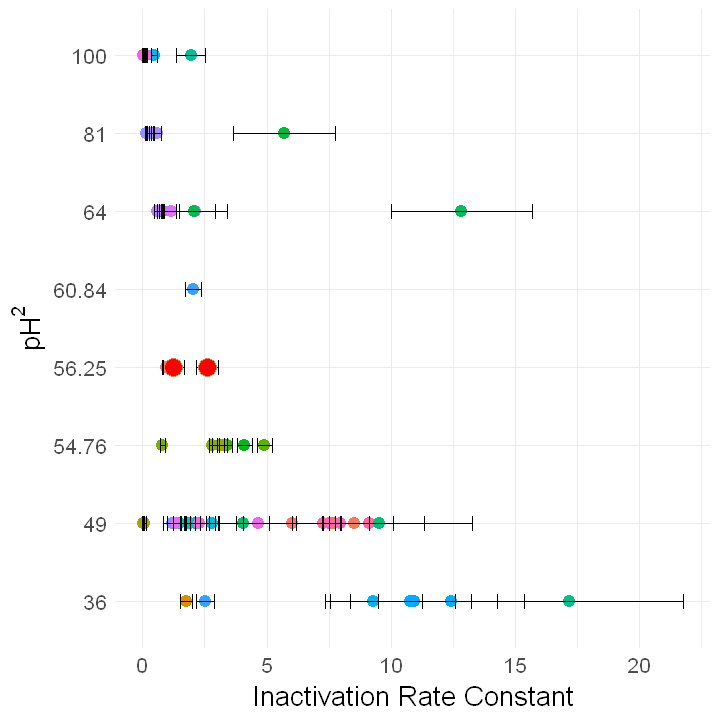

In [47]:
options(repr.plot.width = 6, repr.plot.height =6)
Figure_s2<- ggplot(cl_lit %>% filter(Paper !='Torii_2020' & Paper != 'EPA' & Paper !='This_Study_noNH3_2'), aes(x = pH_2, y = Constant)) +
  geom_point(aes(color = Paper),size = 3) +  # Plot constants as points
  geom_errorbar(aes(ymin = Lower , ymax = Upper ), width = 0.2) +  # Add error bars
  geom_point(data = subset(cl_lit, Paper %in% highlight_papers), aes(color = Paper), size = 5, shape = 21, fill = "red") +  # Highlighted pointsgeom_point(data = subset(cl_no, Paper == c('This_Study_noNH3')), aes(color = Paper), size = 5, shape = 21, fill = "red") +  # Highlighted points
  theme_minimal() +
  labs(y = "Inactivation Rate Constant", x = expression("pH"^2)) +
  theme(legend.position = "none",text = element_text(size = 16),) +   # Optional: Remove legend if desired
  coord_flip()   # Flip the axes for a vertical orientation
Figure_s2

#ggsave(filename = file.path(fig_dir, "Figure_2.png"), plot = Figure_2, width = 8, height = 10, dpi = 300)

### pH x Temp

In [48]:
cl_lit <- read_excel('Virus.xlsx',sheet = 'Lit_Review')


In [49]:
cl_lit <- cl_lit %>% mutate(pH_temp = as.numeric(pH)*as.numeric(Temperature))

In [50]:
highlight_papers <- c("This_Study_noNH3", "This_Study_NH3")
cl_lit$Paper <- factor(cl_lit$Paper, levels = c(sort(unique(cl_lit$Paper), decreasing = TRUE)))

cl_lit$pH_temp <- factor(cl_lit$pH_temp, levels = sort(unique(cl_lit$pH_temp)))

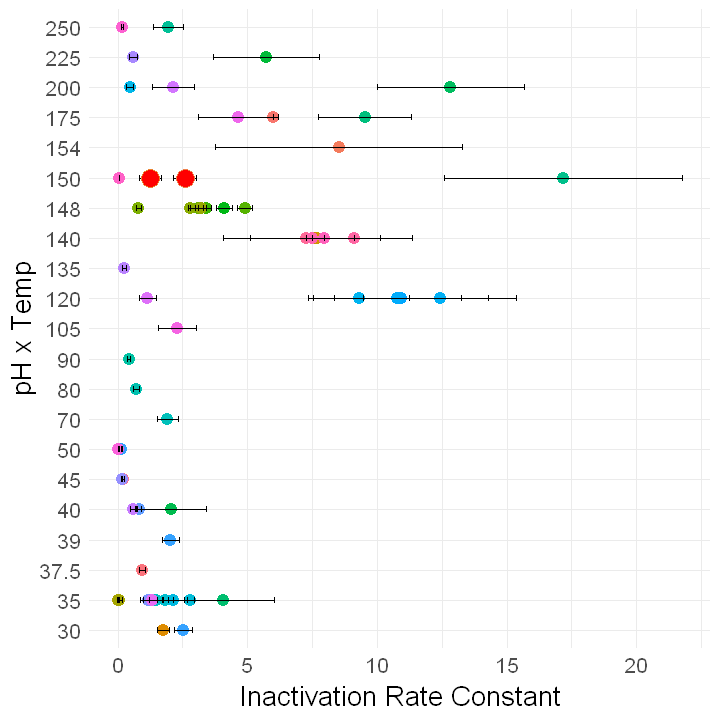

In [53]:
options(repr.plot.width = 6, repr.plot.height =6)
Figure_s2<- ggplot(cl_lit %>% filter(Paper !='Torii_2020' & Paper != 'EPA' & Paper !='This_Study_noNH3_2'), aes(x = pH_temp, y = Constant)) +
  geom_point(aes(color = Paper),size = 3) +  # Plot constants as points
  geom_errorbar(aes(ymin = Lower , ymax = Upper ), width = 0.2) +  # Add error bars
  geom_point(data = subset(cl_lit, Paper %in% highlight_papers), aes(color = Paper), size = 5, shape = 21, fill = "red") +  # Highlighted pointsgeom_point(data = subset(cl_no, Paper == c('This_Study_noNH3')), aes(color = Paper), size = 5, shape = 21, fill = "red") +  # Highlighted points
  theme_minimal() +
  labs(y = "Inactivation Rate Constant", x = "pH x Temp") +
  theme(legend.position = "none",text = element_text(size = 16),) +   # Optional: Remove legend if desired
  coord_flip()   # Flip the axes for a vertical orientation
Figure_s2

#ggsave(filename = file.path(fig_dir, "Figure_2.png"), plot = Figure_2, width = 8, height = 10, dpi = 300)

### Strain

In [205]:
cl_lit <- read_excel('Virus.xlsx',sheet = 'Lit_Review')
cl_lit <- cl_lit %>% filter(Sample !='Torii_2020' & 
                            Sample !='This_Study_noNH3_2' & 
                            Sample !='This_Study_noNH3_3'& 
                            Sample !='Chaplin'&
                            Sample !='Bayesian'&
                            Sample !='RF'&
                            Sample !='GPR'&
                            Paper != 'Kelly_1958')

In [206]:
highlight_papers <- c("This_Study_noNH3", "This_Study_NH3")
cl_lit$Paper <- factor(cl_lit$Paper, levels = c(sort(unique(cl_lit$Paper), decreasing = TRUE)))

cl_lit$Strain <- factor(cl_lit$Strain, levels = sort(unique(cl_lit$Strain)))

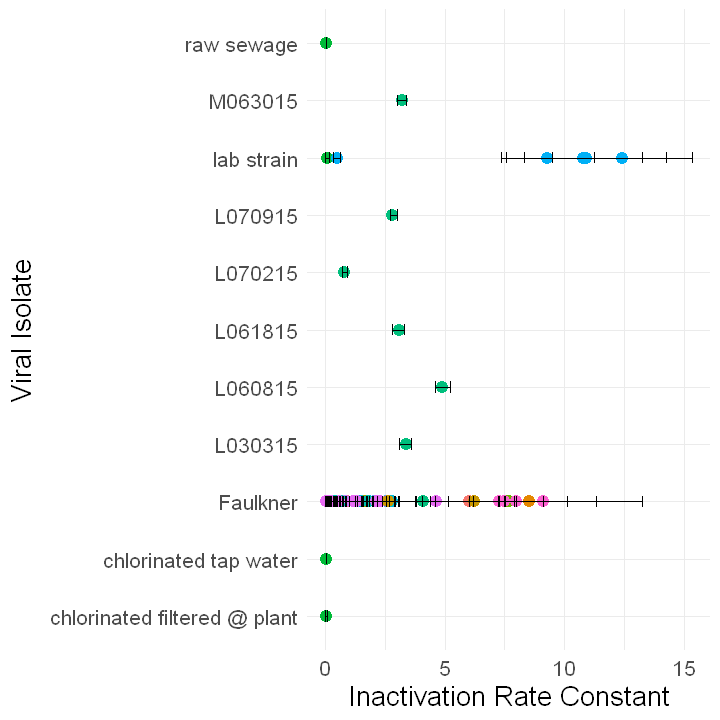

In [209]:
options(repr.plot.width = 6, repr.plot.height =6)
Figure_s8<- ggplot(cl_lit %>% filter(Paper !='Torii_2020' & Paper != 'EPA' & Paper !='This_Study_noNH3_2'), aes(x = Strain, y = Constant)) +
  geom_point(aes(color = Paper),size = 3) +  # Plot constants as points
  geom_errorbar(aes(ymin = Lower , ymax = Upper ), width = 0.2) +  # Add error bars
  geom_point(data = subset(cl_lit, Paper %in% highlight_papers), aes(color = Paper), size = 5, shape = 21, fill = "red") +  # Highlighted pointsgeom_point(data = subset(cl_no, Paper == c('This_Study_noNH3')), aes(color = Paper), size = 5, shape = 21, fill = "red") +  # Highlighted points
  theme_minimal() +
  labs(y = "Inactivation Rate Constant", x = "Viral Isolate") +
  theme(legend.position = "none",text = element_text(size = 16),) +   # Optional: Remove legend if desired
  coord_flip()   # Flip the axes for a vertical orientation
Figure_s8

ggsave(filename = file.path(fig_dir, "Figure_s8.png"), plot = Figure_s8, width = 6, height = 6, dpi = 300)

### Permutation Tests

In [6]:
cl_lit <- read_excel('Virus.xlsx',sheet = 'Lit_Review')


In [235]:
#Pairwise
# Function to calculate standard deviation from CI and sample size
calculate_sd <- function(upper_ci, lower_ci, n) {
  t_value <- qt(0.975, df = n - 1)  # t-value for 95% CI
  sd <- (upper_ci - lower_ci) * sqrt(n) / (2 * t_value)
  return(sd)
}

# Function to perform permutation test
permutation_test <- function(data_A, data_B, observed_diff, num_permutations = 10000) {
  pooled_data <- c(data_A, data_B)
  n_A <- length(data_A)
  n_B <- length(data_B)
  
  perm_diffs <- numeric(num_permutations)
  for (i in 1:num_permutations) {
    shuffled_data <- sample(pooled_data)
    perm_A <- shuffled_data[1:n_A]
    perm_B <- shuffled_data[(n_A + 1):(n_A + n_B)]
    perm_diffs[i] <- mean(perm_A) - mean(perm_B)  # Difference in means of the permuted samples
  }
  
  # Compare the observed difference to the permuted differences
  p_value <- mean(abs(perm_diffs) >= abs(observed_diff))  # Two-tailed p-value
  return(p_value)
}

# Add standard deviation to the dataframe
cl_lit <- cl_lit %>%
  mutate(SD = calculate_sd(Upper, Lower, n))

# Specify the two papers to compare
#paper1 <- "Chaplin"  # Replace with the name of Paper 1
#paper1 <- "Bayesian"
#paper1 <- "RF"
#paper1 <- "GPR"
paper1 <- "This_Study_noNH3"  # Replace with the name of Paper 2
#paper2 <- "Keegan_ph7"
paper2 <- "Keegan_ph8"
#paper2 <- "This_Study_NH3"

# Extract data for the two papers
data1 <- cl_lit %>% filter(Sample == paper1)
data2 <- cl_lit %>% filter(Sample == paper2)

# Simulate raw data
simulated_data1 <- rnorm(data1$n, mean = data1$Constant, sd = data1$SD)
simulated_data2 <- rnorm(data2$n, mean = data2$Constant, sd = data2$SD)

# Calculate the observed difference in constants
observed_diff <- data1$Constant - data2$Constant

# Perform permutation test
set.seed(123)  # For reproducibility
p_value <- permutation_test(simulated_data1, simulated_data2, observed_diff)

# Print the result
cat("Permutation test p-value for", paper1, "vs.", paper2, ":", p_value, "\n")

Permutation test p-value for This_Study_noNH3 vs. Keegan_ph8 : 5e-04 


In [236]:
# Define the list of papers to compare
papers <- c("Keegan_ph7", "Keegan_ph8", "Keegan_ph9", "This_Study_noNH3", "This_Study_noNH3_2", "This_Study_noNH3_3", "This_Study_NH3")

# Function to calculate standard deviation from CI and sample size
calculate_sd <- function(upper_ci, lower_ci, n) {
  t_value <- qt(0.975, df = n - 1)  # t-value for 95% CI
  sd <- (upper_ci - lower_ci) * sqrt(n) / (2 * t_value)
  return(sd)
}

# Function to perform permutation test
permutation_test <- function(data_A, data_B, observed_diff, num_permutations = 10000) {
  pooled_data <- c(data_A, data_B)
  n_A <- length(data_A)
  n_B <- length(data_B)
  
  perm_diffs <- numeric(num_permutations)
  for (i in 1:num_permutations) {
    shuffled_data <- sample(pooled_data)
    perm_A <- shuffled_data[1:n_A]
    perm_B <- shuffled_data[(n_A + 1):(n_A + n_B)]
    perm_diffs[i] <- mean(perm_A) - mean(perm_B)  # Difference in means of the permuted samples
  }
  
  # Compare the observed difference to the permuted differences
  p_value <- mean(abs(perm_diffs) >= abs(observed_diff))  # Two-tailed p-value
  return(p_value)
}

# Add standard deviation to the dataframe
cl_lit <- cl_lit %>%
  mutate(SD = calculate_sd(Upper, Lower, n))

# Define the list of papers
#papers <- c("Chaplin", "Bayesian", "RF", "GPR", "This_Study_noNH3", "This_Study_noNH3_2", "This_Study_noNH3_3", "This_Study_NH3")

# Initialize a dataframe to store the results
results <- data.frame(Paper1 = character(), Paper2 = character(), PValue = numeric(), stringsAsFactors = FALSE)

# Loop over all combinations of papers
for (i in 1:(length(papers) - 1)) {
  for (j in (i + 1):length(papers)) {
    paper1 <- papers[i]
    paper2 <- papers[j]
    
    # Extract data for the two papers
    data1 <- cl_lit %>% filter(Sample == paper1)
    data2 <- cl_lit %>% filter(Sample == paper2)
    
    # Simulate raw data
    simulated_data1 <- rnorm(data1$n, mean = data1$Constant, sd = data1$SD)
    simulated_data2 <- rnorm(data2$n, mean = data2$Constant, sd = data2$SD)
    
    # Calculate the observed difference in constants
    observed_diff <- mean(data1$Constant) - mean(data2$Constant)
    
    # Perform permutation test
    set.seed(123)  # For reproducibility
    p_value <- permutation_test(simulated_data1, simulated_data2, observed_diff)
    
    # Store the results in the dataframe
    results <- rbind(results, data.frame(Paper1 = paper1, Paper2 = paper2, PValue = p_value))
  }
}

# Print the results
print(results)


               Paper1             Paper2 PValue
1          Keegan_ph7         Keegan_ph8 0.0000
2          Keegan_ph7         Keegan_ph9 0.0000
3          Keegan_ph7   This_Study_noNH3 0.0000
4          Keegan_ph7 This_Study_noNH3_2 0.2920
5          Keegan_ph7 This_Study_noNH3_3 0.1913
6          Keegan_ph7     This_Study_NH3 0.4938
7          Keegan_ph8         Keegan_ph9 0.0000
8          Keegan_ph8   This_Study_noNH3 0.0000
9          Keegan_ph8 This_Study_noNH3_2 0.0756
10         Keegan_ph8 This_Study_noNH3_3 0.0029
11         Keegan_ph8     This_Study_NH3 0.1207
12         Keegan_ph9   This_Study_noNH3 0.0000
13         Keegan_ph9 This_Study_noNH3_2 0.0009
14         Keegan_ph9 This_Study_noNH3_3 0.0008
15         Keegan_ph9     This_Study_NH3 0.0832
16   This_Study_noNH3 This_Study_noNH3_2 0.0000
17   This_Study_noNH3 This_Study_noNH3_3 0.0000
18   This_Study_noNH3     This_Study_NH3 0.0008
19 This_Study_noNH3_2 This_Study_noNH3_3 0.0563
20 This_Study_noNH3_2     This_Study_NH3

Our study with ammonia not differnt from keegan ph=7 or 8

Study w/o ammonia (linear part only) is different from both ph=7 & 8

In [230]:
paper1
cl_lit %>% filter(Sample == paper1)

[1] "This_Study_noNH3"

Sample,Paper,Constant,Lower,Upper,Log Type,Linear Regression?,CT_Method,Temperature,Water Type,Chloride,pH,Strain,n,SD
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>
This_Study_noNH3,This_study,6.243637,4.596616,7.890659,Base10,Y,3,20,MBR,6,7.5,Faulkner,5,1.326463


In [7]:
# Define the list of papers to compare
papers <- c("Chaplin", "LMM","Bayesian", "RF", "GPR", "This_Study_noNH3", "This_Study_noNH3_2", "This_Study_noNH3_3", "This_Study_NH3")

# Function to calculate standard deviation from CI and sample size
calculate_sd <- function(upper_ci, lower_ci, n) {
  t_value <- qt(0.975, df = n - 1)  # t-value for 95% CI
  sd <- (upper_ci - lower_ci) * sqrt(n) / (2 * t_value)
  return(sd)
}

# Function to perform permutation test
permutation_test <- function(data_A, data_B, observed_diff, num_permutations = 10000) {
  pooled_data <- c(data_A, data_B)
  n_A <- length(data_A)
  n_B <- length(data_B)
  
  perm_diffs <- numeric(num_permutations)
  for (i in 1:num_permutations) {
    shuffled_data <- sample(pooled_data)
    perm_A <- shuffled_data[1:n_A]
    perm_B <- shuffled_data[(n_A + 1):(n_A + n_B)]
    perm_diffs[i] <- mean(perm_A) - mean(perm_B)  # Difference in means of the permuted samples
  }
  
  # Compare the observed difference to the permuted differences
  p_value <- mean(abs(perm_diffs) >= abs(observed_diff))  # Two-tailed p-value
  return(p_value)
}

# Add standard deviation to the dataframe
cl_lit <- cl_lit %>%
  mutate(SD = calculate_sd(Upper, Lower, n))

# Initialize a dataframe to store the results
results <- data.frame(Paper1 = character(), Paper2 = character(), PValue = numeric(), stringsAsFactors = FALSE)

# Loop over all combinations of papers
for (i in 1:(length(papers) - 1)) {
  for (j in (i + 1):length(papers)) {
    paper1 <- papers[i]
    paper2 <- papers[j]
    
    # Extract data for the two papers
    data1 <- cl_lit %>% filter(Sample == paper1)
    data2 <- cl_lit %>% filter(Sample == paper2)
    
    # Simulate raw data
    simulated_data1 <- rnorm(data1$n, mean = data1$Constant, sd = data1$SD)
    simulated_data2 <- rnorm(data2$n, mean = data2$Constant, sd = data2$SD)
    
    # Calculate the observed difference in constants
    observed_diff <- mean(data1$Constant) - mean(data2$Constant)
    
    # Perform permutation test
    set.seed(123)  # For reproducibility
    p_value <- permutation_test(simulated_data1, simulated_data2, observed_diff)
    
    # Store the results in the dataframe
    results <- rbind(results, data.frame(Paper1 = paper1, Paper2 = paper2, PValue = p_value))
  }
}

# Print the results
print(results)


               Paper1             Paper2 PValue
1             Chaplin                LMM 0.0000
2             Chaplin           Bayesian 0.0249
3             Chaplin                 RF 0.1076
4             Chaplin                GPR 0.0000
5             Chaplin   This_Study_noNH3 0.0000
6             Chaplin This_Study_noNH3_2 0.9388
7             Chaplin This_Study_noNH3_3 0.1260
8             Chaplin     This_Study_NH3 0.0977
9                 LMM           Bayesian 0.7493
10                LMM                 RF 0.8337
11                LMM                GPR 0.5831
12                LMM   This_Study_noNH3 0.1328
13                LMM This_Study_noNH3_2 0.0004
14                LMM This_Study_noNH3_3 0.0836
15                LMM     This_Study_NH3 0.0972
16           Bayesian                 RF 0.7014
17           Bayesian                GPR 0.9735
18           Bayesian   This_Study_noNH3 0.7524
19           Bayesian This_Study_noNH3_2 0.2452
20           Bayesian This_Study_noNH3_3

In [238]:
# Specify a reference paper
# Function to calculate standard deviation from CI and sample size
calculate_sd <- function(upper_ci, lower_ci, n) {
  t_value <- qt(0.975, df = n - 1)  # t-value for 95% CI
  sd <- (upper_ci - lower_ci) * sqrt(n) / (2 * t_value)
  return(sd)
}

# Function to perform permutation test
permutation_test <- function(data_A, data_B, observed_diff, num_permutations = 10000) {
  pooled_data <- c(data_A, data_B)
  n_A <- length(data_A)
  n_B <- length(data_B)
  
  perm_diffs <- replicate(num_permutations, {
    shuffled <- sample(pooled_data)
    mean(shuffled[1:n_A]) - mean(shuffled[(n_A + 1):(n_A + n_B)])
  })
  
  mean(abs(perm_diffs) >= abs(observed_diff))  # Two-tailed p-value
}

# Calculate standard deviations
cl_lit <- cl_lit %>%
  mutate(SD = calculate_sd(Upper, Lower, n))

# Define all papers and specify the reference paper
all_papers <- unique(cl_lit$Sample)
reference_paper <- "Payment_lab"
comparison_papers <- setdiff(all_papers, reference_paper)

# Initialize results dataframe
results <- data.frame(Paper1 = character(), Paper2 = character(), PValue = numeric(), stringsAsFactors = FALSE)

# Loop through each comparison
for (paper2 in comparison_papers) {
  data1 <- cl_lit %>% filter(Sample == reference_paper)
  data2 <- cl_lit %>% filter(Sample == paper2)
  
  # Simulate data using n, mean, and SD
  simulated_data1 <- rnorm(data1$n, mean = data1$Constant, sd = data1$SD)
  simulated_data2 <- rnorm(data2$n, mean = data2$Constant, sd = data2$SD)
  
  observed_diff <- mean(data1$Constant) - mean(data2$Constant)
  
  set.seed(123)
  p_value <- permutation_test(simulated_data1, simulated_data2, observed_diff)
  
  # Store results
  results <- rbind(results, data.frame(Paper1 = reference_paper, Paper2 = paper2, PValue = p_value))
}

# Print results
print(results)


        Paper1             Paper2 PValue
1  Payment_lab         Sobsey_ph8 0.0021
2  Payment_lab         Sobsey_ph6 0.0000
3  Payment_lab        Sobsey_ph10 0.2547
4  Payment_lab                EPA 0.0000
5  Payment_lab         Payment_RS 0.0000
6  Payment_lab        Payment_Tap 0.3669
7  Payment_lab      Payment_plant 0.3214
8  Payment_lab  Engelbrecht_pH7.8 0.0000
9  Payment_lab    Engelbrecht_pH6 0.0003
10 Payment_lab   Engelbrecht_pH10 0.0022
11 Payment_lab        Jensen_0.52 0.0000
12 Payment_lab        Jensen_0.79 0.0021
13 Payment_lab        Jensen_1.05 0.0000
14 Payment_lab        Jensen_1.57 0.0021
15 Payment_lab        Jensen_ph10 0.0024
16 Payment_lab        Black_ph7.5 0.0067
17 Payment_lab          Black_ph9 0.0185
18 Payment_lab       Cromeans_ph7 0.0014
19 Payment_lab       Cromeans_ph8 0.0005
20 Payment_lab   Meister_Faulkner 0.0021
21 Payment_lab    Meister_L030315 0.0006
22 Payment_lab    Meister_L060815 0.0014
23 Payment_lab    Meister_L061815 0.0006
24 Payment_lab  

In [224]:
results[results$PValue > 0.05 , ]

,Paper1,Paper2,PValue
,<chr>,<chr>,<dbl>
3,Payment_lab,Sobsey_ph10,0.2547
6,Payment_lab,Payment_Tap,0.3669
7,Payment_lab,Payment_plant,0.3214
41,Payment_lab,Cong_ph10_25C,0.0798
45,Payment_lab,Cong_ph10_15C,0.3978
57,Payment_lab,Kelly_ph7_25C,0.4884
58,Payment_lab,Kelly_ph8_25C,0.5355
60,Payment_lab,Kelly_ph9_25C,0.2722
66,Payment_lab,Chaplin,0.1041


In [9]:
results%>%filter(PValue <0.05)

Paper1,Paper2,PValue
<chr>,<chr>,<dbl>
Chaplin,LMM,0.0000
Chaplin,Bayesian,0.0249
Chaplin,GPR,0.0000
Chaplin,This_Study_noNH3,0.0000
LMM,This_Study_noNH3_2,0.0004
GPR,This_Study_noNH3_2,0.0336
This_Study_noNH3,This_Study_noNH3_2,0.0000
This_Study_noNH3,This_Study_noNH3_3,0.0000
This_Study_noNH3,This_Study_NH3,0.0008


In [10]:
results%>%filter(Paper1 =='This_Study_noNH3' | Paper2 =='This_Study_noNH3')

Paper1,Paper2,PValue
<chr>,<chr>,<dbl>
Chaplin,This_Study_noNH3,0.0000
LMM,This_Study_noNH3,0.1328
Bayesian,This_Study_noNH3,0.7524
RF,This_Study_noNH3,0.6227
GPR,This_Study_noNH3,0.5581
This_Study_noNH3,This_Study_noNH3_2,0.0000
This_Study_noNH3,This_Study_noNH3_3,0.0000
This_Study_noNH3,This_Study_NH3,0.0008


# CTs to get 4-6 log

In [11]:
cl_lit <- read_excel('Virus.xlsx',sheet = 'Lit_Review')
cl_lit <- cl_lit %>% filter(Sample !='Torii_2020' & 
                            Sample !='This_Study_noNH3_2' & 
                            Sample !='This_Study_noNH3_3'& 
                            Sample !='Chaplin'&
                            Sample !='Bayesian'&
                            Sample !='RF'&
                            Sample !='GPR'&
                            Paper != 'Kelly_1958' &
                            Paper != 'EPA' )

In [12]:
cl_lit <- cl_lit %>% mutate(CT_4log = -log(10^-4)/as.numeric(Constant)) 
#cl_lit

In [13]:
cl_lit_2 <- cl_lit %>%
  mutate(
    Above_EPA = case_when(
      Temperature == 5 & pH >= 6 & pH <= 9 & CT_4log > 8 ~ TRUE,
      Temperature == 10 & pH >= 6 & pH <= 9 & CT_4log > 6 ~ TRUE,
      Temperature == 15 & pH >= 6 & pH <= 9 & CT_4log > 4 ~ TRUE,
      Temperature == 20 & pH >= 6 & pH <= 9 & CT_4log > 3 ~ TRUE,
      Temperature == 25 & pH >= 6 & pH <= 9 & CT_4log > 2 ~ TRUE,
      Temperature == 5 & pH == 10 & CT_4log > 60 ~ TRUE,
      Temperature == 10 & pH == 10 & CT_4log > 45 ~ TRUE,
      Temperature == 15 & pH == 10 & CT_4log > 30 ~ TRUE,
      Temperature == 20 & pH == 10 & CT_4log > 22 ~ TRUE,
      Temperature == 25 & pH == 10 & CT_4log > 15 ~ TRUE,
      TRUE ~ FALSE
    )
  )

cl_lit_2 <- cl_lit_2 %>%
  mutate(
    Above_WaterVal = case_when(
      Temperature == 5 & pH <= 7  & CT_4log > 8 ~ TRUE,
      Temperature == 10 & pH <= 7  & CT_4log > 6 ~ TRUE,
      Temperature == 15 & pH <= 7  & CT_4log > 4 ~ TRUE,
      Temperature == 20 & pH <= 7  & CT_4log > 3 ~ TRUE,
      Temperature == 25 & pH <= 7  & CT_4log > 2 ~ TRUE,
      Temperature == 5 & pH <= 7.5 & pH > 7 & CT_4log > 16 ~ TRUE,
      Temperature == 10 & pH <= 7.5 & pH > 7 & CT_4log > 11 ~ TRUE,
      Temperature == 15 & pH <= 7.5 & pH > 7 & CT_4log > 8 ~ TRUE,
      Temperature == 20 & pH <= 7.5 & pH > 7 & CT_4log > 6 ~ TRUE,
      Temperature == 25 & pH <= 7.5  & pH > 7 & CT_4log > 4 ~ TRUE,   
      Temperature == 5 & pH <= 8 & pH > 7.5 & CT_4log > 23 ~ TRUE,
      Temperature == 10 & pH <= 8 & pH > 7.5 & CT_4log > 16 ~ TRUE,
      Temperature == 15 & pH <= 8 & pH > 7.5 & CT_4log > 12 ~ TRUE,
      Temperature == 20 & pH <= 8 & pH > 7.5 & CT_4log > 8 ~ TRUE,
      Temperature == 25 & pH <= 8 & pH > 7.5 & CT_4log > 6 ~ TRUE,   
      Temperature == 5 & pH <= 8.5 & pH > 8 & CT_4log > 29 ~ TRUE,
      Temperature == 10 & pH <= 8.5 & pH > 8 & CT_4log > 21 ~ TRUE,
      Temperature == 15 & pH <= 8.5 & pH > 8 & CT_4log > 15 ~ TRUE,
      Temperature == 20 & pH <= 8.5 & pH > 8 & CT_4log > 10 ~ TRUE,
      Temperature == 25 & pH <= 8.5 & pH > 8 & CT_4log > 8 ~ TRUE,   
      Temperature == 5 & pH <= 9 & pH > 8.5 & CT_4log > 35 ~ TRUE,
      Temperature == 10 & pH <= 9 & pH > 8.5 & CT_4log > 25 ~ TRUE,
      Temperature == 15 & pH <= 9 & pH > 8.5 & CT_4log > 17 ~ TRUE,
      Temperature == 20 & pH <= 9 & pH > 8.5 & CT_4log > 12 ~ TRUE,
      Temperature == 25 & pH <= 9 & pH > 8.5 & CT_4log > 9 ~ TRUE,   
        TRUE ~ FALSE
    )
  )

In [14]:
range(cl_lit$Constant)

[1]  0.02112463 12.41284989

In [15]:
write.csv(cl_lit_2 , file = "virus_new.csv", row.names = FALSE)

In [16]:
# Count rows where 'Condition' is TRUE
count_true <- sum(cl_lit_2$Above_EPA)

print(count_true)
count_true <- sum(cl_lit_2$Above_WaterVal)

print(count_true)


[1] 25
[1] 10


# Lognormal and Gamma Fits

In [17]:
cl_lit <- read_excel('Virus.xlsx',sheet = 'Lit_Review')
cl_fit <- cl_lit %>% filter(Sample !='Torii_2020' & 
                            Sample !='This_Study_noNH3_2' & 
                            Sample !='This_Study_noNH3_3'& 
                            Sample !='Chaplin'&
                            Sample !='Bayesian'&
                            Sample !='RF'&
                            Sample !='GPR'&
                            Paper != 'Kelly_1958' &
                            Paper != 'EPA')

Fitting of the distribution ' lnorm ' by maximum likelihood 
Parameters : 
         estimate Std. Error
meanlog 0.1768978  0.2393870
sdlog   1.7914084  0.1692719
Loglikelihood:  -122.015   AIC:  248.0299   BIC:  252.0806 
Correlation matrix:
             meanlog        sdlog
meanlog 1.000000e+00 1.259661e-10
sdlog   1.259661e-10 1.000000e+00


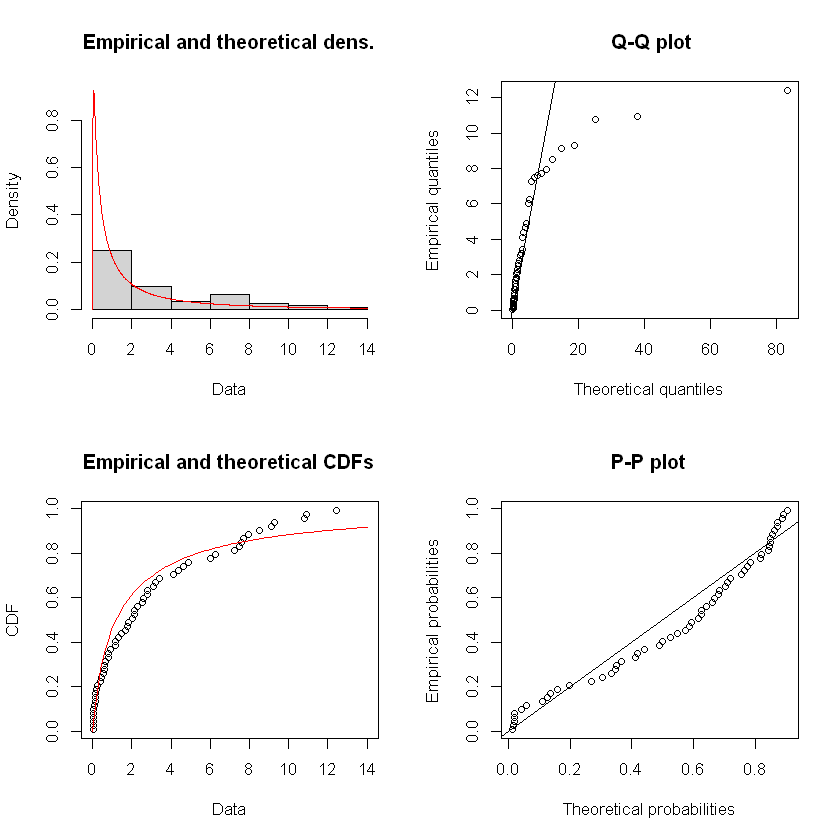

In [18]:
par(bg = "white")  # Set background to white

# Fit lognormal distribution
fit_lnorm <- fitdist(cl_fit$Constant, "lnorm")

# Print summary of the fit
summary(fit_lnorm)

# Plot diagnostic graphs
plot(fit_lnorm)

Fitting of the distribution ' gamma ' by maximum likelihood 
Parameters : 
       estimate Std. Error
shape 0.6339071 0.10112199
rate  0.2020122 0.04677518
Loglikelihood:  -115.3932   AIC:  234.7863   BIC:  238.837 
Correlation matrix:
          shape      rate
shape 1.0000000 0.6889129
rate  0.6889129 1.0000000


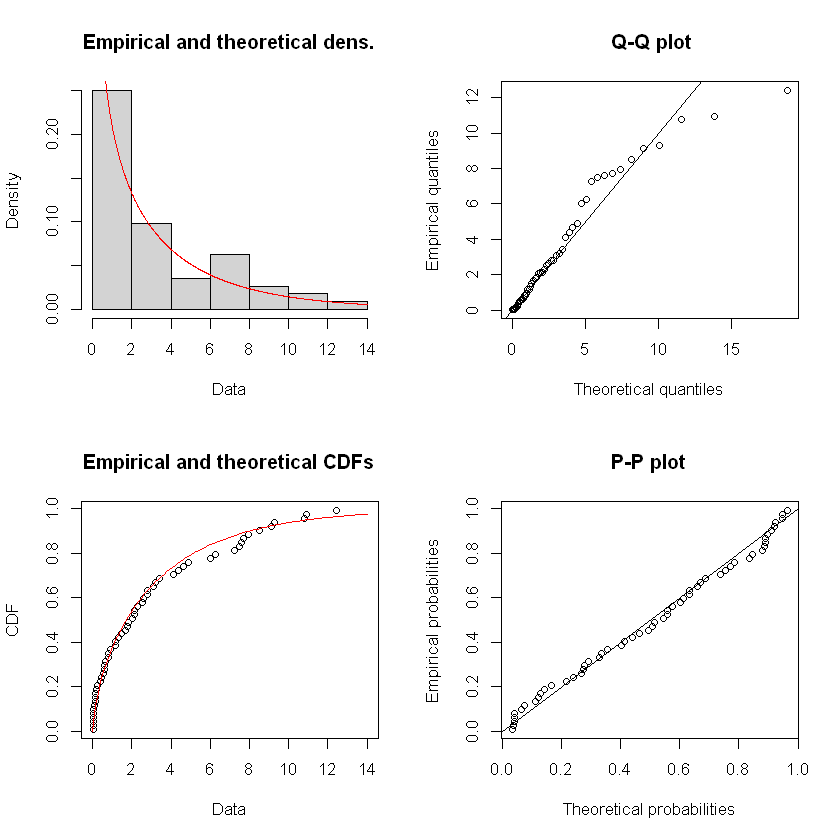

In [19]:
par(bg = "white")  # Set background to white

# Fit Gamma distribution
fit_gamma <- fitdist(cl_fit$Constant, "gamma", method='mle')

# Print summary of the fit
summary(fit_gamma)

# Plot diagnostic graphs
plot(fit_gamma)

In [28]:
fit_gamma$estimate
1/fit_gamma$estimate["rate"] # if you need scale

shape      rate 
0.6339071 0.2020122

rate 
4.950196

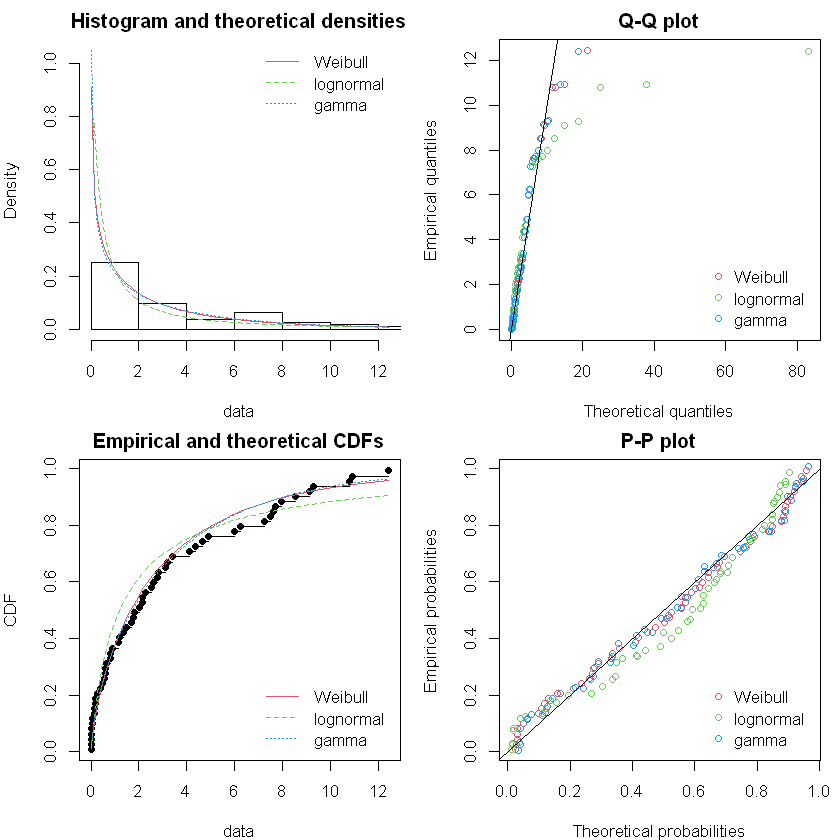

In [21]:
par(mfrow = c(2, 2), mar = c(4, 4, 2, 1), bg='white')
fg <- fitdist(cl_fit$Constant, "gamma")
fln <- fitdist(cl_fit$Constant, "lnorm")
fw <- fitdist(cl_fit$Constant, "weibull")
plot.legend <- c("Weibull", "lognormal", "gamma")
denscomp(list(fw, fln, fg), legendtext = plot.legend)
qqcomp(list(fw, fln, fg), legendtext = plot.legend)
cdfcomp(list(fw, fln, fg), legendtext = plot.legend)
ppcomp(list(fw, fln, fg), legendtext = plot.legend)

In [22]:
summary(fw)

Fitting of the distribution ' weibull ' by maximum likelihood 
Parameters : 
       estimate Std. Error
shape 0.7504823 0.08237746
scale 2.6916997 0.50320199
Loglikelihood:  -116.1666   AIC:  236.3333   BIC:  240.384 
Correlation matrix:
          shape     scale
shape 1.0000000 0.3050559
scale 0.3050559 1.0000000


## Normality

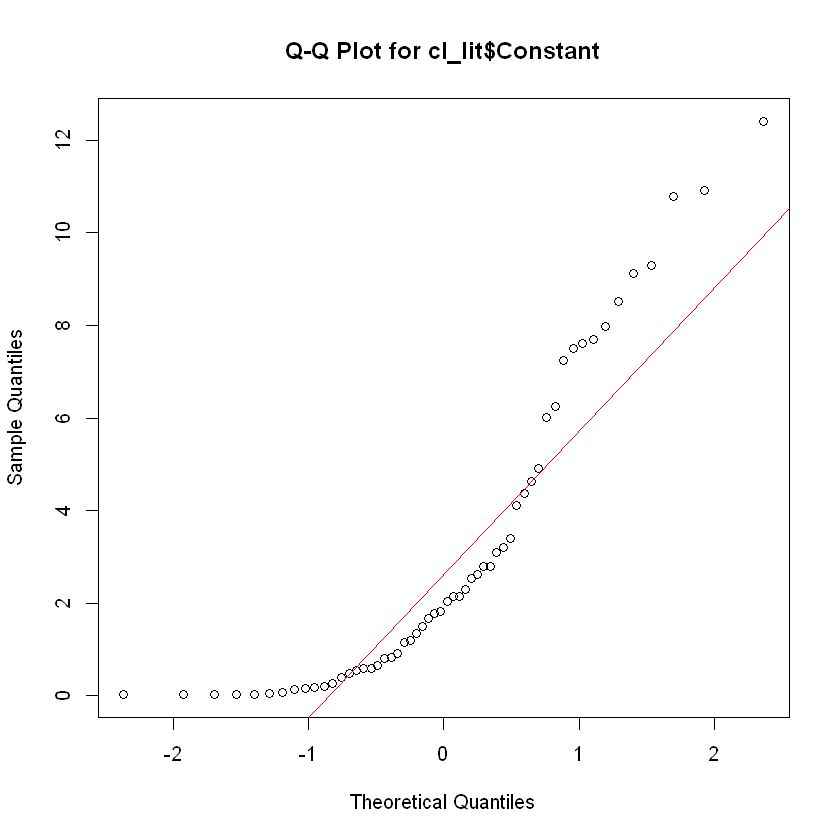

In [26]:
par(bg = "white")  # Set background to white

qqnorm(cl_fit$Constant, main = "Q-Q Plot for cl_lit$Constant")
qqline(cl_fit$Constant, col = "red")  # Add reference line

## Temp/pH tests

In [30]:
cl_fit$pH_group <- cut(cl_fit$pH, breaks = c(-Inf, 7, 8, Inf), labels = c("Low", "Medium","High"))
fligner.test(Constant ~ pH_group, data = cl_fit)


	Fligner-Killeen test of homogeneity of variances

data:  Constant by pH_group
Fligner-Killeen:med chi-squared = 22.323, df = 2, p-value = 1.421e-05


In [31]:
cl_fit$temp_group <- cut(cl_fit$Temperature, breaks = c(-Inf,5, 10,15,20,22, Inf), labels = c("Low", "low-med","Medium", "Med-High","high","Higher"))
fligner.test(Constant ~ Temperature, data = cl_fit)


	Fligner-Killeen test of homogeneity of variances

data:  Constant by Temperature
Fligner-Killeen:med chi-squared = 26.299, df = 5, p-value = 7.809e-05


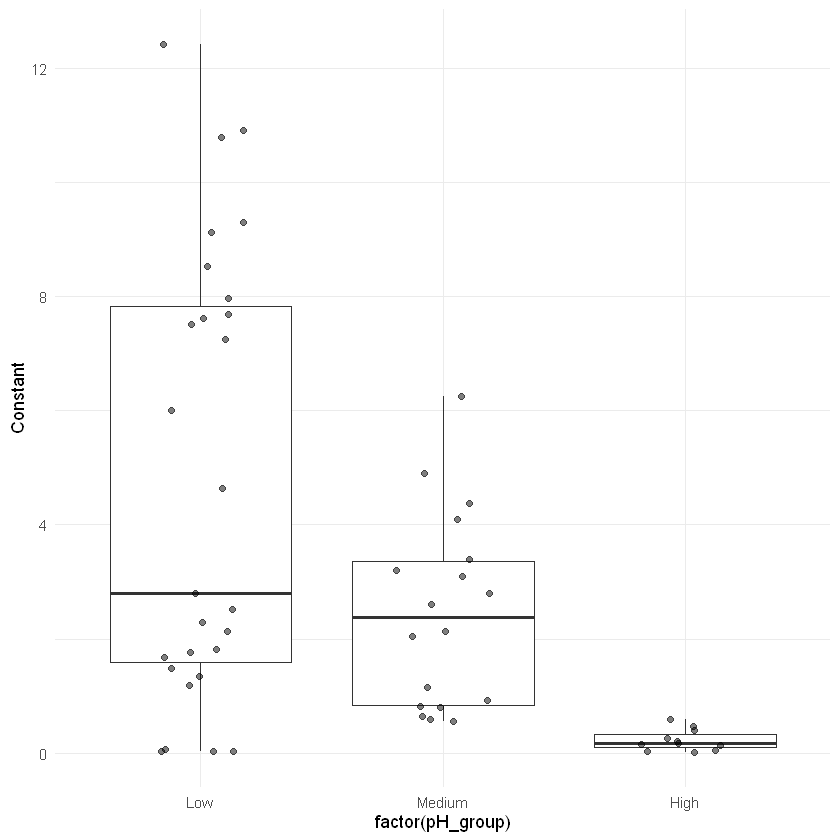

In [32]:

ggplot(cl_fit, aes(x = factor(pH_group), y = Constant)) +
  geom_boxplot() +
  geom_jitter(width = 0.2, alpha = 0.5) +
  theme_minimal()


In [33]:
kruskal_test <- kruskal.test(Constant ~ Temperature, data = cl_fit)

H <- as.numeric(kruskal_test$statistic)  # Kruskal-Wallis H statistic
n <- sum(!is.na(cl_fit$Constant))  # Total sample size
k <- length(unique(cl_fit$Temperature))  # Number of groups

eta_squared <- (H - (k - 1)) / (n - 1)
print(eta_squared)


kruskal_test <- kruskal.test(Constant ~ pH, data = cl_fit)

H <- as.numeric(kruskal_test$statistic)  # Kruskal-Wallis H statistic
n <- sum(!is.na(cl_fit$Constant))  # Total sample size
k <- length(unique(cl_fit$pH))  # Number of groups

eta_squared <- (H - (k - 1)) / (n - 1)
print(eta_squared)

[1] 0.4748905
[1] 0.3575694


In [34]:
kruskal_test <- kruskal.test(Constant ~ Temperature, data = cl_fit)
kruskal_test$p.value
kruskal_test <- kruskal.test(Constant ~ pH, data = cl_fit)
kruskal_test$p.value


[1] 8.873938e-06

[1] 0.0003826442

In [37]:
library(lawstat)
#brunner.munzel.test(Constant ~ Temperature, data = cl_fit)
brunner.munzel.test(
  cl_fit$Temperature,
  cl_fit$Constant,
  alpha = 0.05
)
brunner.munzel.test(
  cl_fit$pH,
  cl_fit$Constant,
  alpha = 0.05
)

Warning message:
"package 'lawstat' was built under R version 4.5.2"

Attaching package: 'lawstat'


The following object is masked from 'package:car':

    levene.test





	Brunner-Munzel Test

data:  cl_fit$Temperature and cl_fit$Constant
Brunner-Munzel Test Statistic = -14.713, df = 94.567, p-value < 2.2e-16
95 percent confidence interval:
 0.03929426 0.14884350
sample estimates:
P(X<Y)+.5*P(X=Y) 
      0.09406888 



	Brunner-Munzel Test

data:  cl_fit$pH and cl_fit$Constant
Brunner-Munzel Test Statistic = -7.627, df = 58.232, p-value =
2.529e-10
95 percent confidence interval:
 0.07207853 0.24998780
sample estimates:
P(X<Y)+.5*P(X=Y) 
       0.1610332 


In [38]:
library(FSA)
dunn_test <- dunnTest(Constant ~ as.factor(Temperature), data = cl_fit, method = "bh")  # Benjamini-Hochberg correction
print(dunn_test)
dunn_test_2 <- dunnTest(Constant ~ as.factor(pH_group), data = cl_fit, method = "bh")  # Benjamini-Hochberg correction
print(dunn_test_2)

Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




   Comparison          Z      P.unadj        P.adj
1     10 - 15  0.1070384 9.147585e-01 9.800984e-01
2     10 - 20 -2.3179316 2.045304e-02 1.022652e-01
3     15 - 20 -2.7722940 5.566274e-03 4.174705e-02
4     10 - 22 -1.6814818 9.266937e-02 1.985772e-01
5     15 - 22 -1.8097480 7.033487e-02 2.110046e-01
6     20 - 22 -0.4992019 6.176371e-01 7.720464e-01
7     10 - 25 -0.7780067 4.365650e-01 5.953160e-01
8     15 - 25 -0.9688550 3.326175e-01 4.989263e-01
9     20 - 25  1.7332386 8.305327e-02 2.076332e-01
10    22 - 25  1.2537663 2.099270e-01 3.498783e-01
11     10 - 5  0.2233978 8.232259e-01 9.498760e-01
12     15 - 5  0.1025466 9.183228e-01 9.183228e-01
13     20 - 5  5.1401341 2.745425e-07 4.118137e-06
14     22 - 5  2.0333997 4.201216e-02 1.575456e-01
15     25 - 5  1.4243433 1.543471e-01 2.894009e-01


Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




     Comparison          Z      P.unadj        P.adj
1    High - Low -4.3603729 0.0000129841 0.0000389523
2 High - Medium -3.2891838 0.0010047840 0.0015071760
3  Low - Medium  0.9888335 0.3227446083 0.3227446083


In [40]:
# Run KW test
kruskal.test(Constant ~ pH, data = cl_fit)
dunnTest(Constant ~ pH_group, data = cl_fit, method = "bh")


	Kruskal-Wallis rank sum test

data:  Constant by pH
Kruskal-Wallis chi-squared = 26.666, df = 7, p-value = 0.0003826


Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




     Comparison          Z      P.unadj        P.adj
1    High - Low -4.3603729 0.0000129841 0.0000389523
2 High - Medium -3.2891838 0.0010047840 0.0015071760
3  Low - Medium  0.9888335 0.3227446083 0.3227446083

In [41]:
kruskal.test(Constant ~ Temperature, data = cl_fit)
dunnTest(Constant ~ temp_group, data = cl_fit, method = "bh")


	Kruskal-Wallis rank sum test

data:  Constant by Temperature
Kruskal-Wallis chi-squared = 31.119, df = 5, p-value = 8.874e-06


Dunn (1964) Kruskal-Wallis multiple comparison

  p-values adjusted with the Benjamini-Hochberg method.




           Comparison          Z      P.unadj        P.adj
1       high - Higher  1.2537663 2.099270e-01 3.498783e-01
2          high - Low  2.0333997 4.201216e-02 1.575456e-01
3        Higher - Low  1.4243433 1.543471e-01 2.894009e-01
4      high - low-med  1.6814818 9.266937e-02 1.985772e-01
5    Higher - low-med  0.7780067 4.365650e-01 5.953160e-01
6       Low - low-med -0.2233978 8.232259e-01 9.498760e-01
7     high - Med-High  0.4992019 6.176371e-01 7.720464e-01
8   Higher - Med-High -1.7332386 8.305327e-02 2.076332e-01
9      Low - Med-High -5.1401341 2.745425e-07 4.118137e-06
10 low-med - Med-High -2.3179316 2.045304e-02 1.022652e-01
11      high - Medium  1.8097480 7.033487e-02 2.110046e-01
12    Higher - Medium  0.9688550 3.326175e-01 4.989263e-01
13       Low - Medium -0.1025466 9.183228e-01 9.183228e-01
14   low-med - Medium  0.1070384 9.147585e-01 9.800984e-01
15  Med-High - Medium  2.7722940 5.566274e-03 4.174705e-02

# Beyond the LMM

In [5]:
cl_lit <- read_excel('Virus.xlsx',sheet = 'Lit_Review')
cl_lit <- cl_lit %>% filter(Sample !='Torii_2020' & 
                            Sample !='This_Study_noNH3_2' & 
                            Sample !='This_Study_noNH3_3'& 
                            Sample !='Chaplin'&
                            Sample !='LMM'&
                            Sample !='Bayesian'&
                            Sample !='RF'&
                            Sample !='GPR'&
                            Paper != 'Kelly_1958' &
                            Paper != 'EPA' & 
                            Strain == 'Faulkner')

In [8]:
dim(cl_lit)

[1] 40 14

## LMM

In [8]:
cl_lit$pH_squared <- cl_lit$pH^2
cl_lit$TemperaturexpH <- cl_lit$Temperature*cl_lit$pH


In [9]:
M_best_subset <-lmer(Constant ~ 
                       Temperature + 
                       pH + 
                       pH_squared + 
                       TemperaturexpH + 
                       (1 | Paper), data = cl_lit, REML = FALSE)

In [8]:
summary(M_best_subset)

Linear mixed model fit by maximum likelihood . t-tests use Satterthwaite's
  method [lmerModLmerTest]
Formula: Constant ~ Temperature + pH + pH_squared + TemperaturexpH + (1 |  
    Paper)
   Data: cl_lit

      AIC       BIC    logLik -2*log(L)  df.resid 
    129.6     141.4     -57.8     115.6        33 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-2.65409 -0.42799 -0.06919  0.34371  2.67072 

Random effects:
 Groups   Name        Variance Std.Dev.
 Paper    (Intercept) 2.1653   1.4715  
 Residual             0.4659   0.6826  
Number of obs: 40, groups:  Paper, 13

Fixed effects:
               Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)    10.46120    6.92744 25.21646   1.510 0.143445    
Temperature     0.66139    0.13333 31.40468   4.960 2.33e-05 ***
pH             -2.19648    1.72936 25.11584  -1.270 0.215687    
pH_squared      0.12843    0.10702 25.27654   1.200 0.241279    
TemperaturexpH -0.06714    0.01579 28.97398  -4.251 0.000202 ***

In [9]:
confint(M_best_subset)

Computing profile confidence intervals ...



,2.5 %,97.5 %
.sig01,0.86178047,2.47797426
.sigma,0.52601530,0.94478417
(Intercept),-3.50869034,24.81993689
Temperature,0.37564933,0.99772037
pH,-5.84710909,1.27808863
pH_squared,-0.08648479,0.35618596
TemperaturexpH,-0.10566895,-0.03408426


In [10]:
print(VarCorr(M_best_subset), comp = c("Variance", "Std.Dev."))

 Groups   Name        Variance Std.Dev.
 Paper    (Intercept) 2.16530  1.47150 
 Residual             0.46593  0.68259 


In [10]:
AIC(M_best_subset)
BIC(M_best_subset)

[1] 129.5878

[1] 141.41

In [59]:
new_conditions <- data.frame(
  pH = c(7.5),
  Temperature = c(20),
  pH_squared = c(56.25),
  TemperaturexpH = c(150),
  Paper = factor("placeholder", levels = levels(cl_lit$Paper))
)


form_best <- formula(M_best_subset)
f_final <- update(form_best, . ~ . - (1 | Paper))
f_final <- update(f_final, NULL ~ .)
x <- model.matrix(f_final, data = new_conditions )

est_k <- x %*% fixef(M_best_subset)
# Constrain point estimate to be >= 0 (post-processing)
est_k <- pmax(est_k, 0)
est_SE <- x %*% vcov(M_best_subset) %*% t(x) |> diag() |> sqrt()
z <- qnorm(.975)
est_lower <- est_k - z*est_SE
est_upper <- est_k + z*est_SE

# Constrain CI bounds to be >= 0 (post-processing)
est_lower <- pmax(est_lower, 0)
est_upper <- pmax(est_upper, 0)

pred_with_CI <- cbind( est_k, est_lower, est_upper) 
return(pred_with_CI)

1,4.367868,3.461455,5.27428


In [15]:
new_conditions <- data.frame(
  pH = c(7.5),
  Temperature = c(20),
  pH_squared = c(56.25),
  TemperaturexpH = c(150),
  Paper = factor("placeholder", levels = levels(cl_lit$Paper))
)

predictions <- predict(M_best_subset, newdata = new_conditions,   re.form = NA ) # This excludes random effects)
# Constrain predictions to be >= 0 (post-processing)
predictions <- pmax(predictions, 0)
predictions


1 
4.367868

## Bayesian

In [11]:
get_prior(Constant ~ sqrt(pH + Temperature) + (1 + pH * Temperature | Paper), data = cl_lit, family = gaussian())


prior,class,coef,group,resp,dpar,nlpar,lb,ub,tag,source
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
,b,,,,,,,,,default
,b,sqrtpHPTemperature,,,,,,,,default
lkj(1),cor,,,,,,,,,default
,cor,,Paper,,,,,,,default
"student_t(3, 1.7, 2.5)",Intercept,,,,,,,,,default
"student_t(3, 0, 2.5)",sd,,,,,,0,,,default
,sd,,Paper,,,,,,,default
,sd,Intercept,Paper,,,,,,,default
,sd,pH,Paper,,,,,,,default


In [12]:
# If loo.brmsfit is not a function showed by methods(loo):
registerS3method("loo", "brmsfit", brms:::loo.brmsfit)

### Compare

In [ ]:
bayes_model <- brm(
  Constant ~ 1+ pH + Temperature  + (1 | Paper),  # Random intercept model
  data = cl_lit,
  family = gaussian(),
    chains = 4,
  iter = 4000, warmup = 1000,  cores = 4,
  control = list(adapt_delta = 0.95) , # Helps with convergence
    save_pars = save_pars(all = TRUE)  # Control settings
)
bayes_piecewise <- brm(
  Constant ~ pH * Temperature + (1 | Paper),  
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.9)
)
bayes_hierarchical <- brm(
  bf(Constant ~ pH + Temperature + (1 | Paper), sigma ~ 1 + Paper),  # Varying residual variance
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.9)
)


In [ ]:
summary(bayes_model)  # Fixed effects and random effect estimates
plot(bayes_model)  # Trace plots & posterior distributions
pp_check(bayes_model)  # Posterior predictive checks
summary(bayes_piecewise)  # Fixed effects and random effect estimates
plot(bayes_piecewise)  # Trace plots & posterior distributions
pp_check(bayes_piecewise)  # Posterior predictive checks


In [23]:

bayes_model2 <- brm(
  Constant ~ pH + I(pH^2) + Temperature + pH:Temperature + (1 | Paper),
  data = cl_lit,
  family = gaussian(),
  chains = 4,
  iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.99, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)


bayes_model4 <- brm(
  Constant ~ pH + I(pH^2) + Temperature + pH:Temperature + (1 + pH + Temperature | Paper),
  data = cl_lit,
  family = gaussian(),
  chains = 4,
  iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.99, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)

bayes_model_2.1 <- brm(
  Constant ~ pH + I(pH^2) + Temperature + I(Temperature^2) + pH:Temperature + (1 + pH + Temperature | Paper),
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.99, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)
bayes_model_2.2 <- brm(
  Constant ~ t2(pH, Temperature) + (1 + pH + Temperature | Paper),  
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.999, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)


Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling



Using 10 posterior draws for ppc type 'hist' by default.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Using 10 posterior draws for ppc type 'hist' by default.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


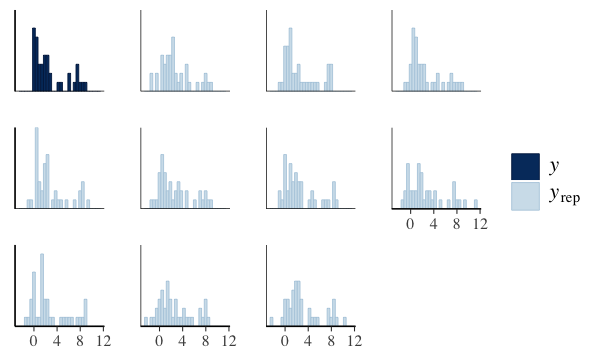

Using 10 posterior draws for ppc type 'dens_overlay' by default.



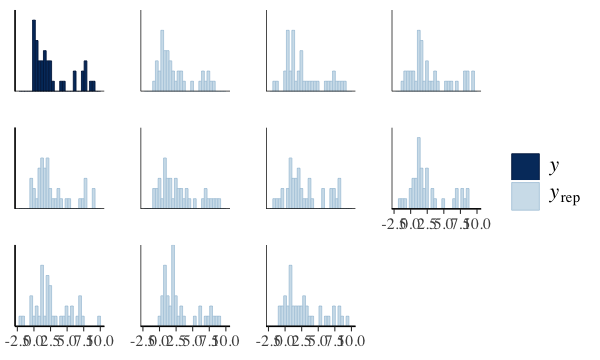

Using 10 posterior draws for ppc type 'dens_overlay' by default.



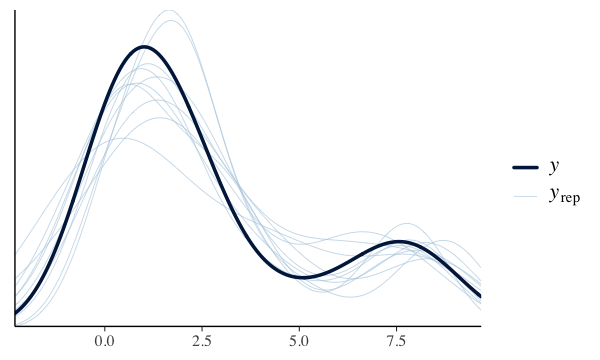

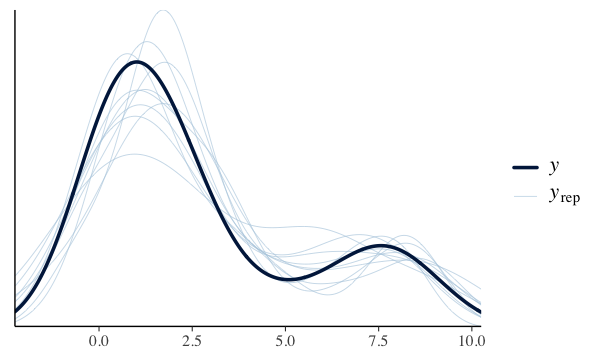

In [114]:
# Check posterior predictive distribution using a histogram
pp_check(bayes_model_2.2, type = "hist")

pp_check(bayes_model_random_slope, type = "hist")

# Overlay observed data and simulated data
pp_check(bayes_model_2.2, type = "dens_overlay")
pp_check(bayes_model_random_slope, type = "dens_overlay")


In [87]:
prior <- c(
  set_prior("normal(0, 5)", class = "b"),  # Prior for all fixed effects (including intercept)
  set_prior("normal(0, 5)", class = "b", coef = "sqrtpHPTemperature"),  # Prior for pH
  #set_prior("normal(0, 5)", class = "b", coef = "t2pHTemperature_2"),  # Prior for Temperature
 # set_prior("normal(0, 5)", class = "b", coef = "t2pHTemperature_3"),  # Prior for the interaction term pH * Temperature
  set_prior("student_t(3, 0, 2.5)", class = "sd", group = "Paper"),  # Random effects standard deviation for Paper
  set_prior("lkj(1)", class = "cor", group = "Paper"),  # Prior for correlation of random effects
 # set_prior("student_t(3, 0, 2.5)", class = "sd", coef = "pH:Temperature"),  # Smooth term for non-linear effect
  set_prior("student_t(3, 0, 2.5)", class = "sigma")  # Residual standard deviation
)

# Fit the model with the updated priors
bayes_model_2.2_refined <- brm(
  Constant ~ sqrt(pH + Temperature) + (1 + pH * Temperature | Paper),
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.99, max_treedepth = 12),
  prior = prior,  # Apply the priors
  save_pars = save_pars(all = TRUE)
)


Warning message:
“The global prior 'normal(0, 5)' of class 'b' will not be used in the model as all related coefficients have individual priors already. If you did not set those priors yourself, then maybe brms has assigned default priors. See ?set_prior and ?default_prior for more details.”
Compiling Stan program...

Start sampling

Warning message:
“There were 4 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [3]:
bayes_model_2.2 <- brm(
  Constant ~ t2(pH, Temperature) + (1+pH + Temperature | Paper),  
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.999, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)

Compiling Stan program...

Start sampling



In [4]:
library(loo)
loo_results <- loo(bayes_model_2.2, save_psis = TRUE)


Warning message:
“Found 8 observations with a pareto_k > 0.7 in model 'bayes_model_2.2'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”


In [124]:
# Generate predictions
pred_2 <- predict(bayes_model2, newdata = cl_lit)
pred_4 <- predict(bayes_model4, newdata = cl_lit)
pred_2.1 <- predict(bayes_model_2.1, newdata = cl_lit)
pred_2.2 <- predict(bayes_model_2.2, newdata = cl_lit)

# Function for evaluation
evaluate_model <- function(actual, predicted) {
  list(
    RMSE = sqrt(mean((actual - predicted)^2)),
    MAE = mean(abs(actual - predicted)),
    R2 = 1 - sum((actual - predicted)^2) / sum((actual - mean(actual))^2)
  )
}

# Compare models
eval_2 <- evaluate_model(cl_lit$Constant, pred_2[, "Estimate"])
eval_4 <- evaluate_model(cl_lit$Constant, pred_4[, "Estimate"])
eval_2.1 <- evaluate_model(cl_lit$Constant, pred_2.1[, "Estimate"])
eval_2.2 <- evaluate_model(cl_lit$Constant, pred_2.2[, "Estimate"])

# Print results
results <- data.frame(
  Model = c("Model 2", "Model 4", "Model 2.1", "Model 2.2"),
  RMSE = c(eval_2$RMSE, eval_4$RMSE, eval_2.1$RMSE, eval_2.2$RMSE),
  MAE = c(eval_2$MAE, eval_4$MAE, eval_2.1$MAE, eval_2.2$MAE),
  R2 = c(eval_2$R2, eval_4$R2, eval_2.1$R2, eval_2.2$R2)
)

print(results)


      Model      RMSE       MAE        R2
1   Model 2 0.5922378 0.4281574 0.9560962
2   Model 4 0.5555143 0.3655463 0.9613722
3 Model 2.1 0.5490568 0.3511385 0.9622650
4 Model 2.2 0.5414730 0.3573817 0.9633002


In [132]:
loo_2 <- loo(bayes_model2)
loo_4 <- loo(bayes_model4)
loo_2.1 <- loo(bayes_model_2.1)
loo_2.2 <- loo(bayes_model_2.2)

loo_compare(loo_2, loo_4, loo_2.1, loo_2.2)


Warning message:
“Found 4 observations with a pareto_k > 0.7 in model 'bayes_model2'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”
Warning message:
“Found 7 observations with a pareto_k > 0.7 in model 'bayes_model4'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”
Warning message:
“Found 6 observations with a pareto_k > 0.7 in model 'bayes_model_2.1'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”
Warning message:
“Found 7 observations with a pareto_k > 0.7 in model 'bayes_model_2.2'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”


,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
bayes_model_2.2,0.0000000,0.000000,-57.29102,9.765363,18.86031,6.745075,114.5820,19.53073
bayes_model4,-0.6863750,0.909793,-57.97740,10.094393,19.47143,7.045301,115.9548,20.18879
bayes_model_2.1,-0.8443762,1.025081,-58.13540,9.608719,19.21692,6.649027,116.2708,19.21744
bayes_model2,-3.4913656,1.742667,-60.78239,8.980944,19.36485,6.348625,121.5648,17.96189


In [16]:
bayes_model_pH2_temp <- brm(
  Constant ~ pH + I(pH^2) + Temperature + I(pH^2):Temperature + (1 | Paper),
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.99, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)
bayes_model_pH_temp2 <- brm(
  Constant ~ pH + I(Temperature^2) + pH:Temperature + (1 | Paper),
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.99, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)
bayes_model_logpH_temp <- brm(
  Constant ~ log(pH) + Temperature + log(pH):Temperature + (1 | Paper),
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.99, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)
bayes_model_inv_pH_temp <- brm(
  Constant ~ (1/pH) + Temperature + (1/pH):Temperature + (1 | Paper),
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.99, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)
bayes_model_random_slope <- brm(
  Constant ~ pH + Temperature + pH * Temperature + (1 + pH * Temperature | Paper),
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.99, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)
bayes_model_random_slope_pH2 <- brm(
  Constant ~ pH + I(pH^2) + Temperature + (1 + pH + pH^2 + Temperature | Paper),
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.999, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)


Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling



In [105]:
bayes_model_random_slope_pH2 <- brm(
  Constant ~ pH + I(pH^2) + Temperature + (1 + pH + pH^2 + Temperature | Paper),
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.999, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)

Compiling Stan program...

Start sampling



In [108]:
# Generate predictions
pred_pH2_temp <- predict(bayes_model_pH2_temp, newdata = cl_lit)
pred_pH_temp2 <- predict(bayes_model_pH_temp2, newdata = cl_lit)
pred_logpH_temp <- predict(bayes_model_logpH_temp, newdata = cl_lit)
pred_2.2 <- predict(bayes_model_2.2, newdata = cl_lit)
pred_inv_pH_temp <- predict(bayes_model_inv_pH_temp, newdata = cl_lit)
pred_random_slope <- predict(bayes_model_random_slope, newdata = cl_lit)
pred_random_slope_pH2 <- predict(bayes_model_random_slope_pH2, newdata = cl_lit)

# Function for evaluation
evaluate_model <- function(actual, predicted) {
  list(
    RMSE = sqrt(mean((actual - predicted)^2)),
    MAE = mean(abs(actual - predicted)),
    R2 = 1 - sum((actual - predicted)^2) / sum((actual - mean(actual))^2)
  )
}

# Compare models
eval_pH2_temp <- evaluate_model(cl_lit$Constant, pred_pH2_temp[, "Estimate"])
eval_pH_temp2 <- evaluate_model(cl_lit$Constant, pred_pH_temp2[, "Estimate"])
eval_logpH_temp <- evaluate_model(cl_lit$Constant, pred_logpH_temp[, "Estimate"])
eval_2.2 <- evaluate_model(cl_lit$Constant, pred_2.2[, "Estimate"])
eval_inv_pH_temp <- evaluate_model(cl_lit$Constant, pred_inv_pH_temp[, "Estimate"])
eval_random_slope <- evaluate_model(cl_lit$Constant, pred_random_slope[, "Estimate"])
eval_random_slope_pH2 <- evaluate_model(cl_lit$Constant, pred_random_slope_pH2[, "Estimate"])

# Print results
results <- data.frame(
  Model = c("Model PH2_temp", "Model PH_temp2", "Model logpH temp", "Model 2.2","Model Inv pH temp", "model Random Slop", "Model random slope PH2"),
  RMSE = c(eval_pH2_temp$RMSE, eval_pH_temp2$RMSE, eval_logpH_temp$RMSE, eval_2.2$RMSE,eval_inv_pH_temp$RMSE,eval_random_slope$RMSE,eval_random_slope_pH2$RMSE),
  MAE = c(eval_pH2_temp$MAE, eval_pH_temp2$MAE, eval_logpH_temp$MAE, eval_2.2$MAE,eval_inv_pH_temp$MAE,eval_random_slope$MAE,eval_random_slope_pH2$MAE),
  R2 = c(eval_pH2_temp$R2, eval_pH_temp2$R2, eval_logpH_temp$R2, eval_2.2$R2,eval_inv_pH_temp$R2,eval_random_slope$R2,eval_random_slope_pH2$R2)
)

print(results)


                   Model      RMSE       MAE        R2
1         Model PH2_temp 0.5931657 0.4268605 0.9559585
2         Model PH_temp2 0.6125382 0.4382501 0.9530348
3       Model logpH temp 0.5801557 0.4080323 0.9578693
4              Model 2.2 0.5418029 0.3584470 0.9632555
5      Model Inv pH temp 0.9554112 0.7314243 0.8857410
6      model Random Slop 0.5601604 0.3816263 0.9607233
7 Model random slope PH2 0.6450172 0.4396502 0.9479222


In [36]:
cor(cl_lit$pH, cl_lit$Temperature)


[1] -0.07872025

In [18]:
loo_pH2_temp <- loo(bayes_model_pH2_temp)
loo_pH_temp2 <- loo(bayes_model_pH_temp2)
loo_logpH_temp <- loo(bayes_model_logpH_temp)
loo_2.2 <- loo(bayes_model_2.2)
loo_inv_pH_temp <- loo(bayes_model_inv_pH_temp)
loo_random_slope <- loo(bayes_model_random_slope)
loo_random_slope_pH2 <- loo(bayes_model_random_slope_pH2)

loo_compare(loo_pH2_temp, loo_pH_temp2, loo_logpH_temp, loo_2.2,loo_inv_pH_temp,loo_random_slope,loo_random_slope_pH2)


Warning message:
“Found 5 observations with a pareto_k > 0.7 in model 'bayes_model_pH2_temp'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”
Warning message:
“Found 4 observations with a pareto_k > 0.7 in model 'bayes_model_pH_temp2'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”
Warning message:
“Found 5 observations with a pareto_k > 0.7 in model 'bayes_model_logpH_temp'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”
Warning message:
“Found 6 observations with a pareto_k > 0.7 in model 'bayes_model_2.2'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”
Warning message:
“Found 6 observations with a pareto_k > 0.7 in model 'bayes_model_inv_pH_temp'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problema

,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
bayes_model_random_slope,0.000000,0.0000000,-57.42613,9.970506,18.88880,6.977827,114.8523,19.941011
bayes_model_2.2,-0.395328,0.4959689,-57.82146,10.021925,19.30740,7.022722,115.6429,20.043849
bayes_model_logpH_temp,-1.136432,1.0662407,-58.56257,9.430627,18.51506,6.577839,117.1251,18.861255
bayes_model_pH2_temp,-2.554183,2.2630100,-59.98032,8.275405,18.26050,5.654604,119.9606,16.550809
bayes_model_pH_temp2,-2.945364,2.8649828,-60.37150,7.931925,17.66609,5.409991,120.7430,15.863851
bayes_model_random_slope_pH2,-3.051694,4.0378357,-60.47783,7.554658,16.56698,4.848249,120.9557,15.109315
bayes_model_inv_pH_temp,-14.947146,7.6014677,-72.37328,4.863373,13.28928,2.758996,144.7466,9.726746


In [100]:

bayes_model_combined1.2 <- brm(
  Constant ~ t2(pH, Temperature) +  (pH * Temperature | Paper),  
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.999, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)

bayes_model_combined2 <- brm(
  Constant ~ pH + I(pH^2) + Temperature + I(Temperature^2) + pH:Temperature + (1 + pH * Temperature | Paper),
  data = cl_lit,
  family = gaussian(),
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.999, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)

Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling



In [133]:

pred_model_combined <- predict(bayes_model_combined1.2, newdata = cl_lit)
pred_model_combined2 <- predict(bayes_model_combined2, newdata = cl_lit)
pred_model_2.2_refined <- predict(bayes_model_2.2_refined, newdata = cl_lit)

eval_model_combined <- evaluate_model(cl_lit$Constant, pred_model_combined[, "Estimate"])
eval_model_combined2 <- evaluate_model(cl_lit$Constant, pred_model_combined2[, "Estimate"])
eval_model_2.2_refined <- evaluate_model(cl_lit$Constant, pred_model_2.2_refined[, "Estimate"])

# Print results
results <- data.frame(
  Model = c("Model Combined","Model Combined 2","Model 2.2", "Model Random Slope","Model2.2 refined"),
  MSE = c(eval_model_combined$RMSE,eval_model_combined2$RMSE,eval_2.2$RMSE,eval_random_slope$RMSE,eval_model_2.2_refined$RMSE),
  MAE = c(eval_model_combined$MAE,eval_model_combined2$MAE,eval_2.2$MAE,eval_random_slope$MAE,eval_model_2.2_refined$MAE),
  R2 = c(eval_model_combined$R2,eval_model_combined2$R2,eval_2.2$R2,eval_random_slope$R2,eval_model_2.2_refined$R2)
        )

print(results)
loo_model_combined <- loo(bayes_model_combined1.2)
loo_model_combined2 <- loo(bayes_model_combined2)
loo_model_2.2_refined <- loo(bayes_model_2.2_refined)

loo_compare(loo_model_combined,loo_model_combined2,loo_2.2,loo_random_slope,loo_model_2.2_refined)

               Model       MSE       MAE        R2
1     Model Combined 0.5397985 0.3558176 0.9635269
2   Model Combined 2 0.5494493 0.3505616 0.9622110
3          Model 2.2 0.5414730 0.3573817 0.9633002
4 Model Random Slope 0.5601604 0.3816263 0.9607233
5   Model2.2 refined 0.5936681 0.4124489 0.9558839


Warning message:
“Found 8 observations with a pareto_k > 0.7 in model 'bayes_model_combined1.2'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”
Warning message:
“Found 5 observations with a pareto_k > 0.7 in model 'bayes_model_combined2'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”
Warning message:
“Found 7 observations with a pareto_k > 0.7 in model 'bayes_model_2.2_refined'. We recommend to set 'moment_match = TRUE' in order to perform moment matching for problematic observations. ”


,elpd_diff,se_diff,elpd_loo,se_elpd_loo,p_loo,se_p_loo,looic,se_looic
bayes_model_2.2,0.0000000,0.0000000,-57.29102,9.765363,18.86031,6.745075,114.5820,19.53073
bayes_model_random_slope,-0.1351113,0.6678326,-57.42613,9.970506,18.88880,6.977827,114.8523,19.94101
bayes_model_combined1.2,-0.4980165,0.2027081,-57.78904,9.823994,19.26700,6.840698,115.5781,19.64799
bayes_model_combined2,-2.0569760,0.9384171,-59.34800,10.201645,20.35638,7.274134,118.6960,20.40329
bayes_model_2.2_refined,-5.2827705,2.9732679,-62.57379,8.295288,20.13120,5.811968,125.1476,16.59058


### Official

In [13]:
dim(cl_lit)

[1] 40 16

In [ ]:
bayes_model_2.2 <- brm(
  Constant ~ t2(pH, Temperature) + (1+pH + Temperature | Paper),  
  data = cl_lit,
  family = gaussian(),  # Remove truncation from model
  chains = 4, iter = 4000, warmup = 1000, cores = 4,
  control = list(adapt_delta = 0.999, max_treedepth = 12),
  save_pars = save_pars(all = TRUE)
)
# Takes about 2 min to run

Compiling Stan program...

Start sampling



In [ ]:
#saveRDS(bayes_model_2.2, file = "bayes_model_2.2.rds")

In [14]:
bayes_model_2.2 <- readRDS("bayes_model_2.2.rds")

 Family: gaussian 
  Links: mu = identity 
Formula: Constant ~ t2(pH, Temperature) + (1 + pH + Temperature | Paper) 
   Data: cl_lit (Number of observations: 40) 
  Draws: 4 chains, each with iter = 4000; warmup = 1000; thin = 1;
         total post-warmup draws = 12000

Smoothing Spline Hyperparameters:
                       Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sds(t2pHTemperature_1)     1.40      1.32     0.05     4.77 1.00     8956
sds(t2pHTemperature_2)     1.70      1.57     0.06     5.66 1.00     9949
sds(t2pHTemperature_3)     2.03      1.73     0.08     6.42 1.00     7168
                       Tail_ESS
sds(t2pHTemperature_1)     6318
sds(t2pHTemperature_2)     6625
sds(t2pHTemperature_3)     5774

Multilevel Hyperparameters:
~Paper (Number of levels: 13) 
                           Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
sd(Intercept)                  0.60      0.54     0.02     2.00 1.00     5890
sd(pH)                         0.07      0.07     0.00

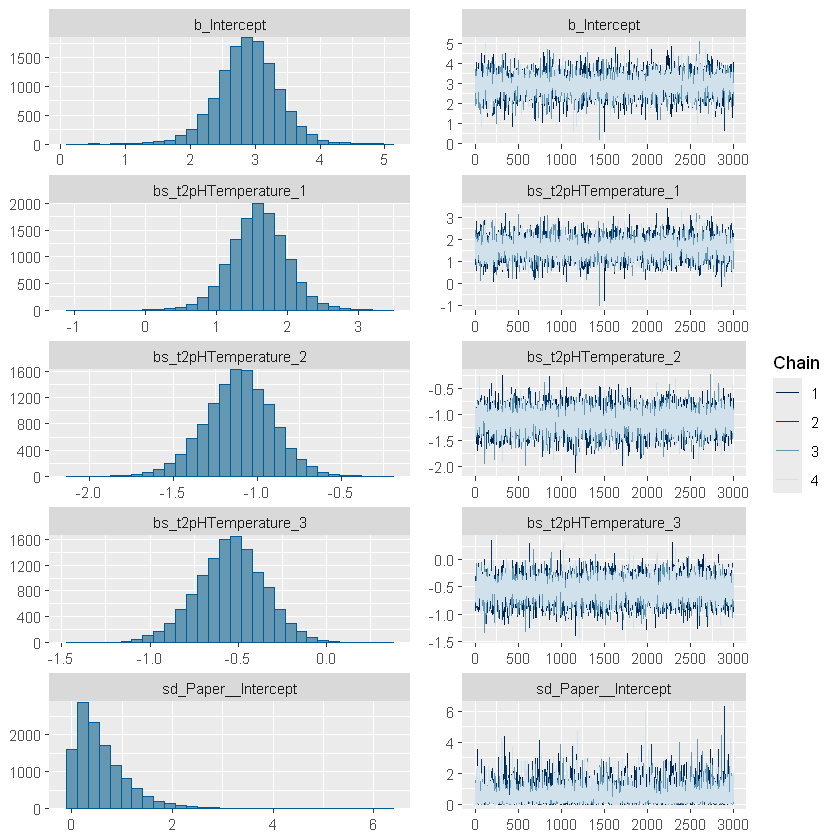

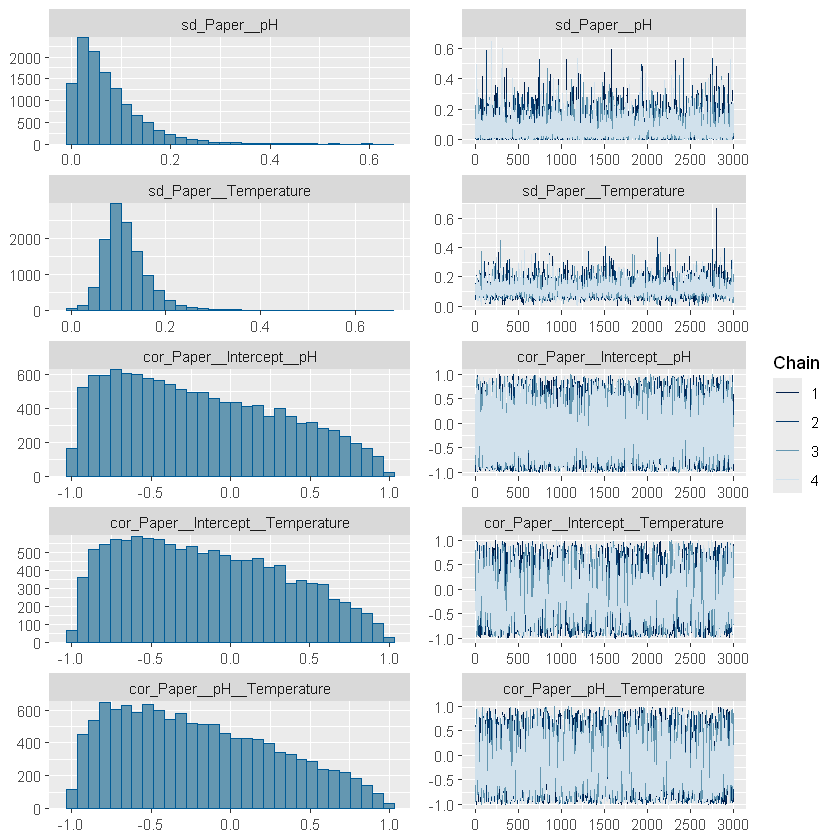

Using 10 posterior draws for ppc type 'dens_overlay' by default.



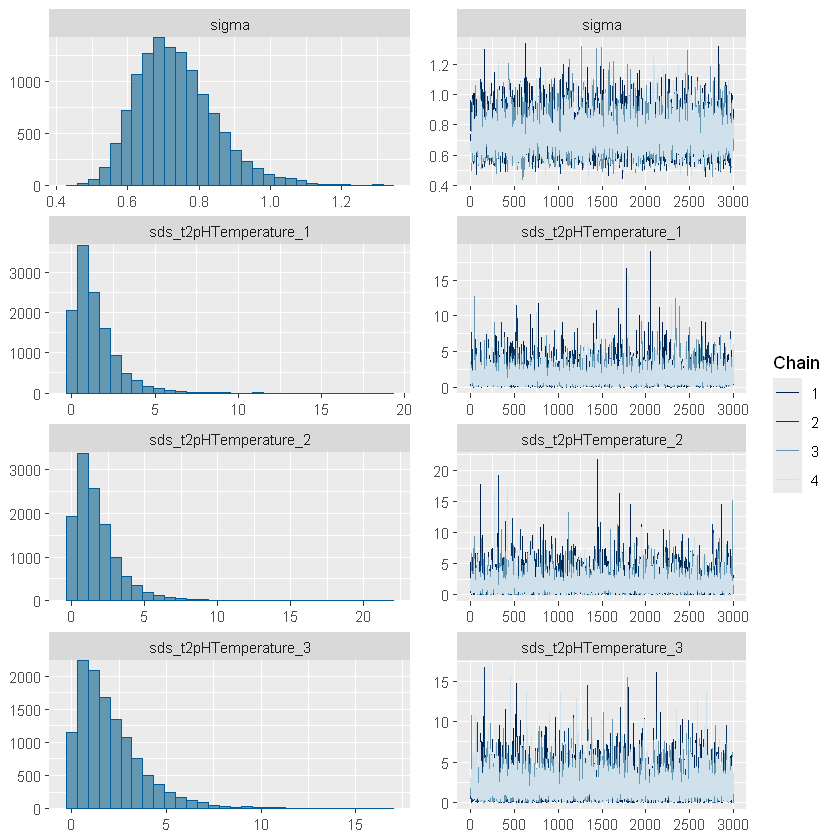

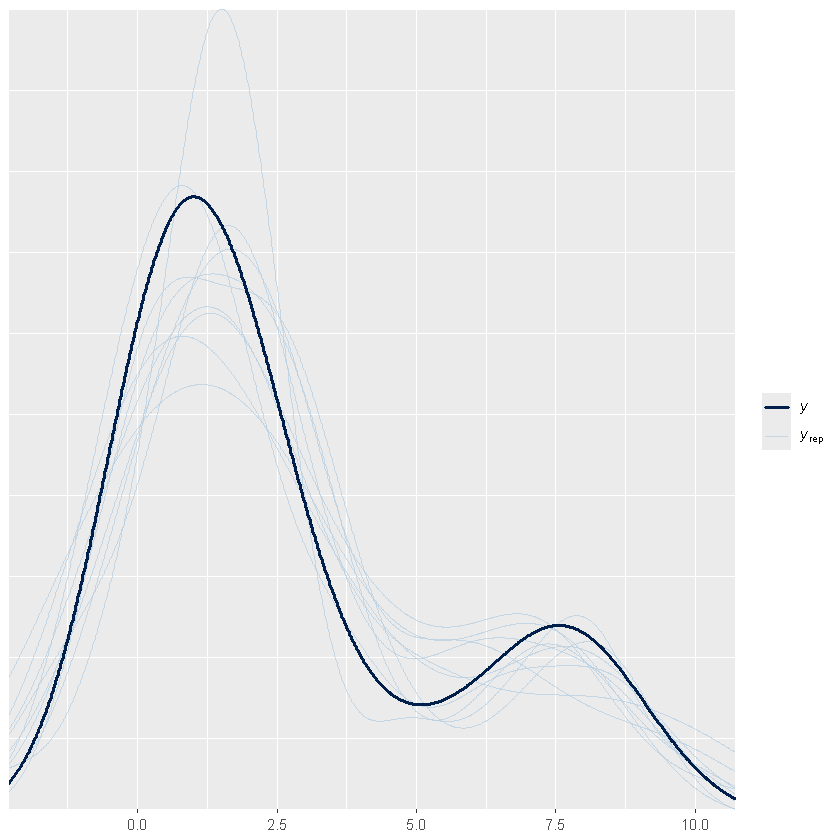

In [15]:
summary(bayes_model_2.2)  # Fixed effects and random effect estimates
plot(bayes_model_2.2)  # Trace plots & posterior distributions
pp_check(bayes_model_2.2)  # Posterior predictive checks


In [16]:
# Get posterior summaries for each parameter
posterior_summary <- summary(bayes_model_2.2)

# Extract the coefficients and their posterior distributions
coefficients <- posterior_summary$fixed

# Print the coefficients
print(coefficients)


                    Estimate Est.Error   l-95% CI   u-95% CI      Rhat
Intercept          2.8888042 0.4651389  1.9449253  3.8022589 1.0001273
t2pHTemperature_1  1.6026827 0.4008912  0.8135279  2.4119228 1.0001425
t2pHTemperature_2 -1.1111985 0.2031849 -1.5226652 -0.7175369 0.9999738
t2pHTemperature_3 -0.5431385 0.1925764 -0.9313199 -0.1700433 1.0001864
                   Bulk_ESS Tail_ESS
Intercept          6227.367 7340.692
t2pHTemperature_1  5582.916 7195.422
t2pHTemperature_2  9298.535 8610.460
t2pHTemperature_3 10106.404 8561.826


In [17]:
set.seed(111)
new_conditions <- data.frame(
  pH = c(7.5),
  Temperature = c(20),
  Paper = NA  # Set to NA to ignore study-level effects
)

predictions <- posterior_epred(bayes_model_2.2, newdata = new_conditions, allow_new_levels = TRUE)
# Constrain predictions to be >= 0 (post-processing)
predictions <- pmax(predictions, 0)
apply(predictions, 2, mean)  # Mean predicted values
apply(predictions, 2, quantile, probs = c(0.025, 0.975))  # 95% credible intervals



[1] 4.829649

2.5%,1.471728
97.5%,8.016370


In [18]:
# Compute WAIC & LOO
waic_bayes <- waic(bayes_model_2.2)
waic_bayes

loo_bayes <- loo(bayes_model_2.2, reloo = TRUE, moment_match = TRUE)
loo_bayes
# Extract LOO R² from the result
#loo_R2 <- loo_bayes$R2
#print(paste("Leave-One-Out R² for Bayesian model:", loo_R2))
# Takes about 10 min to run

Warning message:
"
7 (17.5%) p_waic estimates greater than 0.4. We recommend trying loo instead."



Computed from 12000 by 40 log-likelihood matrix.

          Estimate   SE
elpd_waic    -53.5  8.2
p_waic        15.1  5.2
waic         107.1 16.5

7 (17.5%) p_waic estimates greater than 0.4. We recommend trying loo instead. 

Warning message:
"Some Pareto k diagnostic values are too high. See help('pareto-k-diagnostic') for details.
"
4 problematic observation(s) found.
The model will be refit 4 times.


Fitting model 1 out of 4 (leaving out observation 21)

Start sampling


Fitting model 2 out of 4 (leaving out observation 38)

Start sampling


Fitting model 3 out of 4 (leaving out observation 39)

Start sampling


Fitting model 4 out of 4 (leaving out observation 40)

Start sampling




Computed from 12000 by 40 log-likelihood matrix.

         Estimate   SE
elpd_loo    -62.5 12.5
p_loo        24.1  9.5
looic       125.1 25.0
------
MCSE of elpd_loo is 0.6.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.7, 1.0]).

All Pareto k estimates are good (k < 0.7).
See help('pareto-k-diagnostic') for details.

In [53]:
bayes_R2(bayes_model_2.2)

,Estimate,Est.Error,Q2.5,Q97.5
R2,0.9384647,0.01289453,0.9067319,0.9563944


In [35]:
# Extract fixed effects (e.g., regression coefficients)
model_summary <- summary(bayes_model_2.2)

fixed_effects <- fixef(bayes_model_2.2)
n_fixed_effects <- length(fixed_effects)

# Extract random effects (e.g., random intercepts, random slopes)
random_effects <- ranef(bayes_model_2.2)
n_random_effects <- sum(sapply(random_effects, function(x) length(x)))  # Summing lengths of random effect parameters

# Extract variance components (e.g., sigma, residual standard deviation)
variance_components <- grep("^sigma", rownames(model_summary$spec_pars), value = TRUE)
n_variance_components <- length(variance_components)  # Ensure this is correct

# Calculate the total number of parameters (fixed + random + variance components)
k_eff <- n_fixed_effects + n_random_effects + n_variance_components

# Print the effective number of parameters
print(k_eff)

# Extract log-likelihood
log_likelihood <- log_lik(bayes_model_2.2)
mean_log_likelihood <- apply(log_likelihood, 2, mean)
total_log_likelihood <- sum(mean_log_likelihood)
n <- ncol(log_likelihood)  # Number of data points

# Calculate BIC
bic_bayesian <- -2 * total_log_likelihood + k_eff * log(n)
print(bic_bayesian)


Warning message:
"There were 10606 divergent transitions after warmup. Increasing adapt_delta above 0.999 may help. See http://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup"


[1] 173
[1] 700.9723


## Random Forest

In [6]:
cl_fit <- cl_lit %>%
  mutate(Paper = as.factor(Paper))
# Remove levels with too few observations, e.g., levels with < 5 observations
#cl_fit_filtered <- subset(cl_fit, Paper %in% names(which(table(cl_fit$Paper) >= 1)))



### Compare

In [9]:
lmm_random_slope <- lmer(Constant ~ pH + Temperature + (pH + Temperature | Paper), data = cl_fit)
summary(lmm_random_slope)

boundary (singular) fit: see help('isSingular')



Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Constant ~ pH + Temperature + (pH + Temperature | Paper)
   Data: cl_fit

REML criterion at convergence: 119.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4375 -0.5399 -0.1442  0.2487  2.3326 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 Paper    (Intercept) 2.35418  1.5343              
          pH          0.01419  0.1191   -1.00      
          Temperature 0.01982  0.1408   -1.00  1.00
 Residual             0.58060  0.7620              
Number of obs: 40, groups:  Paper, 13

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  5.25376    1.12610 14.99007   4.665 0.000305 ***
pH          -0.68556    0.13011 15.26389  -5.269 8.91e-05 ***
Temperature  0.25026    0.05369  7.57986   4.662 0.001870 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (In

In [51]:
study_effects <- ranef(lmm_random_slope)$Paper
cl_fit$StudyEffect_Intercept <- study_effects[cl_fit$Paper, 1]  # Map intercept effects to the dataset
cl_fit$StudyEffect_pH <- study_effects[cl_fit$Paper, 2]  # Map random slope for pH
cl_fit$StudyEffect_Temperature <- study_effects[cl_fit$Paper, 3]  # Map random slope for Temperature


In [ ]:

lmm <- lmer(Constant ~ pH + Temperature   + (1 | Paper), data = cl_fit)
summary(lmm)
study_effects <- ranef(lmm)$Paper
cl_fit$StudyEffect <- study_effects[cl_fit$Paper, 1]  # Map effects to the original dataset


In [ ]:
rf_mixed <- ranger(
  Constant ~ pH + Temperature   + StudyEffect,
  data = cl_fit,
  importance = "permutation",
  num.trees = 500
)
print(rf_mixed)
oob_error_rf <- rf_mixed$prediction.error
print(paste("Out-of-Bag Error (OOB):", oob_error_rf))

In [ ]:
# Feature engineering with polynomial terms, splines, or interactions
cl_fit$pH2 <- cl_fit$pH^2
cl_fit$Temp2 <- cl_fit$Temperature^2
cl_fit$interaction <- cl_fit$pH * cl_fit$Temperature

# Fit random forest model
rf_mixed_2 <- ranger(
  Constant ~ pH + Temperature + StudyEffect + pH2 + Temp2 + interaction,
  data = cl_fit,
  importance = "permutation",
  num.trees = 1000,  # Increase number of trees
  max.depth = 30,    # Increase tree depth for capturing more complex relationships
  min.node.size = 5, # Lower this to allow for finer splits
  sample.fraction = 0.8  # Increase sample fraction to capture more variability
)

# Check model results
rf_mixed_2$variable.importance
oob_error_rf <- rf_mixed_2$prediction.error
print(paste("Out-of-Bag Error (OOB):", oob_error_rf))

In [215]:
rf_mixed <- ranger(
  Constant ~ pH + Temperature + StudyEffect_Intercept + StudyEffect_pH + StudyEffect_Temperature,
  data = cl_fit,
  importance = "permutation",
  num.trees = 500
)
ob_error_rf <- rf_mixed$prediction.error
print(paste("Out-of-Bag Error (OOB):", oob_error_rf))

[1] "Out-of-Bag Error (OOB): 0.828730162422"


In [306]:
lmm_crossed <- lmer(Constant ~ pH + Temperature + (1 | Paper), data = cl_fit)


In [312]:
study_effects <- ranef(lmm_crossed)$Paper
#cl_fit$StudyEffect_Intercept <- study_effects$Study[, 1]  # Random intercept for Study
cl_fit$PaperEffect_Intercept <- study_effects[cl_fit$Paper, 1] # Random intercept for Paper


In [313]:
rf_crossed <- ranger(
  Constant ~ pH + Temperature  + PaperEffect_Intercept,
  data = cl_fit,
  importance = "permutation",
  num.trees = 500
)
ob_error_rf <- rf_mixed$prediction.error
print(paste("Out-of-Bag Error (OOB):", oob_error_rf))

[1] "Out-of-Bag Error (OOB): 0.828730162422"


In [52]:
cl_fit$pH_squared <- cl_fit$pH^2
cl_fit$Temperature_squared <- cl_fit$Temperature^2


In [62]:
rf_nonlinear <- ranger(
  Constant ~ pH + Temperature + pH_squared + Temperature_squared + StudyEffect_Intercept + StudyEffect_pH + StudyEffect_Temperature,
  data = cl_fit, 
  importance = "permutation",
  num.trees = 500
)
ob_error_rf <- rf_nonlinear$prediction.error
print(paste("Out-of-Bag Error (OOB):", ob_error_rf))

[1] "Out-of-Bag Error (OOB): 0.890568550944886"


In [168]:
library(brms)
bayes_lmm <- brm(
  Constant ~ t2(pH,Temperature) + (1+pH + Temperature | Paper),
  data = cl_fit,
  family = gaussian(),
  prior = c(set_prior("normal(0, 5)", class = "b"), 
            set_prior("student_t(3, 0, 1)", class = "sd")),
  chains = 4, iter = 2000, warmup = 1000
)


Compiling Stan program...

Start sampling




SAMPLING FOR MODEL 'anon_model' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 7.7e-05 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0.77 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 2000 [  0%]  (Warmup)
Chain 1: Iteration:  200 / 2000 [ 10%]  (Warmup)
Chain 1: Iteration:  400 / 2000 [ 20%]  (Warmup)
Chain 1: Iteration:  600 / 2000 [ 30%]  (Warmup)
Chain 1: Iteration:  800 / 2000 [ 40%]  (Warmup)
Chain 1: Iteration: 1000 / 2000 [ 50%]  (Warmup)
Chain 1: Iteration: 1001 / 2000 [ 50%]  (Sampling)
Chain 1: Iteration: 1200 / 2000 [ 60%]  (Sampling)
Chain 1: Iteration: 1400 / 2000 [ 70%]  (Sampling)
Chain 1: Iteration: 1600 / 2000 [ 80%]  (Sampling)
Chain 1: Iteration: 1800 / 2000 [ 90%]  (Sampling)
Chain 1: Iteration: 2000 / 2000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 0.822 seconds (Warm-up)
Chain 1:                0.678 seconds (Sampling)
Chain 1:                1.5 

Warning message:
“There were 26 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them.”
Warning message:
“Examine the pairs() plot to diagnose sampling problems
”


In [177]:
study_effects <- ranef(bayes_lmm)$Paper
cl_fit$StudyEffect_Intercept <- study_effects



ERROR: [1m[33mError[39m in `$<-`:[22m
[1m[22m[33m![39m Assigned data `study_effects` must be compatible with existing data.
[31m✖[39m Existing data has 40 rows.
[31m✖[39m Assigned data has 13 rows.
[36mℹ[39m Only vectors of size 1 are recycled.
[1mCaused by error in `vectbl_recycle_rhs_rows()`:[22m
[33m![39m Can't recycle input of size 13 to size 40.


In [320]:
rf_mixed$prediction.error
rf_crossed$prediction.error
rf_nonlinear$prediction.error
rf_mixed_2$prediction.error


[1] 0.9197526

[1] 0.8167228

[1] 0.8767356

[1] 0.8299386

In [ ]:
rf_bayes <- ranger(
  Constant ~ pH + Temperature + StudyEffect_Intercept + StudyEffect_pH + StudyEffect_Temperature,
  data = cl_fit,
  importance = "permutation",
  num.trees = 500
)
ob_error_rf <- rf_mixed$prediction.error
print(paste("Out-of-Bag Error (OOB):", oob_error_rf))

In [321]:
rf_mixed_r2 <- 1 - (rf_mixed$prediction.error / var(cl_fit$Constant))
rf_crossed_r2 <- 1 - (rf_crossed$prediction.error / var(cl_fit$Constant))
rf_nonlinear_r2 <- 1 - (rf_nonlinear$prediction.error / var(cl_fit$Constant))
rf_mixed_2_r2 <- 1 - (rf_mixed_2$prediction.error / var(cl_fit$Constant))

print(c(rf_mixed_r2, rf_crossed_r2, rf_nonlinear_r2,rf_mixed_2_r2))


[1] 0.8877502 0.9003243 0.8930001 0.8987114


In [322]:
library(Metrics)

# Get predictions
pred_mixed <- predict(rf_mixed, data = cl_fit)$predictions
pred_crossed <- predict(rf_crossed, data = cl_fit)$predictions
pred_nonlinear <- predict(rf_nonlinear, data = cl_fit)$predictions
pred_mixed_2 <- predict(rf_mixed_2, data = cl_fit)$predictions

# Compute error metrics
mse_mixed <- mse(cl_fit$Constant, pred_mixed)
mse_crossed <- mse(cl_fit$Constant, pred_crossed)
mse_nonlinear <- mse(cl_fit$Constant, pred_nonlinear)
mse_mixed_2 <- mse(cl_fit$Constant, pred_mixed_2)

mae_mixed <- mae(cl_fit$Constant, pred_mixed)
mae_crossed <- mae(cl_fit$Constant, pred_crossed)
mae_nonlinear <- mae(cl_fit$Constant, pred_nonlinear)
mae_mixed_2 <- mae(cl_fit$Constant, pred_mixed_2)

print(data.frame(Model = c("Mixed", "Crossed", "Nonlinear","Mixed 2"),
                 MSE = c(mse_mixed, mse_crossed, mse_nonlinear,mse_mixed_2),
                 MAE = c(mae_mixed, mae_crossed, mae_nonlinear,mae_mixed_2)))


      Model       MSE       MAE
1     Mixed 0.3912393 0.4396168
2   Crossed 0.3746575 0.4283131
3 Nonlinear 0.3572917 0.4125681
4   Mixed 2 0.3604627 0.4086921


In [323]:

rf_mixed$variable.importance
rf_crossed$variable.importance
rf_nonlinear$variable.importance
rf_mixed_2$variable.importance

pH             Temperature   StudyEffect_Intercept 
               1.219110                1.988369                3.225150 
         StudyEffect_pH StudyEffect_Temperature 
               2.620666                3.095574

pH           Temperature PaperEffect_Intercept 
             2.836605              3.218793              4.697198

pH             Temperature              pH_squared 
              0.9468390               1.5340808               0.8770515 
    Temperature_squared   StudyEffect_Intercept          StudyEffect_pH 
              1.6433687               2.3947633               2.2280670 
StudyEffect_Temperature 
              2.0767619

pH Temperature StudyEffect         pH2       Temp2 interaction 
   1.387855    1.885746    4.264270    1.251555    1.971349    1.069355

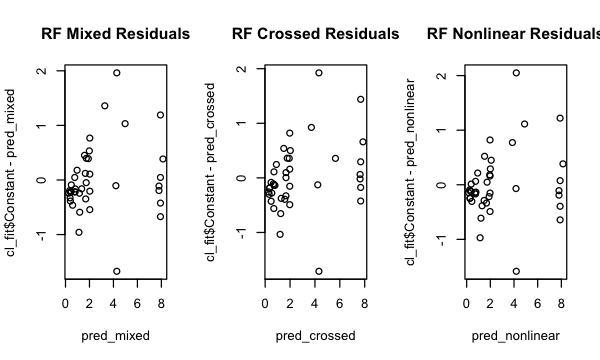

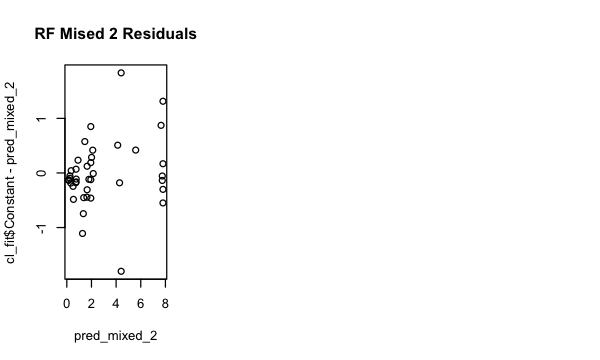

In [201]:
par(mfrow = c(1,3),bg = "white")
plot(pred_mixed, cl_fit$Constant - pred_mixed, main="RF Mixed Residuals")
plot(pred_crossed, cl_fit$Constant - pred_crossed, main="RF Crossed Residuals")
plot(pred_nonlinear, cl_fit$Constant - pred_nonlinear, main="RF Nonlinear Residuals")
plot(pred_mixed_2, cl_fit$Constant - pred_mixed_2, main="RF Mised 2 Residuals")


In [325]:
library(caret)

cv_mixed <- train(Constant ~ pH + Temperature + StudyEffect_Intercept + StudyEffect_pH + StudyEffect_Temperature, data = cl_fit,
                  method = "ranger", trControl = trainControl(method = "cv", number = 5))

cv_crossed <- train(Constant ~ pH + Temperature  + PaperEffect_Intercept, data = cl_fit,
                    method = "ranger", trControl = trainControl(method = "cv", number = 5))

cv_nonlinear <- train(Constant ~ pH + Temperature + pH_squared + Temperature_squared + StudyEffect_Intercept + StudyEffect_pH + StudyEffect_Temperature, data = cl_fit,
                      method = "ranger", trControl = trainControl(method = "cv", number = 5))
cv_mixed_2 <- train(Constant ~ pH + Temperature + StudyEffect + pH2 + Temp2 + interaction, data = cl_fit,
                      method = "ranger", trControl = trainControl(method = "cv", number = 5))

print(cv_mixed$results)
print(cv_crossed$results)
print(cv_nonlinear$results)
print(cv_mixed_2$results)


note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .

  mtry min.node.size  splitrule      RMSE  Rsquared       MAE    RMSESD
1    2             5   variance 0.9572441 0.9182284 0.7073961 0.3208450
2    2             5 extratrees 0.8767903 0.9537211 0.6543262 0.3157920
3    3             5   variance 0.9673961 0.9075332 0.6958764 0.3113032
4    3             5 extratrees 0.8498440 0.9556682 0.6385825 0.3000889
5    4             5   variance 0.9284957 0.9125589 0.6477941 0.3117314
6    4             5 extratrees 0.8942750 0.9467541 0.6720069 0.2948481
  RsquaredSD     MAESD
1 0.06228072 0.2170194
2 0.02533513 0.2110222
3 0.07449690 0.1892119
4 0.02673783 0.2025339
5 0.07396947 0.1920530
6 0.03399888 0.1774415
  mtry min.node.size  splitrule      RMSE  Rsquared       MAE    RMSESD
1    2             5   variance 0.8546340 0.9121981 0.5906306 0.2342280
2    2             5 extratrees 0.9231847 0.9037579 0.6757455 0.1723012
  RsquaredSD     MAESD
1 0.05201

### Official

In [7]:

lmm_random_slope <- lmer(Constant ~ pH + Temperature + (pH + Temperature | Paper), data = cl_fit)
study_effects <- ranef(lmm_random_slope)$Paper
cl_fit$StudyEffect_Intercept <- study_effects[cl_fit$Paper, 1]  # Map intercept effects to the dataset
cl_fit$StudyEffect_pH <- study_effects[cl_fit$Paper, 2]  # Map random slope for pH
cl_fit$StudyEffect_Temperature <- study_effects[cl_fit$Paper, 3]  # Map random slope for Temperature

cl_fit$pH_squared <- cl_fit$pH^2
cl_fit$Temperature_squared <- cl_fit$Temperature^2


boundary (singular) fit: see help('isSingular')



In [8]:
summary(lmm_random_slope)

Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: Constant ~ pH + Temperature + (pH + Temperature | Paper)
   Data: cl_fit

REML criterion at convergence: 119.6

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.4375 -0.5399 -0.1442  0.2487  2.3326 

Random effects:
 Groups   Name        Variance Std.Dev. Corr       
 Paper    (Intercept) 2.35418  1.5343              
          pH          0.01419  0.1191   -1.00      
          Temperature 0.01982  0.1408   -1.00  1.00
 Residual             0.58060  0.7620              
Number of obs: 40, groups:  Paper, 13

Fixed effects:
            Estimate Std. Error       df t value Pr(>|t|)    
(Intercept)  5.25376    1.12610 14.99007   4.665 0.000305 ***
pH          -0.68556    0.13011 15.26389  -5.269 8.91e-05 ***
Temperature  0.25026    0.05369  7.57986   4.662 0.001870 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (In

In [9]:
rf_nonlinear <- ranger(
  Constant ~ pH + Temperature + pH_squared + Temperature_squared + StudyEffect_Intercept + StudyEffect_pH + StudyEffect_Temperature,
  data = cl_fit, 
  importance = "permutation",
  num.trees = 5000, seed = 111
)
ob_error_rf <- rf_nonlinear$prediction.error
print(paste("Out-of-Bag Error (OOB):", ob_error_rf))

[1] "Out-of-Bag Error (OOB): 0.886684224093159"


In [27]:
rf_nonlinear

Ranger result

Call:
 ranger(Constant ~ pH + Temperature + pH_squared + Temperature_squared +      StudyEffect_Intercept + StudyEffect_pH + StudyEffect_Temperature,      data = cl_fit, importance = "permutation", num.trees = 5000,      seed = 111) 

Type:                             Regression 
Number of trees:                  5000 
Sample size:                      40 
Number of independent variables:  7 
Mtry:                             2 
Target node size:                 5 
Variable importance mode:         permutation 
Splitrule:                        variance 
OOB prediction error (MSE):       0.8866842 
R squared (OOB):                  0.891786 

In [28]:
rf_nonlinear$variable.importance

pH             Temperature              pH_squared 
              0.8287978               1.4519638               0.8657617 
    Temperature_squared   StudyEffect_Intercept          StudyEffect_pH 
              1.5308422               2.3549283               2.2312310 
StudyEffect_Temperature 
              2.2102891

In [29]:
set.seed(111)
new_conditions <- data.frame(
  pH = c(7.5),
  Temperature = c(20),
  pH_squared = c(56.25),
  Temperature_squared = c(400),
  StudyEffect_Intercept = 0,  # If Study is unknown, set effect to 0 (average case)
  StudyEffect_pH = 0,
  StudyEffect_Temperature = 0
)


predictions <- predict(rf_nonlinear, new_conditions)$predictions
print(predictions)




[1] 4.033252


In [30]:
set.seed(111)

# Predict with confidence intervals
rf_preds <- predict(rf_nonlinear, data = new_conditions, type = "response", predict.all = TRUE)

# Extract the 95% confidence interval from quantiles
#lower_bound <- apply(rf_preds, 1, function(x) quantile(x, probs = 0.025))  # Lower bound (2.5% quantile)
#upper_bound <- apply(rf_preds, 1, function(x) quantile(x, probs = 0.975))  # Upper bound (97.5% quantile)

quantile(rf_preds$predictions, probs = c(0.025, 0.5, 0.975))
# Combine the predictions and intervals


2.5%       50%     97.5% 
0.8779094 4.2795704 7.6637641

In [31]:
apply(rf_preds$predictions, 1, mean)

[1] 4.033252

## GPR

In [40]:
#cl_fit$Strain <- as.numeric(as.factor(cl_fit$Strain))  # Convert to numeric IDs
cl_fit$Paper <- as.numeric(as.factor(cl_fit$Paper))  # Convert to numeric IDs


### Compare

In [250]:
# Function to compute RMSE
compute_rmse <- function(predictions, true_values) {
  sqrt(mean((predictions - true_values)^2, na.rm = TRUE))
}

# Grid of hyperparameters to search
matern_nu_values <- c(0.5, 1,1.5,2, 2.5)  # Different smoothness levels
matern_kappa_values <- c(0.1,0.5, 1,2, 10)  # Length scale range
rbf_sigma_values <- c(0.1, 0.5,1,2, 10)    # RBF sigma values

# Initialize variables to store results
results <- data.frame(Kernel = character(), Hyperparameters = character(), RMSE = numeric())

# Loop through Matern kernel hyperparameters
for (nu in matern_nu_values) {
  for (kappa in matern_kappa_values) {
    matern_kernel <- kernlab::rbfdot(sigma = kappa)  # Matern kernel with kappa as length scale
    
    # Fit GPR model with Matern kernel
    gpr_matern <- GauPro(
      X = X_matrix, 
      Z = Z_vector, 
      kernel = matern_kernel, 
      noise = cl_fit$Paper
    )
    
    # Predictions and RMSE for Matern kernel
    preds_matern <- predict(gpr_matern, X_matrix)
    rmse_matern <- compute_rmse(preds_matern, Z_vector)
    
    # Store the results
    results <- rbind(results, data.frame(Kernel = "Matern", 
                                         Hyperparameters = paste("nu =", nu, "kappa =", kappa), 
                                         RMSE = rmse_matern))
  }
}

# Loop through RBF kernel hyperparameters
for (sigma in rbf_sigma_values) {
  rbf_kernel <- rbfdot(sigma = sigma)  # RBF kernel with sigma as length scale
  
  # Fit GPR model with RBF kernel
  gpr_rbf <- GauPro(
    X = X_matrix, 
    Z = Z_vector, 
    kernel = rbf_kernel, 
    noise = cl_fit$Paper
  )
  
  # Predictions and RMSE for RBF kernel
  preds_rbf <- predict(gpr_rbf, X_matrix)
  rmse_rbf <- compute_rmse(preds_rbf, Z_vector)
  
  # Store the results
  results <- rbind(results, data.frame(Kernel = "RBF", 
                                       Hyperparameters = paste("sigma =", sigma), 
                                       RMSE = rmse_rbf))
}

# Show the results of hyperparameter search
print(results)

# Optionally, you can sort the results by RMSE to find the best hyperparameters
best_kernel <- results[which.min(results$RMSE), ]
print(paste("Best kernel:", best_kernel$Kernel))
print(paste("Best hyperparameters:", best_kernel$Hyperparameters))


Error in eval(expr, envir) : chol(): decomposition failed
Error in eval(expr, envir) : chol(): decomposition failed
Error in eval(expr, envir) : chol(): decomposition failed
   Kernel      Hyperparameters      RMSE
1  Matern nu = 0.5 kappa = 0.1 0.6026249
2  Matern nu = 0.5 kappa = 0.5 0.6129965
3  Matern   nu = 0.5 kappa = 1 0.6129965
4  Matern   nu = 0.5 kappa = 2 0.6129965
5  Matern  nu = 0.5 kappa = 10 0.5979535
6  Matern   nu = 1 kappa = 0.1 0.6129965
7  Matern   nu = 1 kappa = 0.5 0.6026249
8  Matern     nu = 1 kappa = 1 0.6129965
9  Matern     nu = 1 kappa = 2 0.6026249
10 Matern    nu = 1 kappa = 10 0.6129965
11 Matern nu = 1.5 kappa = 0.1 0.5979535
12 Matern nu = 1.5 kappa = 0.5 0.6129965
13 Matern   nu = 1.5 kappa = 1 0.6129965
14 Matern   nu = 1.5 kappa = 2 0.6129965
15 Matern  nu = 1.5 kappa = 10 0.6129965
16 Matern   nu = 2 kappa = 0.1 0.6026249
17 Matern   nu = 2 kappa = 0.5 0.6026249
18 Matern     nu = 2 kappa = 1 0.6129965
19 Matern     nu = 2 kappa = 2 0.5979534
20 Mat

Minimal change in RMSE between different hyperparameters

In [248]:
# Example for Matern Kernel
gpr_matern <- GauPro(
  X = X_matrix,  # your predictor matrix
  Z = Z_vector,  # your response vector
  kernel = kernlab::matern(kappa = 1, sigma = 1),
  noise = cl_fit$Paper
)

# Example for RBF Kernel
gpr_rbf <- GauPro(
  X = X_matrix,  # your predictor matrix
  Z = Z_vector,  # your response vector
  kernel = kernlab::rbfdot(sigma = 1),
  noise = cl_fit$Paper
)

# Example for Linear Kernel
gpr_linear <- GauPro(
  X = X_matrix,  # your predictor matrix
  Z = Z_vector,  # your response vector
  kernel = kernlab::vanilladot(),
  noise = cl_fit$Paper
)

# Example for GauPro Kernel
gpr_gaus <- GauPro(
  X = X_matrix,  # your predictor matrix
  Z = Z_vector,  # your response vector
  kernel = GauPro::GauPro_kernel_model(),
  noise = cl_fit$Paper
)


Error in eval(expr, envir) : chol(): decomposition failed


In [249]:
# Function to compute RMSE or R^2 (example with RMSE)
compute_rmse <- function(predictions, true_values) {
  sqrt(mean((predictions - true_values)^2))
}

# Obtain predictions (example for Matern kernel)
preds_matern <- predict(gpr_matern, X_matrix)
rmse_matern <- compute_rmse(preds_matern, Z_vector)

# Repeat for other kernels (RBF, Linear, GauPro)
preds_rbf <- predict(gpr_rbf, X_matrix)
rmse_rbf <- compute_rmse(preds_rbf, Z_vector)

preds_linear <- predict(gpr_linear, X_matrix)
rmse_linear <- compute_rmse(preds_linear, Z_vector)

preds_gaus <- predict(gpr_gaus, X_matrix)
rmse_gaus <- compute_rmse(preds_gaus, Z_vector)

# Compare RMSE
data.frame(
  Kernel = c("Matern", "RBF", "Linear", "GauPro"),
  RMSE = c(rmse_matern, rmse_rbf, rmse_linear, rmse_gaus)
)


Kernel,RMSE
<chr>,<dbl>
Matern,0.6129965
RBF,0.6062182
Linear,0.6026249
GauPro,0.6129965


Minimal change in RMSE between different kernels

### Official

In [41]:
# Convert X to a matrix and Z to a vector
X_matrix <- as.matrix(cl_fit[, c("pH", "Temperature")])
Z_vector <- as.vector(cl_fit$Constant)

# Check the dimensions after conversion
dim(X_matrix)  # Should be (n, p), where n is number of observations and p is number of predictors
length(Z_vector)  # Should match the number of rows in X_matrix


[1] 40  2

[1] 40

In [42]:
set.seed(111)

gp_model_study <- GauPro(
  X = X_matrix,  # X as a matrix
  Z = Z_vector,  # Z as a vector
  kernel = GauPro::GauPro_kernel_model(),
  noise = cl_fit$Paper  # Study-level variability as additional noise
)

print(gp_model_study)


Warning message:
"`GauPro_Gauss$new()` was deprecated in GauPro 0.2.12.
ℹ Please use GauPro::gpkm(X, Z) instead
ℹ The deprecated feature was likely used in the R6 package.
  Please report the issue at <https://github.com/r-lib/R6/issues>."


GauPro object of GauPro_Gauss
	D = 2, N = 40
	Theta =  0.236 0.0233 
	Nugget = 0.0922
	Run update to add data and/or optimize again
	Use pred to get predictions at new points


In [47]:
# Check the column order of X_matrix
print(colnames(X_matrix))
# Or if it doesn't have column names:
print(dimnames(X_matrix)[[2]])

[1] "pH"          "Temperature"
[1] "pH"          "Temperature"


In [48]:
# Absolute Change
perturb_feature <- function(feature_index, X_matrix, gp_model_study) {
  set.seed(123)  # Ensure reproducibility
  
  # Make a copy of X_matrix and perturb one feature
  perturbed_data <- as.matrix(X_matrix)
  perturbed_data[, feature_index] <- sample(perturbed_data[, feature_index])  # Perturb feature
  
  # Get predictions for perturbed data
  prediction_output_perturbed <- predict(gp_model_study, XX = perturbed_data)
  prediction_output_perturbed <- as.vector(prediction_output_perturbed)  # Convert to vector
  # Constrain predictions to be >= 0 (post-processing)
  prediction_output_perturbed <- pmax(prediction_output_perturbed, 0)

  # Get the original predictions (before perturbation)
  prediction_output_original <- predict(gp_model_study, XX = as.matrix(X_matrix))
  prediction_output_original <- as.vector(prediction_output_original)  # Convert to vector
  # Constrain predictions to be >= 0 (post-processing)
  prediction_output_original <- pmax(prediction_output_original, 0)

  # Calculate the mean of original predictions
  original_mean <- mean(prediction_output_original)
  
  # Calculate the mean of perturbed predictions
  perturbed_mean <- mean(prediction_output_perturbed)
  
  # Calculate the absolute change in prediction (you can use relative change if preferred)
  prediction_change <- abs(perturbed_mean - original_mean)
  
  return(prediction_change)
}

# Get column names from X_matrix
feature_names <- colnames(X_matrix)
# If X_matrix doesn't have column names, set them manually based on how you created it
# For example, if X_matrix was created as: as.matrix(cl_fit[, c("pH", "Temperature")])
# Then: feature_names <- c("pH", "Temperature")

# Calculate importance by perturbing each feature
feature_importance <- sapply(1:ncol(X_matrix), function(i) perturb_feature(i, X_matrix, gp_model_study))

# Add names to the vector
names(feature_importance) <- feature_names

print(feature_importance)

         pH Temperature 
  0.5470094   0.6777470 


In [44]:
# Function to perturb the Paper noise term
perturb_paper_noise <- function(gp_model, X_matrix, Z_vector, noise_level, perturbed_noise) {
  set.seed(123)  # Ensure reproducibility
  
  # Perturb the noise term for Paper (Study-level variability)
  perturbed_gp_model <- GauPro(
    X = X_matrix,  # X as a matrix
    Z = Z_vector,  # Z as a vector
    kernel = GauPro::GauPro_kernel_model(),
    noise = perturbed_noise  # Perturbed noise for Paper
  )
  
  # Get predictions with the perturbed model
  prediction_output_perturbed <- predict(perturbed_gp_model, XX = X_matrix)
  # Constrain predictions to be >= 0 (post-processing)
  prediction_output_perturbed <- pmax(prediction_output_perturbed, 0)

  # Get the original predictions
  prediction_output_original <- predict(gp_model, XX = X_matrix)
  # Constrain predictions to be >= 0 (post-processing)
  prediction_output_original <- pmax(prediction_output_original, 0)
  
  # Calculate the mean of the original and perturbed predictions
  original_mean <- mean(prediction_output_original)
  perturbed_mean <- mean(prediction_output_perturbed)
  
  # Calculate the absolute change in prediction
  prediction_change <- abs(perturbed_mean - original_mean)
  
  return(prediction_change)
}

# Example of perturbing the Paper noise term
# You would create a perturbed noise level (in this case, increasing the noise by a small amount)
perturbed_noise <- cl_fit$Paper + 100  # Increase the noise level by 0.1
prediction_change <- perturb_paper_noise(gp_model_study, X_matrix, Z_vector, cl_fit$Paper, perturbed_noise)

print(paste("Prediction change due to perturbation of Paper noise:", prediction_change))


[1] "Prediction change due to perturbation of Paper noise: 2.17603712826531e-14"


In [45]:

new_conditions <- as.matrix(data.frame(
  pH = c(7.5),
  Temperature = c(20)
))

predictions <- gp_model_study$predict(new_conditions,  se.fit = TRUE)

# Extract values from the matrix
pred_mean <- predictions[1, "mean"]
pred_se <- predictions[1, "se"]

# Constrain predictions to be >= 0 (post-processing)
pred_mean <- pmax(pred_mean, 0)

# Compute 95% Confidence Interval
lower95 <- pred_mean - 1.96 * pred_se
upper95 <- pred_mean + 1.96 * pred_se

# Also constrain lower bound to be >= 0
lower95 <- pmax(lower95, 0)

# Print results
print(paste("Mean:", pred_mean))
print(paste("Standard Error:", pred_se))
print(paste("95% CI Lower Bound:", lower95))
print(paste("95% CI Upper Bound:", upper95))


[1] "Mean: 4.9257963524019"
[1] "Standard Error: 0.90531182152614"
[1] "95% CI Lower Bound: 3.15138518221067"
[1] "95% CI Upper Bound: 6.70020752259313"


In [46]:
# RMSE
cl_matrix <- as.matrix(cl_fit[, c("pH", "Temperature")])

# Predict using the GauPro model
gpr_preds <- gp_model_study$predict(cl_matrix, se.fit=TRUE)

# Extract the mean predictions
pred_mean <- gpr_preds$mean  
pred_mean <- pmax(pred_mean, 0)
# Compute RMSE
rmse_gpr <- sqrt(mean((as.numeric(pred_mean) - as.numeric(cl_fit$Constant))^2, na.rm = TRUE))

# Print RMSE
print(rmse_gpr)


[1] 0.6652269


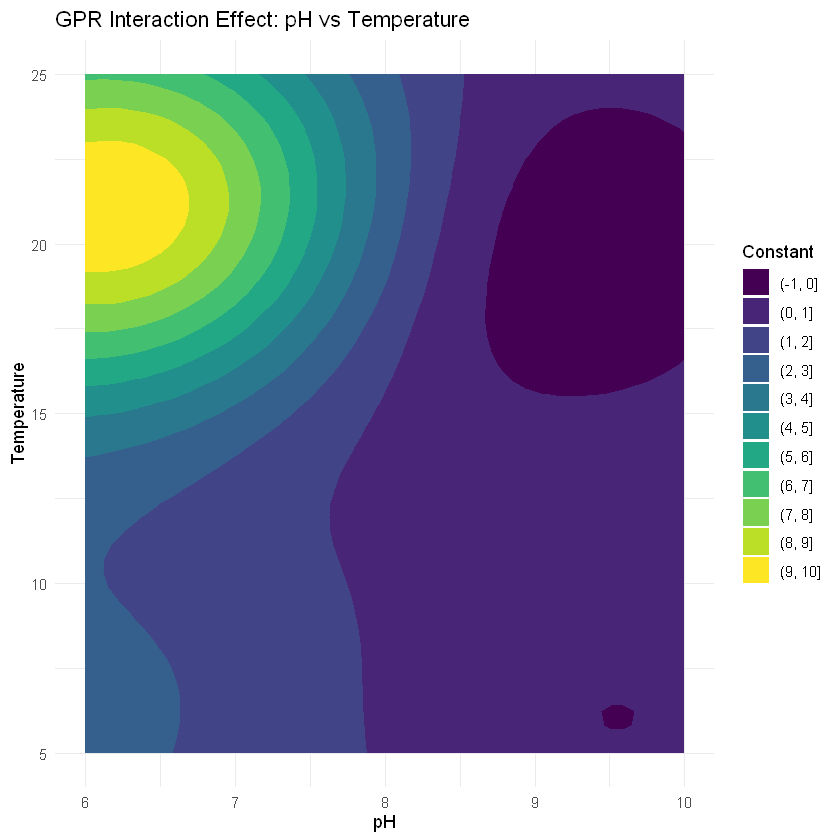

In [ ]:
# Create grid of values
pH_seq <- seq(min(cl_fit$pH), max(cl_fit$pH), length.out = 50)
Temperature_seq <- seq(min(cl_fit$Temperature), max(cl_fit$Temperature), length.out = 50)
grid <- expand.grid(pH = pH_seq, Temperature = Temperature_seq)

# Predict over the grid
grid_predictions <- predict(gp_model_study, XX = as.matrix(grid))
# Constrain predictions to be >= 0 (post-processing)
grid_predictions <- pmax(grid_predictions, 0)

# Convert to a data frame for plotting
grid$Prediction <- grid_predictions

# Plot interaction as a contour plot
library(ggplot2)
ggplot(grid, aes(x = pH, y = Temperature, z = Prediction)) +
  geom_contour_filled() +
  labs(title = "GPR Interaction Effect: pH vs Temperature",
       x = "pH", y = "Temperature", fill = "Constant") +
  theme_minimal()


In [ ]:
perturb_interaction <- function(X_matrix, gp_model_study) {
  set.seed(123)

  perturbed_data <- as.matrix(X_matrix)
  
  # Shuffle both pH and Temperature together
  perturbed_data[, c("pH", "Temperature")] <- apply(
    perturbed_data[, c("pH", "Temperature")], 2, sample
  )
  
  # Get predictions
  original_preds <- predict(gp_model_study, XX = X_matrix)
  # Constrain predictions to be >= 0 (post-processing)
  original_preds <- pmax(original_preds, 0)

  perturbed_preds <- predict(gp_model_study, XX = perturbed_data)
  # Constrain predictions to be >= 0 (post-processing)
  perturbed_preds <- pmax(perturbed_preds, 0)

  # Compute absolute mean difference
  mean(abs(perturbed_preds - original_preds))
}

interaction_importance <- perturb_interaction(X_matrix, gp_model_study)
print(interaction_importance)


[1] 3.224685


## Model Comparison

### LOO CV

In [25]:

loo_lmer_r2 <- function(data, seed = 123) {
  set.seed(seed)
  n <- nrow(data)
  preds <- numeric(n)
  
  for (i in seq_len(n)) {
    test_data <- data[i, , drop = FALSE]
    train_data <- data[-i, , drop = FALSE]
    
    # Fit model with same formula and REML = FALSE
    lmer_fit <- lmer(Constant ~ 
                       Temperature + 
                       pH + 
                       pH_squared + 
                       TemperaturexpH + 
                       (1 | Paper),
                     data = train_data, REML = FALSE)
    
    # Predict for the held-out observation
    test_pred <- predict(lmer_fit, newdata = test_data, allow.new.levels = TRUE)
    # Constrain predictions to be >= 0 (post-processing)
    preds[i] <- pmax(test_pred, 0)
  }
  
  # Compute LOO-CV R²
  y_true <- data$Constant
  ss_total <- sum((y_true - mean(y_true))^2)
  ss_residual <- sum((y_true - preds)^2)
  r2_loo <- 1 - (ss_residual / ss_total)
  
  return(r2_loo)
}

r2_lmer_loo <- loo_lmer_r2(cl_lit)
print(paste("LOO-CV R² for lmer model:", round(r2_lmer_loo, 4)))


[1] "LOO-CV R² for lmer model: 0.8481"


In [37]:


cv_rf_r2_loo <- function(model_formula, data, seed = 123) {
  set.seed(seed)
  n <- nrow(data)
  preds <- numeric(n)
  
  for (i in 1:n) {
    test_data <- data[i, , drop = FALSE]
    train_data <- data[-i, , drop = FALSE]
    
    set.seed(seed + i)  # ensure each LOO model is reproducible
    rf_model_loo <- randomForest(model_formula, data = train_data, ntree = 500)
    
    preds[i] <- predict(rf_model_loo, newdata = test_data)
  }
  
  y_true <- data$Constant
  SSE <- sum((y_true - preds)^2)
  SST <- sum((y_true - mean(y_true))^2)
  r2_loo <- 1 - SSE / SST
  
  return(r2_loo)
}

# Example usage: Compute LOO R² for the Random Forest model
r2_rf_loo <- cv_rf_r2_loo(Constant ~ pH + Temperature + pH_squared + Temperature_squared + StudyEffect_Intercept + StudyEffect_pH + StudyEffect_Temperature, cl_fit)
print(paste("LOO CV R² for Random Forest:", r2_rf_loo))


[1] "LOO CV R² for Random Forest: 0.89425972953253"


In [53]:
loo_gpr_r2 <- function(data, seed = 123) {
  n <- nrow(data)
  preds <- numeric(n)
  
  for (i in 1:n) {
    set.seed(seed + i)  # Different seed for each refit
    
    test_data <- data[i, , drop = FALSE]
    train_data <- data[-i, , drop = FALSE]
    
    gpr_model_loo <- GauPro(
      X = as.matrix(train_data[, c("pH", "Temperature")]),
      Z = as.vector(train_data$Constant),
      kernel = GauPro::GauPro_kernel_model(),
      noise = train_data$Paper  # or remove if not relevant
    )
    
    preds[i] <- gpr_model_loo$predict(as.matrix(test_data[, c("pH", "Temperature")]))[1]
    # Constrain predictions to be >= 0 (post-processing)
    preds[i] <- pmax(preds[i], 0)
  }
  
  y_true <- data$Constant
  SSE <- sum((y_true - preds)^2)
  SST <- sum((y_true - mean(y_true))^2)
  r2_loo <- 1 - SSE / SST
  
  return(r2_loo)
}


# Example usage: Compute LOO R² for GPR
r2_gpr_loo <- loo_gpr_r2(cl_fit, seed = 123)
print(paste("LOO CV R² for GPR:", r2_gpr_loo))

Error in eval(expr, envir) : chol(): decomposition failed
Error in eval(expr, envir) : chol(): decomposition failed
Error in eval(expr, envir) : solve(): solution not found
Error in eval(expr, envir) : chol(): decomposition failed
Error in eval(expr, envir) : chol(): decomposition failed
Error in eval(expr, envir) : chol(): decomposition failed
Error in eval(expr, envir) : chol(): decomposition failed
[1] "LOO CV R² for GPR: 0.841092331399661"


### K fold validation

In [26]:

cv_lmer_r2 <- function(model_formula, data, k = 5, seed = 123) {
  set.seed(seed)
  n <- nrow(data)
  fold_indices <- sample(rep(1:k, length.out = n))  # Assign each observation to a fold
  R2_values <- numeric(k)  # To store R² from each fold

  for (fold in 1:k) {
    test_indices <- which(fold_indices == fold)
    train_data <- data[-test_indices, , drop = FALSE]
    test_data <- data[test_indices, , drop = FALSE]

    # Fit the lmer model on training data
    lmer_model_kfold <- lmer(
      formula = model_formula,
      data = train_data,
      REML = FALSE
    )

    # Predict on test data
    y_pred <- predict(lmer_model_kfold, newdata = test_data, allow.new.levels = TRUE)
    # Constrain predictions to be >= 0 (post-processing)
    y_pred <- pmax(y_pred, 0)
    y_true <- test_data$Constant

    # Compute fold R²
    SSE <- sum((y_true - y_pred)^2)
    SST <- sum((y_true - mean(y_true))^2)
    R2_values[fold] <- 1 - SSE / SST
  }

  avg_R2 <- mean(R2_values)
  return(avg_R2)
}

# Using your full lmer formula
lmer_formula <- Constant ~ Temperature + pH + pH_squared + TemperaturexpH + (1 | Paper)

# Run 5-fold CV
r2_lmer_cv <- cv_lmer_r2(model_formula = lmer_formula, data = cl_lit, k = 5)
print(paste("Average R² for lmer model (5-fold CV):", round(r2_lmer_cv, 4)))


[1] "Average R² for lmer model (5-fold CV): 0.7465"


In [21]:
# Cross-validation function for Bayesian model

cv_bayesian_r2_global <- function(model_formula, data, k = 5, seed = 123) {
  set.seed(seed)
  n <- nrow(data)
  fold_indices <- sample(rep(1:k, length.out = n))  # Balanced fold assignment
  
  all_preds <- numeric(n)
  all_true <- numeric(n)
  
  for (fold in 1:k) {
    # Split data into training and test sets
    test_indices <- which(fold_indices == fold)
    train_data <- data[-test_indices, , drop = FALSE]
    test_data <- data[test_indices, , drop = FALSE]
    
    # Fit Bayesian model on training fold
    set.seed(seed + fold)
    bayes_model_kfold <- brm(
      formula = model_formula,
      data = train_data,
      family = gaussian(),
      chains = 4, iter = 4000, warmup = 1000, cores = 4,
      control = list(adapt_delta = 0.999, max_treedepth = 12),
      save_pars = save_pars(all = TRUE)
    )
    
    # Predict on the test set
    preds <- posterior_epred(bayes_model_kfold, newdata = test_data, allow_new_levels = TRUE)
    # Constrain predictions to be >= 0 (post-processing)
    preds <- pmax(preds, 0)
    y_pred <- colMeans(preds)  # Mean posterior prediction
    y_true <- test_data$Constant
    
    # Store predictions and true values
    all_preds[test_indices] <- y_pred
    all_true[test_indices] <- y_true
  }
  
  # Compute global cross-validated R²
  SSE <- sum((all_true - all_preds)^2)
  SST <- sum((all_true - mean(all_true))^2)
  global_R2 <- 1 - SSE / SST
  
  return(global_R2)
}

# Example usage: Perform 5-fold CV for the Bayesian model
r2_bayesian_cv <- cv_bayesian_r2_global("Constant ~ t2(pH, Temperature) + (1+pH + Temperature | Paper)", cl_lit, k = 5)

print(paste("Global k-fold CV R² for Bayesian model:", round(r2_bayesian_cv, 4)))


Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling

Compiling Stan program...

Start sampling

Warning message:
"There were 1 divergent transitions after warmup. See
https://mc-stan.org/misc/warnings.html#divergent-transitions-after-warmup
to find out why this is a problem and how to eliminate them."
Warning message:
"Examine the pairs() plot to diagnose sampling problems
"
Compiling Stan program...

Start sampling



[1] "Global k-fold CV R² for Bayesian model: 0.8541"


In [22]:
r2_bayesian_cv

[1] 0.8540857

In [36]:

# Cross-validation function for Random Forest
cv_rf_r2_global <- function(model_formula, data, k = 5, seed = 123) {
  set.seed(seed)
  n <- nrow(data)
  
  folds <- createFolds(data$Constant, k = k, list = TRUE)
  
  all_preds <- numeric(n)
  all_true <- numeric(n)
  
  for (i in 1:k) {
    test_idx <- folds[[i]]
    train_data <- data[-test_idx, ]
    test_data <- data[test_idx, ]
    
    set.seed(seed + i)  # make RF model reproducible per fold
    rf_model <- randomForest(model_formula, data = train_data, ntree = 500)
    
    y_pred <- predict(rf_model, newdata = test_data)
    y_true <- test_data$Constant
    
    all_preds[test_idx] <- y_pred
    all_true[test_idx] <- y_true
  }
  
  # Compute global R² across all folds
  SSE <- sum((all_true - all_preds)^2)
  SST <- sum((all_true - mean(all_true))^2)
  R2_global <- 1 - SSE / SST
  
  return(R2_global)
}

# Example usage
r2_rf_k_fold<- cv_rf_r2_global(Constant ~ pH + Temperature + pH_squared + Temperature_squared + StudyEffect_Intercept + StudyEffect_pH + StudyEffect_Temperature, cl_fit)
print(paste("Mean R² for RF (5-fold CV):", r2_rf_k_fold))


[1] "Mean R² for RF (5-fold CV): 0.898317028305527"


In [54]:

k_fold_cv_gpr_global <- function(data, k = 5, seed = 123) {
  set.seed(seed)
  n <- nrow(data)
  
  # Random fold assignment
  folds <- sample(rep(1:k, length.out = n))
  
  all_preds <- numeric(n)
  all_true <- data$Constant
  
  for (i in 1:k) {
    test_idx <- which(folds == i)
    train_data <- data[-test_idx, ]
    test_data <- data[test_idx, ]
    
    set.seed(seed + i)  # For reproducibility of model fit
    gpr_model_kfold <- GauPro(
      X = as.matrix(train_data[, c("pH", "Temperature")]),
      Z = as.vector(train_data$Constant),
      kernel = GauPro::GauPro_kernel_model(),
      noise = train_data$Paper  # if needed, else remove
    )
    
    pred_mat <- predict(gpr_model_kfold, as.matrix(test_data[, c("pH", "Temperature")]))
    all_preds[test_idx] <- as.numeric(pred_mat[, 1])
    # Constrain predictions to be >= 0 (post-processing)
    all_preds[test_idx] <- pmax(all_preds[test_idx], 0)
  }
  
  # Compute global R²
  SSE <- sum((all_true - all_preds)^2)
  SST <- sum((all_true - mean(all_true))^2)
  R2_global <- 1 - SSE / SST
  
  return(R2_global)
}

# Example usage: Perform 5-fold cross-validation for GPR
r2_gpr_k_fold <- k_fold_cv_gpr_global(cl_fit, k = 5, seed = 123)
print(paste("Mean R² for GPR (5-fold CV):", r2_gpr_k_fold))


Error in eval(expr, envir) : solve(): solution not found
[1] "Mean R² for GPR (5-fold CV): 0.81329599509792"


### LMM

In [27]:
r.squaredGLMM(M_best_subset)

R2m,R2c
0.4914432,0.909946


In [28]:
sqrt(mean(residuals(M_best_subset)^2))

[1] 0.5735433

### Bayesian

In [55]:
# R2
r2_bayes <- bayes_R2(bayes_model_2.2)
print(r2_bayes)

    Estimate  Est.Error      Q2.5     Q97.5
R2 0.9384647 0.01289453 0.9067319 0.9563944


In [54]:
#RMSE
# Compute squared errors for each posterior sample and observation
posterior_pred <- posterior_predict(bayes_model_2.2)
# Constrain predictions to be >= 0 (post-processing)
posterior_pred <- pmax(posterior_pred, 0)

squared_errors <- (posterior_pred - matrix(cl_lit$Constant, nrow = nrow(posterior_pred), ncol = ncol(posterior_pred), byrow = TRUE))^2

# Compute RMSE for each posterior sample
rmse_per_sample <- sqrt(rowMeans(squared_errors, na.rm = TRUE))

# Summarize the RMSE distribution
mean_rmse <- mean(rmse_per_sample)

print(mean_rmse)


[1] 0.9561268


In [19]:
set.seed(111)

# Extract log-likelihood matrix
log_lik_matrix <- log_lik(bayes_model_2.2)

# Step 1: Get the log-likelihood matrix (draws × observations)
ll_matrix <- log_lik(bayes_model_2.2)

# Step 2: Apply PSIS to each observation
psis_obj <- psis(ll_matrix)  # returns a list of pointwise weights

# Step 3: Extract posterior predictions
pp_matrix <- posterior_predict(bayes_model_2.2)  # matrix: draws × observations
# Constrain predictions to be >= 0 (post-processing)
pp_matrix <- pmax(pp_matrix, 0)

# Step 4: Convert PSIS weights to a matrix for the draws × observations shape
psis_weights <- weights(psis_obj, log = FALSE)  # same shape as pp_matrix

# Step 5: Compute the weighted mean for each observation
weighted_preds <- colSums(pp_matrix * psis_weights) / colSums(psis_weights)

# Step 6: Compute PSIS-LOO R²
y_true <- cl_lit$Constant
SSE <- sum((y_true - weighted_preds)^2)
SST <- sum((y_true - mean(y_true))^2)
psis_loo_r2 <- 1 - SSE / SST

print(paste("PSIS-LOO R² for Bayesian model:", psis_loo_r2))

[1] "PSIS-LOO R² for Bayesian model: 0.979004179002174"


### RF

In [33]:
#R2
rf_preds <- predict(rf_nonlinear, data = cl_fit)$predictions
r2_rf <- cor(rf_preds, cl_fit$Constant)^2
print(r2_rf)




[1] 0.9558947


In [34]:
#RMSE
rmse_rf <- sqrt(mean((rf_nonlinear$predictions - cl_fit$Constant)^2, na.rm = TRUE))

print(rmse_rf)


[1] 0.9416391


In [35]:
# OOB R2
rf_nonlinear$r.squared

[1] 0.891786

### GPR

In [49]:
# R2
gpr_preds <- predict(gp_model_study, as.matrix(cl_fit[, c("pH", "Temperature")]))  # Extracting the mean predictions
gpr_preds <- as.vector(gpr_preds)
# Constrain predictions to be >= 0 (post-processing)
gpr_preds <- pmax(gpr_preds, 0)
# Compute R²
r2_gpr <- cor(gpr_preds, cl_fit$Constant)^2
# Print R²
print(r2_gpr)


[1] 0.9454003


### Comparison

In [85]:
print(mean_rmse)
print(rmse_rf)
print(rmse_gpr)

[1] 1.023047
[1] 0.9416391
[1] 0.6652269


In [111]:
# Create a comparison table
comparison_results <- data.frame(
  Model = c("LMM", "Bayesian", "Random Forest", "GPR"),
  R2 = c(0.909946, r2_bayes[1,1], r2_rf, r2_gpr),
  RMSE = c(NA, mean_rmse,rmse_rf, rmse_gpr),  # RMSE for GPR
  AIC = c(129.6 , NA,NA,NA), 
  WAIC = c(NA, 107.1, NA, NA),  # WAIC for Bayesian only
  LOO = c(NA, 124.7, NA, NA),   # LOO for Bayesian only
  OOB_Error = c(NA, NA, ob_error_rf, NA),  # Out-of-Bag Error for Random Forest
  kfold = c(r2_lmer_cv,r2_bayesian_cv, r2_rf_k_fold, r2_gpr_k_fold),
  LooCV= c(r2_lmer_loo,NA, r2_rf_loo, r2_gpr_loo),
  PSISCV= c(NA,psis_loo_r2, NA, NA)

)

# Print comparison table
print(comparison_results)

# WAIC & LOO: Lower values indicate a better Bayesian model.
# OOB Error: Lower is better for Random Forest.
# RMSE: Lower is better for GPR.

          Model        R2      RMSE   AIC  WAIC   LOO OOB_Error     kfold
1           LMM 0.9099460        NA 129.6    NA    NA        NA 0.7112161
2      Bayesian 0.9383294 1.0230472    NA 107.1 124.7        NA 0.8453915
3 Random Forest 0.9558947 0.9416391    NA    NA    NA 0.8866842 0.8983170
4           GPR 0.9454003 0.6652269    NA    NA    NA        NA 0.8131082
      LooCV    PSISCV
1 0.8419911        NA
2        NA 0.9807454
3 0.8942597        NA
4 0.8410923        NA


### Figure 4: Residual Plot

In [56]:
gp_model_no_paper <- GauPro(
  X = X_matrix,
  Z = Z_vector,
  kernel = GauPro::GauPro_kernel_model()
)
preds_no_paper <- predict(gp_model_no_paper, as.matrix(cl_fit[, c("pH", "Temperature")]))
# Constrain predictions to be >= 0 (post-processing)
preds_no_paper <- pmax(preds_no_paper, 0)

In [60]:
new_conditions

pH,Temperature,pH_squared,TemperaturexpH,Paper
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
7.5,20,56.25,150,NA


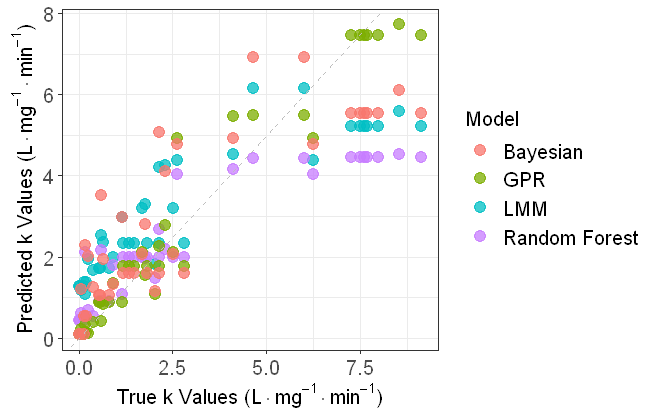

In [67]:
get_predictions <- function(model, data, model_name) {
      # For Bayesian model
  if (model_name == "LMM") {
    # Prepare data for Bayesian prediction
    data_for_lmm <- data[, c("pH", "Temperature","pH_squared","TemperaturexpH","Paper")]
    new_conditions_lmm <- data_for_lmm %>% mutate( Paper = NA)
   # data_for_bayesian$Strain <- factor(data_for_bayesian$Strain)  # Ensure factor is kept if needed

    # Get predictions from Bayesian model
    preds <- as.numeric(predict(model, newdata = new_conditions_lmm, re.form = NA ))
    # Constrain predictions to be >= 0 (post-processing)
    preds <- pmax(preds, 0)
  }
    
    # For Bayesian model
  if (model_name == "Bayesian") {
    # Prepare data for Bayesian prediction
    data_for_bayesian <- data[, c("pH", "Temperature","Paper")]
    new_conditions_bayes <- data_for_bayesian %>% mutate( Paper = NA)
   # data_for_bayesian$Strain <- factor(data_for_bayesian$Strain)  # Ensure factor is kept if needed
    
    # Get predictions from Bayesian model (exclude random effects with re_formula = NA)
    preds <- apply(posterior_epred(model, newdata = new_conditions_bayes, allow_new_levels = TRUE, re_formula = NA),2,mean)
    # Constrain predictions to be >= 0 (post-processing)
    preds <- pmax(preds, 0)
  }
  
    
    # For Random Forest
  if (model_name == "Random Forest") {
    
    data_for_rf_nonlinear <- data[, c("pH", "Temperature","pH_squared","Temperature_squared","StudyEffect_Intercept","StudyEffect_pH","StudyEffect_Temperature")]
    # Set study effects to 0 to exclude paper/study effects
    data_for_rf_nonlinear <- data_for_rf_nonlinear %>% 
      mutate(StudyEffect_Intercept = 0, 
             StudyEffect_pH = 0, 
             StudyEffect_Temperature = 0)
    preds <- predict(model, data_for_rf_nonlinear)$predictions
    # Constrain predictions to be >= 0 (post-processing)
    preds <- pmax(preds, 0)
  }
  # For GPR (assuming use of GauPro package)
  if (model_name == "GPR") {
    # Ensure Strain and Paper are converted to numeric if needed
    #cl_fit$Paper <- as.numeric(as.factor(cl_fit$Paper))
    # Prediction for GPR model
    #preds <- predict(model, as.matrix(data[, c("pH", "Temperature")]))
    preds <- predict(model, as.matrix(data[, c("pH", "Temperature")]))
    # Constrain predictions to be >= 0 (post-processing)
    preds <- pmax(preds, 0)
  }
 

  # Combine true values and predicted values in a data frame
  df <- data.frame(True = data$Constant, Predicted = preds, Model = model_name)
  return(df)
}

# Example usage for each model
lmm_predictions <- get_predictions(M_best_subset, cl_lit, "LMM")
bayesian_predictions <- get_predictions(bayes_model_2.2, cl_lit, "Bayesian")
rf_predictions <- get_predictions(rf_nonlinear, cl_fit, "Random Forest")
gpr_predictions <- get_predictions(gp_model_no_paper, cl_fit, "GPR")


# Combine all predictions into one data frame
all_predictions <- rbind(lmm_predictions,rf_predictions, gpr_predictions, bayesian_predictions)

options(repr.plot.width=5.5, repr.plot.height=3.5)
# Plot true vs predicted values for all models
Figure_4<- ggplot(all_predictions, aes(x = True, y = Predicted, color = Model)) +
  geom_point(size=3, alpha=0.75) + 
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray") +  # Identity line
  labs(y = expression("Predicted k Values ("*L %.% mg^{-1} %.% min^{-1}*")"), x = expression("True k Values ("*L %.% mg^{-1} %.% min^{-1}*")"))+
  theme_minimal() +
  theme_bw()+
  theme(text = element_text(size = 12),axis.text = element_text(size = 12), legend.text = element_text(size = 12))
Figure_4

ggsave(filename = file.path(fig_dir, "Figure_4.png"), plot = Figure_4, width = 5, height = 3, dpi = 300)

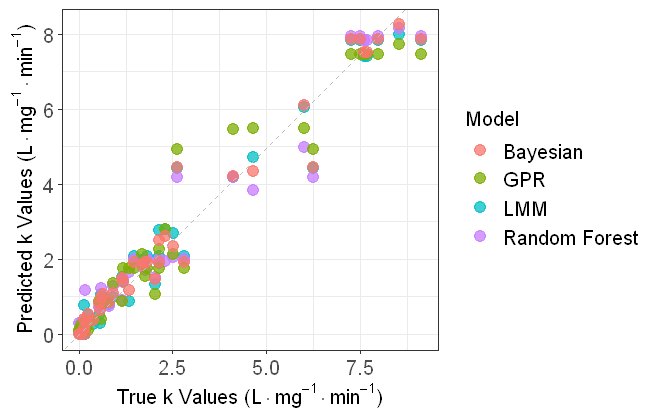

In [69]:
get_predictions <- function(model, data, model_name) {
   # For LMM model
   if (model_name == "LMM") {
    # Prepare data for LMM prediction
    data_for_lmm <- data[, c("pH", "Temperature","pH_squared","TemperaturexpH","Paper")]
   # Keep Paper as is (don't set to NA) to include random effects

    # Get predictions from LMM model (WITH random effects - remove re.form = NA)
    preds <- as.numeric(predict(model, newdata = data_for_lmm))  # Removed re.form = NA
    # Constrain predictions to be >= 0 (post-processing)
    preds <- pmax(preds, 0)
  }
    if (model_name == "Bayesian") {
    # Prepare data for Bayesian prediction
    data_for_bayesian <- data[, c("pH", "Temperature","Paper")]
   # Keep Paper as is (don't set to NA) to include random effects
    
    # Get predictions from Bayesian model (WITH random effects - no re_formula = NA)
    preds <- apply(posterior_epred(model, newdata = data_for_bayesian, allow_new_levels = TRUE),2,mean)
    # Constrain predictions to be >= 0 (post-processing)
    preds <- pmax(preds, 0)
  }
  
    
    # For Random Forest
  if (model_name == "Random Forest") {
    # Use data as-is to include study effects
    data_for_rf <- data[, c("pH", "Temperature","pH_squared","Temperature_squared","StudyEffect_Intercept","StudyEffect_pH","StudyEffect_Temperature")]
    preds <- predict(model, data_for_rf)$predictions
    # Constrain predictions to be >= 0 (post-processing)
    preds <- pmax(preds, 0)
  }
  
  # For GPR
  if (model_name == "GPR") {
    # Prediction for GPR model (using gp_model_study which includes Paper noise)
    preds <- predict(model, as.matrix(data[, c("pH", "Temperature")]))
    # Constrain predictions to be >= 0 (post-processing)
    preds <- pmax(preds, 0)
  }
 
  # Combine true values and predicted values in a data frame
  df <- data.frame(True = data$Constant, Predicted = preds, Model = model_name)
  return(df)
}
  
lmm_predictions <- get_predictions(M_best_subset, cl_lit, "LMM")    
bayesian_predictions <- get_predictions(bayes_model_2.2, cl_lit, "Bayesian")
rf_predictions <- get_predictions(rf_nonlinear, cl_fit, "Random Forest")
gpr_predictions <- get_predictions(gp_model_study, cl_fit, "GPR")


# Combine all predictions into one data frame
all_predictions <- rbind(lmm_predictions,rf_predictions, gpr_predictions, bayesian_predictions)

options(repr.plot.width=5.5, repr.plot.height=3.5)
# Plot true vs predicted values for all models
Figure_s8<- ggplot(all_predictions, aes(x = True, y = Predicted, color = Model)) +
  geom_point(size=3, alpha=0.75) + 
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "gray") +  # Identity line
  labs(y = expression("Predicted k Values ("*L %.% mg^{-1} %.% min^{-1}*")"), x = expression("True k Values ("*L %.% mg^{-1} %.% min^{-1}*")"))+
  theme_minimal() +
  theme_bw()+
  theme(text = element_text(size = 12),axis.text = element_text(size = 12), legend.text = element_text(size = 12))
Figure_s8

ggsave(filename = file.path(fig_dir, "Figure_s8.png"), plot = Figure_s8, width = 5, height = 3, dpi = 300)

In [123]:
head(gpr_predictions)
head(rf_predictions)
head(bayesian_predictions)

,True,Predicted,Model
,<dbl>,<dbl>,<chr>
1,0.55405954,0.8866342,GPR
2,1.67719161,2.1247755,GPR
3,0.02112463,0.1048114,GPR
4,2.03624823,1.0783934,GPR
5,2.52247987,2.1247755,GPR
6,0.13324396,0.1048114,GPR


,True,Predicted,Model
,<dbl>,<dbl>,<chr>
1,0.55405954,0.7301063,Random Forest
2,1.67719161,1.8766796,Random Forest
3,0.02112463,0.2847321,Random Forest
4,2.03624823,1.5082902,Random Forest
5,2.52247987,2.0485774,Random Forest
6,0.13324396,0.4078237,Random Forest


,True,Predicted,Model
,<dbl>,<dbl>,<chr>
1,0.55405954,0.8368101,Bayesian
2,1.67719161,1.8488709,Bayesian
3,0.02112463,-0.1201933,Bayesian
4,2.03624823,1.4549014,Bayesian
5,2.52247987,2.3490074,Bayesian
6,0.13324396,0.3951755,Bayesian


# Predicting 4 Logs

## LMM

In [32]:
set.seed(123)

# Step 1: Create the grid for pH and Temperature combinations
pH_values <- c(6, 7, 8, 9, 10)
Temperature_values <- c(5, 10, 15, 20, 25)
grid <- expand.grid(pH = pH_values, Temperature = Temperature_values)

# Step 2: Add required interaction and polynomial terms used in your model
grid$pH_squared <- grid$pH^2
grid$TemperaturexpH <- grid$pH * grid$Temperature
grid$Paper <- NA  # Needed to ignore grouping factor in prediction

# Step 3: Get design matrix for fixed effects
form_lmm <- formula(M_best_subset)
f_fixed <- update(form_lmm, . ~ . - (1 | Paper))
f_fixed <- update(f_fixed, NULL ~ .)
X_mat <- model.matrix(f_fixed, data = grid)

# Step 4: Compute predicted values from fixed effects
pred_mean <- as.vector(X_mat %*% fixef(M_best_subset))
# Constrain predictions to be >= 0 (post-processing)
pred_mean <- pmax(pred_mean, 0)

# Step 5: Compute standard errors of predictions
pred_var <- diag(X_mat %*% vcov(M_best_subset) %*% t(X_mat))
pred_se <- sqrt(pred_var)

# Step 6: Conservative prediction (5th percentile)
lower5 <- pred_mean - qnorm(.95) * pred_se
lower5 <- pmax(lower5, 0)  # Prevent negative values

# Step 7: Compute 4-log CT values
#CT_4log <- ifelse(lower5 > 0, 4 / lower5, NA)
CT_4log <- 4 / lower5

# Step 8: Combine into final dataframe
result_lmm <- data.frame(
  grid,
  mean_prediction = pred_mean,
  lower5_prediction = lower5,
  CT_4log = CT_4log
)

# Step 9: Print results
print(result_lmm)


   pH Temperature pH_squared TemperaturexpH Paper mean_prediction
1   6           5         36             30    NA        3.198321
2   7           5         49             35    NA        2.335665
3   8           5         64             40    NA        1.729861
4   9           5         81             45    NA        1.380910
5  10           5        100             50    NA        1.288812
6   6          10         36             60    NA        4.490970
7   7          10         49             70    NA        3.292595
8   8          10         64             80    NA        2.351072
9   9          10         81             90    NA        1.666402
10 10          10        100            100    NA        1.238584
11  6          15         36             90    NA        5.783619
12  7          15         49            105    NA        4.249525
13  8          15         64            120    NA        2.972283
14  9          15         81            135    NA        1.951894
15 10     

## Random Forest

In [38]:
# Define the pH and Temperature values
pH_values <- c(6,7, 8, 9,10)
Temperature_values <- c(5, 10, 15, 20,25)

# Create a grid of all combinations of pH and Temperature
grid <- expand.grid(pH = pH_values, Temperature = Temperature_values)

# Add the squared terms for pH and Temperature
grid$pH_squared <- grid$pH^2
grid$Temperature_squared <- grid$Temperature^2

# Add Study Effect terms set to 0 (since all study effects are 0 here)
grid$StudyEffect_Intercept <- 0
grid$StudyEffect_pH <- 0
grid$StudyEffect_Temperature <- 0

# Predict the Constant values using the random forest model for each combination
conservative_constants <- numeric(nrow(grid))
CT_4log_values <- numeric(nrow(grid))
mean_predictions <- numeric(nrow(grid))  # To store mean predictions for each row
set.seed(123)

# Predict the Constant values using the random forest model for each combination
for (i in 1:nrow(grid)) {
  # Get the individual pH and Temperature combination
  individual_row <- grid[i, , drop = FALSE]
  
  # Generate predictions for this combination (use predict.all = TRUE for bootstrapping)
  prediction_output <- predict(rf_nonlinear, data = individual_row, predict.all = TRUE)
  
  # Extract all predictions from the output
  predictions <- prediction_output$predictions
  
  # Calculate the 5th percentile of the predictions (conservative constant)
  conservative_constants[i] <- quantile(predictions, 0.05)
  
  # Calculate the mean of the predictions
  mean_predictions[i] <- mean(predictions)
  
  # Calculate the 4 log CT for this 5th percentile conservative constant
  #CT_4log_values[i] <- -log(10^-4) / conservative_constants[i]
  k <- conservative_constants[i]
  CT_4log_values[i] <- ifelse(k > 0, -log(10^-4) / k, NA)
}

# Combine the results into a data frame
result <- cbind(grid, conservative_constant = conservative_constants, mean_prediction = mean_predictions, CT_4log = CT_4log_values)

# Print the results
print(result)


   pH Temperature pH_squared Temperature_squared StudyEffect_Intercept
1   6           5         36                  25                     0
2   7           5         49                  25                     0
3   8           5         64                  25                     0
4   9           5         81                  25                     0
5  10           5        100                  25                     0
6   6          10         36                 100                     0
7   7          10         49                 100                     0
8   8          10         64                 100                     0
9   9          10         81                 100                     0
10 10          10        100                 100                     0
11  6          15         36                 225                     0
12  7          15         49                 225                     0
13  8          15         64                 225                     0
14  9 

In [379]:
mean_predictions
conservative_constants
-log(10^-4)/conservative_constants

[1] 1.9586228 0.8676178 0.4740308 1.9398682 0.8715713 0.5045173 2.1548447
 [8] 1.0350446 0.6476219 4.4889029 2.6526481 2.1406460

[1] 1.48401210 0.23614271 0.06842561 1.44252039 0.25731534 0.08999556
 [7] 1.42683260 0.22023356 0.09306377 1.76578087 0.44117180 0.12203116

[1]   6.206378  39.003281 134.603703   6.384894  35.793980 102.342163
 [7]   6.455095  41.820785  98.968053   5.216015  20.876992  75.475318

## Bayesian

In [39]:
set.seed(123)

# Create a grid for pH and Temperature combinations
pH_values <- c(6, 7, 8, 9, 10)
Temperature_values <- c(5, 10, 15, 20, 25)
grid <- expand.grid(pH = pH_values, Temperature = Temperature_values)
grid$Paper <- NA

# Calculate Bayesian predictions
predictions <- posterior_epred(bayes_model_2.2, newdata = grid, allow_new_levels = TRUE)
# Constrain predictions to be >= 0 (post-processing)
predictions <- pmax(predictions, 0)

# Get the mean predictions for each combination of pH and Temperature
mean_predictions_bayesian <- apply(predictions, 2, mean)

# Get the 5th percentile predictions (conservative constant)
conservative_constants_bayesian <- apply(predictions, 2, function(x) max(quantile(x, 0.05), 0))

# Calculate the 4 log CT for each 5th pthe the ercentile conservative constant

CT_4log_values_bayesian <- -log(10^-4) / conservative_constants_bayesian

# Combine the results into a data frame
#result_bayesian <- cbind(grid, conservative_constant = conservative_constants_bayesian, mean_prediction = mean_predictions_bayesian, CT_4log = CT_4log_values_bayesian)
result_bayesian <- data.frame(
  grid,
  conservative_constant = conservative_constants_bayesian,
  mean_prediction = mean_predictions_bayesian,
  CT_4log = CT_4log_values_bayesian
)
# Print the results
print(result_bayesian)
predict

   pH Temperature Paper conservative_constant mean_prediction    CT_4log
1   6           5    NA            0.87480398       2.0662824  10.528462
2   7           5    NA            0.57646254       1.6028247  15.977344
3   8           5    NA            0.04028972       1.0813383 228.602726
4   9           5    NA            0.00000000       0.6409209        Inf
5  10           5    NA            0.00000000       0.3778003        Inf
6   6          10    NA            2.04318533       3.7349236   4.507834
7   7          10    NA            1.38046855       2.8156284   6.671894
8   8          10    NA            0.55972361       1.9772069  16.455158
9   9          10    NA            0.00000000       1.3060841        Inf
10 10          10    NA            0.00000000       0.8390080        Inf
11  6          15    NA            2.95759569       5.4070930   3.114131
12  7          15    NA            2.06128605       4.1489632   4.468250
13  8          15    NA            0.93263798      

new("standardGeneric", .Data = function (object, ...) 
standardGeneric("predict"), generic = "predict", package = "stats", 
    group = list(), valueClass = character(0), signature = "object", 
    default = new("derivedDefaultMethod", .Data = function (object, 
        ...) 
    UseMethod("predict"), target = new("signature", .Data = "ANY", 
        names = "object", package = "methods"), defined = new("signature", 
        .Data = "ANY", names = "object", package = "methods"), 
        generic = "predict"), skeleton = (new("derivedDefaultMethod", 
        .Data = function (object, ...) 
        UseMethod("predict"), target = new("signature", .Data = "ANY", 
            names = "object", package = "methods"), defined = new("signature", 
            .Data = "ANY", names = "object", package = "methods"), 
        generic = "predict"))(object, ...))
<environment: 0x000001f43a62c4d8>
attr(,"generic")
[1] "predict"
attr(,"generic")attr(,"package")
[1] "stats"
attr(,"package")
[1] "stats"
attr(,"group")
list()
attr(,"valueClass")
character(0)
attr(,"signature")
[1] "object"
attr(,"default")
Method Definition (Class "derivedDefaultMethod"):

function (object, ...) 
UseMethod("predict")
<bytecode: 0x000001f4291901c8>
<environment: namespace:stats>

Signatures:
        object
target  "ANY" 
defined "ANY" 
attr(,"skeleton")
(new("derivedDefaultMethod", .Data = function (object, ...) 
UseMethod("predict"), target = new("signature", .Data = "ANY", 
    names = "object", package = "methods"), defined = new("signature", 
    .Data = "ANY", names = "object", package = "methods"), generic = "predict"))(object, 
    ...)
attr(,"class")
[1] "standardGeneric"
attr(,"class")attr(,"package")
[1] "methods"

## GPR

In [55]:
# Step 1: Create the grid for pH and Temperature
pH_values <- c(6, 7, 8, 9, 10)
Temperature_values <- c(5, 10, 15, 20,25)

grid <- expand.grid(pH = pH_values, Temperature = Temperature_values)

# Step 2: Initialize vectors to store predictions
pred_mean <- numeric(nrow(grid))
pred_se <- numeric(nrow(grid))
lower5 <- numeric(nrow(grid))
CT_4log_conservative <- numeric(nrow(grid))
set.seed(123)

# Step 3: Loop through each row of the grid and make predictions
for (i in 1:nrow(grid)) {
  # Extract the current pH and Temperature values for this row
  #current_conditions <- as.numeric(grid[i, c("pH", "Temperature")])  # Subset and remove row labels
  current_conditions <- as.matrix(grid[i, c("pH", "Temperature")])

  # Step 4: Make the prediction using the GPR model for the current row
  predictions <- gp_model_study$predict(current_conditions, se.fit = TRUE)
  
  # Step 5: Extract the mean and standard error from the prediction
 # pred_mean[i] <- predictions$mean
 # pred_se[i] <- predictions$se
  pred_mean[i] <- predictions[1, "mean"]
  pred_se[i] <- predictions[1, "se"]
  # Constrain predictions to be >= 0 (post-processing)
  pred_mean[i] <- pmax(pred_mean[i], 0)
  
  # Step 6: Calculate the 5th percentile (conservative) prediction
  lower5[i] <- pred_mean[i] - 1.645 * pred_se[i]
  
  # Ensure the conservative prediction does not drop below 0
  lower5[i] <- max(lower5[i], 0)  # Ensures no negative values
  
  # Step 7: Calculate the 4 log CT value for the conservative prediction
  #CT_4log_conservative[i] <- -log10(10^-4) / lower5[i]
  CT_4log_conservative[i] <- 4 / lower5[i]
  #CT_4log_conservative[i] <- if (lower5[i] > 0) 4 / lower5[i] else NA

}

# Step 8: Save the results in the grid
grid$mean_prediction <- pred_mean
grid$lower5_prediction <- lower5
grid$CT_4log_conservative <- CT_4log_conservative

# View the predictions with the 4 log CT values
print(grid)




   pH Temperature mean_prediction lower5_prediction CT_4log_conservative
1   6           5       2.1247755         0.5406019            7.3991601
2   7           5       1.7705319         0.3560706           11.2337262
3   8           5       0.8866342         0.0000000                  Inf
4   9           5       0.1500223         0.0000000                  Inf
5  10           5       0.1048114         0.0000000                  Inf
6   6          10       2.0433250         0.0000000                  Inf
7   7          10       1.5397054         0.0000000                  Inf
8   8          10       0.8321221         0.0000000                  Inf
9   9          10       0.3862591         0.0000000                  Inf
10 10          10       0.3389134         0.0000000                  Inf
11  6          15       4.0943424         1.2692080            3.1515717
12  7          15       2.7858150         1.0582159            3.7799468
13  8          15       0.8848624         0.0000000

# Comparing to Keegan

In [10]:
cl_keegan <- read_excel('Virus.xlsx',sheet = 'Keegan')
cl_keegan

CT,Temperature,pH,LRV,Constant
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.05,10,7,1,0.8842038
3.29,10,7,2,0.8842038
4.41,10,7,3,0.8842038
5.44,10,7,4,0.8842038
5.72,10,8,1,0.3055424
9.60,10,8,2,0.3055424
12.80,10,8,3,0.3055424
15.49,10,8,4,0.3055424
8.25,10,9,1,0.1912356


In [14]:
keegan_7 <- cl_keegan %>% filter(pH==7)
model <- lm(LRV ~ CT, data = keegan_7)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]

keegan_8 <- cl_keegan %>% filter(pH==8)
model <- lm(LRV ~ CT, data = keegan_8)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]

keegan_9 <- cl_keegan %>% filter(pH==9)
model <- lm(LRV ~ CT, data = keegan_9)
summary(model)
#confint(model)
coef(model)["CT"]
confint(model)["CT", ]




Call:
lm(formula = LRV ~ CT, data = keegan_7)

Residuals:
       1        2        3        4 
 0.04515 -0.05127 -0.04157  0.04770 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.85776    0.10429  -8.225 0.014461 *  
CT           0.88420    0.02606  33.933 0.000867 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.06584 on 2 degrees of freedom
Multiple R-squared:  0.9983,	Adjusted R-squared:  0.9974 
F-statistic:  1151 on 1 and 2 DF,  p-value: 0.0008674


CT 
0.8842038

2.5 %    97.5 % 
0.7720875 0.9963200


Call:
lm(formula = LRV ~ CT, data = keegan_8)

Residuals:
       1        2        3        4 
 0.08347 -0.10203 -0.07977  0.09832 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept) -0.83118    0.20371   -4.08  0.05515 . 
CT           0.30554    0.01772   17.24  0.00335 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1292 on 2 degrees of freedom
Multiple R-squared:  0.9933,	Adjusted R-squared:   0.99 
F-statistic: 297.3 on 1 and 2 DF,  p-value: 0.003346


CT 
0.3055424

2.5 %    97.5 % 
0.2293007 0.3817840


Call:
lm(formula = LRV ~ CT, data = keegan_9)

Residuals:
       1        2        3        4 
 0.04805 -0.06303 -0.02685  0.04183 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.625745   0.098286  -6.367 0.023794 *  
CT           0.191236   0.005662  33.772 0.000876 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.06615 on 2 degrees of freedom
Multiple R-squared:  0.9982,	Adjusted R-squared:  0.9974 
F-statistic:  1141 on 1 and 2 DF,  p-value: 0.0008756


CT 
0.1912356

2.5 %    97.5 % 
0.1668719 0.2155992

## Metrics

=== Keegan Estimated Constants ===
pH 7 constant: 0.8842038 
pH 8 constant: 0.3055424 
pH 9 constant: 0.1912356 

=== Prediction Summary ===
N observations: 40 
Keegan constants - range: 0.1912 to 0.8842 
RF constants - range: 0.2406 to 8.0842 
Observed constants - range: 0.0211 to 9.1155 


=== RMSE COMPARISON ===
RMSE (Keegan model): 3.394 
RMSE (Random Forest): 0.9416 
Difference (Keegan - RF): 2.4523 
Improvement (RF over Keegan): 72.26 %

          Model      RMSE N_observations
1        Keegan 3.3939771             40
2 Random Forest 0.9416391             40


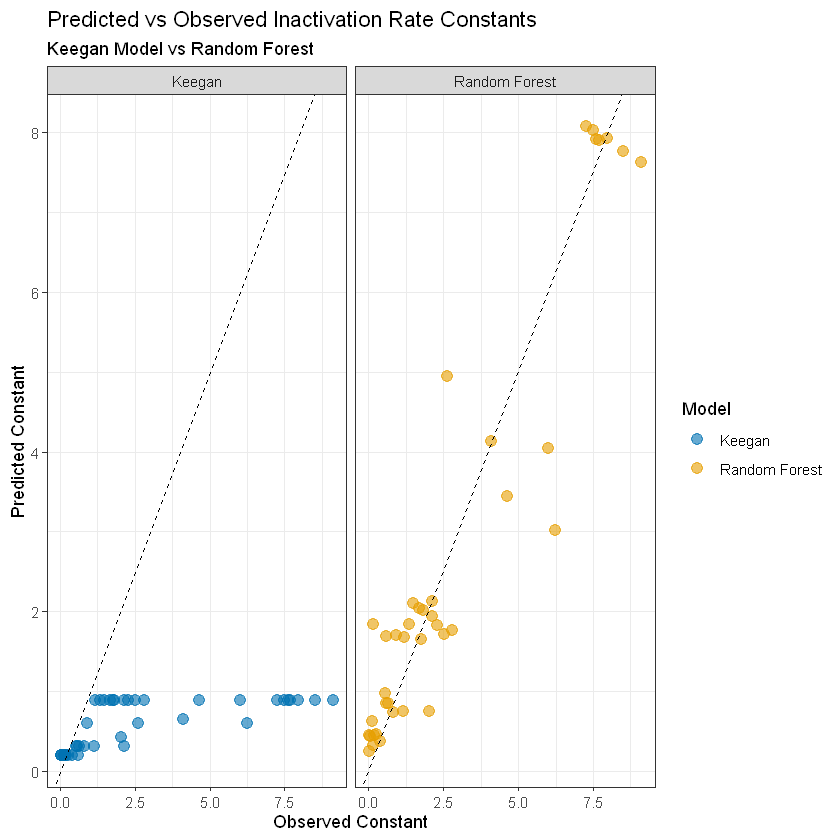

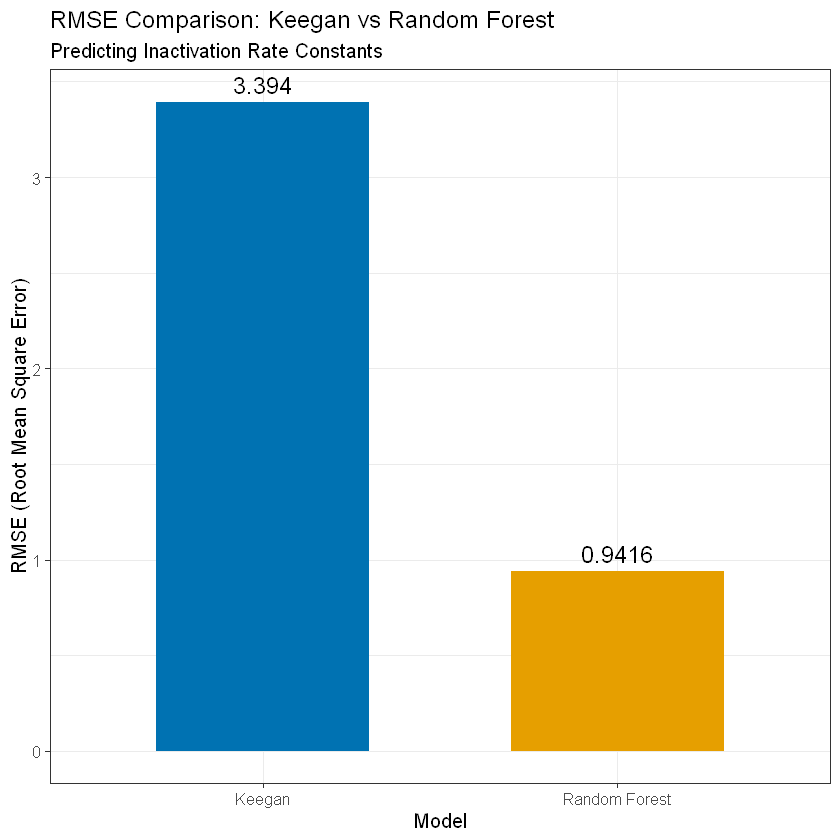

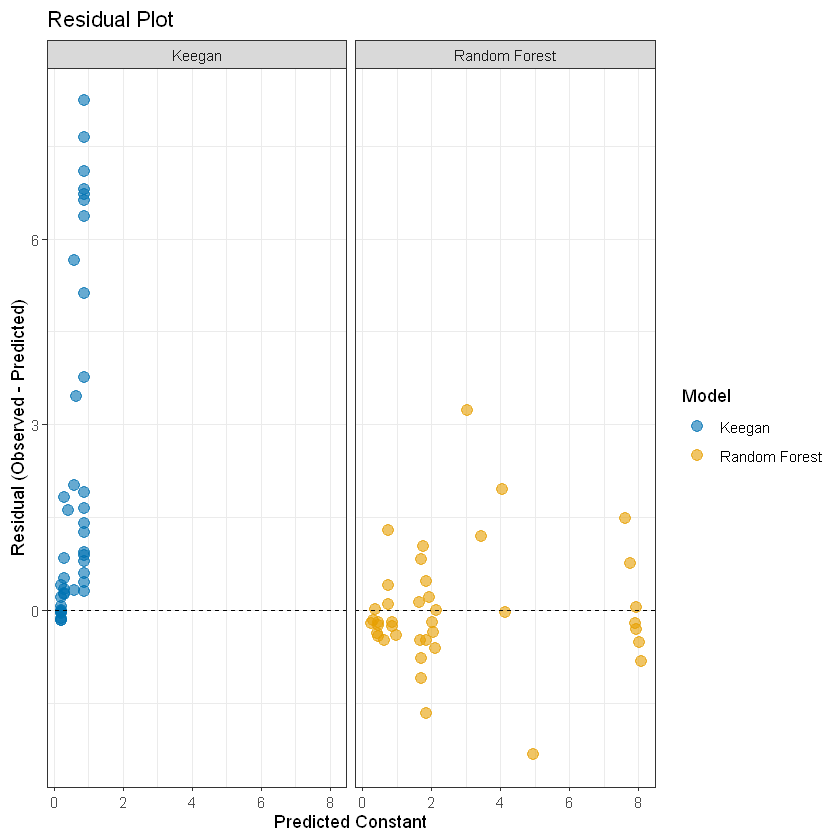

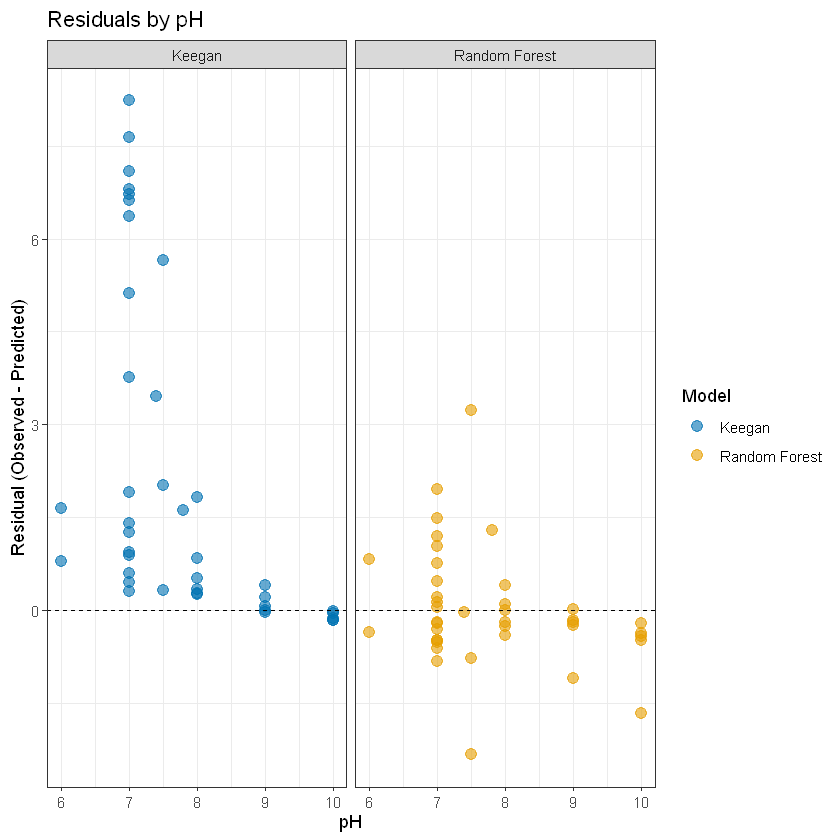

In [12]:
# ========================================
# Compare Keegan Constants vs RF Constants vs Observed
# ========================================

# 1. Extract Keegan's estimated constants (slopes from LRV ~ CT models)
keegan_7 <- cl_keegan %>% filter(pH == 7)
keegan_8 <- cl_keegan %>% filter(pH == 8)
keegan_9 <- cl_keegan %>% filter(pH == 9)

model_keegan_7 <- lm(LRV ~ CT, data = keegan_7)
model_keegan_8 <- lm(LRV ~ CT, data = keegan_8)
model_keegan_9 <- lm(LRV ~ CT, data = keegan_9)

# The CT coefficient (slope) IS the inactivation rate constant
constant_keegan_7 <- coef(model_keegan_7)["CT"]
constant_keegan_8 <- coef(model_keegan_8)["CT"]
constant_keegan_9 <- coef(model_keegan_9)["CT"]

cat("=== Keegan Estimated Constants ===\n")
cat("pH 7 constant:", constant_keegan_7, "\n")
cat("pH 8 constant:", constant_keegan_8, "\n")
cat("pH 9 constant:", constant_keegan_9, "\n\n")

# ========================================
# 2. Create interpolation function for Keegan constants
# ========================================

predict_keegan_constant <- function(pH_val) {
  if (is.na(pH_val)) return(NA)
  
  if (pH_val == 7) {
    return(as.numeric(constant_keegan_7))
  } else if (pH_val == 8) {
    return(as.numeric(constant_keegan_8))
  } else if (pH_val == 9) {
    return(as.numeric(constant_keegan_9))
  } else if (pH_val > 7 && pH_val < 8) {
    # Linear interpolation between pH 7 and 8
    weight <- (pH_val - 7)
    return(as.numeric(constant_keegan_7 * (1 - weight) + constant_keegan_8 * weight))
  } else if (pH_val > 8 && pH_val < 9) {
    # Linear interpolation between pH 8 and 9
    weight <- (pH_val - 8)
    return(as.numeric(constant_keegan_8 * (1 - weight) + constant_keegan_9 * weight))
  } else if (pH_val < 7) {
    # Extrapolate using pH 7
    return(as.numeric(constant_keegan_7))
  } else {
    # Extrapolate using pH 9
    return(as.numeric(constant_keegan_9))
  }
}

# ========================================
# 3. Generate predictions on cl_fit data
# ========================================

# Keegan constants (interpolated for each pH in cl_fit)
keegan_constants <- sapply(cl_fit$pH, predict_keegan_constant)

# RF predictions (already exist from rf_nonlinear model)
rf_constants <- rf_nonlinear$predictions

# Observed constants
observed_constants <- cl_fit$Constant

cat("=== Prediction Summary ===\n")
cat("N observations:", nrow(cl_fit), "\n")
cat("Keegan constants - range:", round(min(keegan_constants, na.rm=TRUE), 4), "to", 
    round(max(keegan_constants, na.rm=TRUE), 4), "\n")
cat("RF constants - range:", round(min(rf_constants, na.rm=TRUE), 4), "to", 
    round(max(rf_constants, na.rm=TRUE), 4), "\n")
cat("Observed constants - range:", round(min(observed_constants, na.rm=TRUE), 4), "to", 
    round(max(observed_constants, na.rm=TRUE), 4), "\n\n")

# ========================================
# 4. Calculate RMSE for both models
# ========================================

# Remove any NA values
valid_idx <- !is.na(observed_constants) & !is.na(keegan_constants) & !is.na(rf_constants)

obs_clean <- observed_constants[valid_idx]
keegan_clean <- keegan_constants[valid_idx]
rf_clean <- rf_constants[valid_idx]

# Calculate RMSE
rmse_keegan <- sqrt(mean((obs_clean - keegan_clean)^2))
rmse_rf_comparison <- sqrt(mean((obs_clean - rf_clean)^2))

# ========================================
# 5. Results
# ========================================

cat("\n=== RMSE COMPARISON ===\n")
cat("RMSE (Keegan model):", round(rmse_keegan, 4), "\n")
cat("RMSE (Random Forest):", round(rmse_rf_comparison, 4), "\n")
cat("Difference (Keegan - RF):", round(rmse_keegan - rmse_rf_comparison, 4), "\n")
cat("Improvement (RF over Keegan):", round((rmse_keegan - rmse_rf_comparison) / rmse_keegan * 100, 2), "%\n\n")

# Create comparison dataframe
comparison_df <- data.frame(
  Model = c("Keegan", "Random Forest"),
  RMSE = c(rmse_keegan, rmse_rf_comparison),
  N_observations = c(sum(valid_idx), sum(valid_idx))
)

print(comparison_df)

# ========================================
# 6. Visualizations
# ========================================

library(ggplot2)

# Create dataframe for plotting
prediction_comparison <- data.frame(
  Observed = rep(obs_clean, 2),
  Predicted = c(keegan_clean, rf_clean),
  Model = rep(c("Keegan", "Random Forest"), each = length(obs_clean)),
  pH = rep(cl_fit$pH[valid_idx], 2),
  Temperature = rep(cl_fit$Temperature[valid_idx], 2)
)

# Plot 1: Predicted vs Observed
p1 <- ggplot(prediction_comparison, aes(x = Observed, y = Predicted, color = Model)) +
  geom_point(alpha = 0.6, size = 3) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  labs(title = "Predicted vs Observed Inactivation Rate Constants",
       subtitle = "Keegan Model vs Random Forest",
       x = "Observed Constant",
       y = "Predicted Constant") +
  theme_bw() +
  facet_wrap(~Model) +
  scale_color_manual(values = c("Keegan" = "#0072B2", "Random Forest" = "#E69F00"))

print(p1)

# Plot 2: RMSE Comparison Bar Chart
p2 <- ggplot(comparison_df, aes(x = Model, y = RMSE, fill = Model)) +
  geom_bar(stat = "identity", width = 0.6) +
  geom_text(aes(label = round(RMSE, 4)), vjust = -0.5, size = 5) +
  labs(title = "RMSE Comparison: Keegan vs Random Forest",
       subtitle = "Predicting Inactivation Rate Constants",
       x = "Model", 
       y = "RMSE (Root Mean Square Error)") +
  theme_bw() +
  theme(legend.position = "none",
        text = element_text(size = 12)) +
  scale_fill_manual(values = c("Keegan" = "#0072B2", "Random Forest" = "#E69F00"))

print(p2)

# Plot 3: Residuals
prediction_comparison$Residual <- prediction_comparison$Observed - prediction_comparison$Predicted

p3 <- ggplot(prediction_comparison, aes(x = Predicted, y = Residual, color = Model)) +
  geom_point(alpha = 0.6, size = 3) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  labs(title = "Residual Plot",
       x = "Predicted Constant",
       y = "Residual (Observed - Predicted)") +
  theme_bw() +
  facet_wrap(~Model) +
  scale_color_manual(values = c("Keegan" = "#0072B2", "Random Forest" = "#E69F00"))

print(p3)

# Plot 4: Residuals by pH
p4 <- ggplot(prediction_comparison, aes(x = pH, y = Residual, color = Model)) +
  geom_point(alpha = 0.6, size = 3) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  labs(title = "Residuals by pH",
       x = "pH",
       y = "Residual (Observed - Predicted)") +
  theme_bw() +
  facet_wrap(~Model) +
  scale_color_manual(values = c("Keegan" = "#0072B2", "Random Forest" = "#E69F00"))

print(p4)


=== MAE COMPARISON ===
MAE (Keegan framework): 2.1727 
MAE (Random Forest): 0.6511 
Difference (Keegan - RF): 1.5216 
Improvement (RF over Keegan): 70.03 %

=== RMSE COMPARISON (for reference) ===
RMSE (Keegan framework): 3.394 


RMSE (Random Forest): 0.9416 
Difference (Keegan - RF): 2.4523 

             Model       MAE      RMSE N_observations
1 Keegan Framework 2.1727007 3.3939771             40
2    Random Forest 0.6511153 0.9416391             40


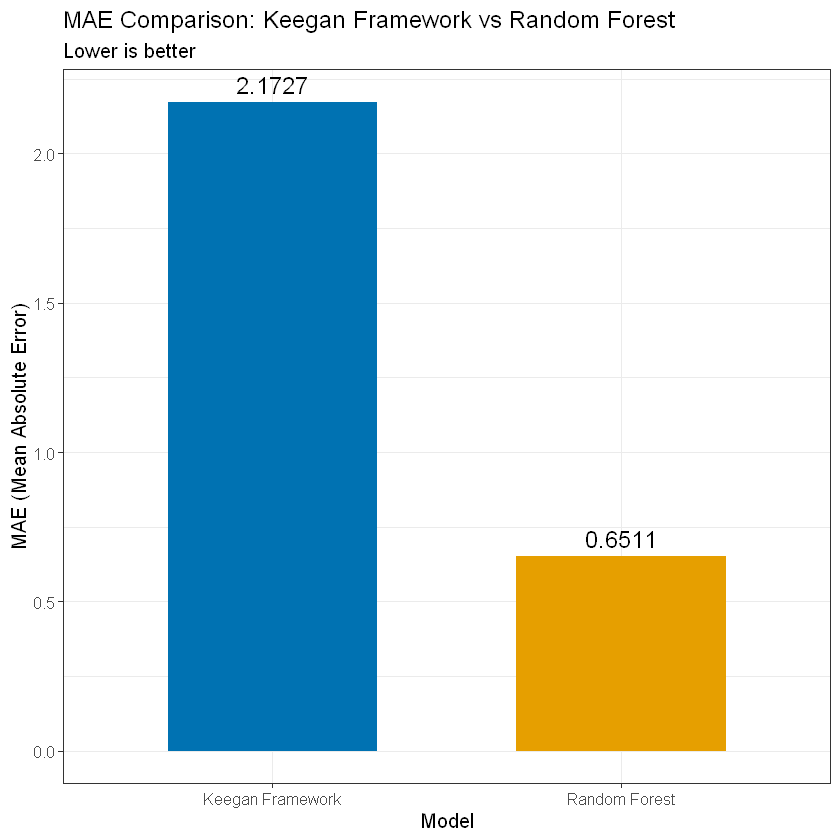

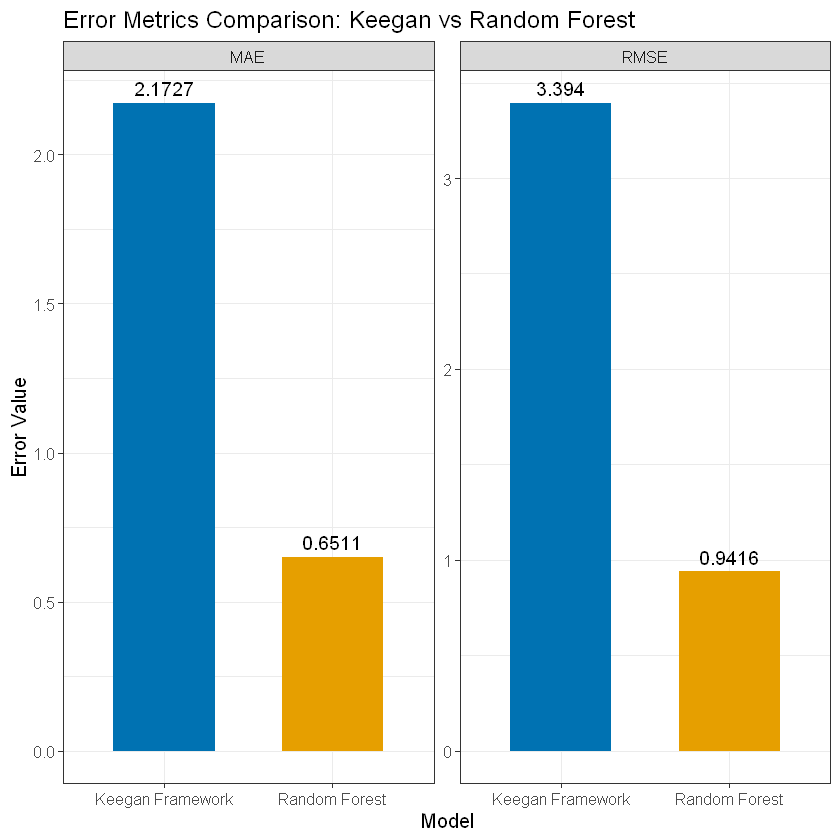

In [13]:
# ========================================
# MAE Comparison: Keegan Framework vs Random Forest
# ========================================

# Use the existing predictions from the RMSE comparison
# (Assuming keegan_constants, rf_constants, and observed_constants already exist)

# Remove any NA values
valid_idx <- !is.na(observed_constants) & !is.na(keegan_constants) & !is.na(rf_constants)

obs_clean <- observed_constants[valid_idx]
keegan_clean <- keegan_constants[valid_idx]
rf_clean <- rf_constants[valid_idx]

# Calculate MAE (Mean Absolute Error)
mae_keegan <- mean(abs(obs_clean - keegan_clean))
mae_rf <- mean(abs(obs_clean - rf_clean))

# Calculate RMSE (for comparison)
rmse_keegan <- sqrt(mean((obs_clean - keegan_clean)^2))
rmse_rf <- sqrt(mean((obs_clean - rf_clean)^2))

# ========================================
# Display Results
# ========================================

cat("\n=== MAE COMPARISON ===\n")
cat("MAE (Keegan framework):", round(mae_keegan, 4), "\n")
cat("MAE (Random Forest):", round(mae_rf, 4), "\n")
cat("Difference (Keegan - RF):", round(mae_keegan - mae_rf, 4), "\n")
cat("Improvement (RF over Keegan):", round((mae_keegan - mae_rf) / mae_keegan * 100, 2), "%\n\n")

cat("=== RMSE COMPARISON (for reference) ===\n")
cat("RMSE (Keegan framework):", round(rmse_keegan, 4), "\n")
cat("RMSE (Random Forest):", round(rmse_rf, 4), "\n")
cat("Difference (Keegan - RF):", round(rmse_keegan - rmse_rf, 4), "\n\n")

# Create comparison dataframe
mae_comparison <- data.frame(
  Model = c("Keegan Framework", "Random Forest"),
  MAE = c(mae_keegan, mae_rf),
  RMSE = c(rmse_keegan, rmse_rf),
  N_observations = c(length(obs_clean), length(obs_clean))
)

print(mae_comparison)

# ========================================
# Visualization
# ========================================

library(ggplot2)

# Bar plot: MAE comparison
p_mae <- ggplot(mae_comparison, aes(x = Model, y = MAE, fill = Model)) +
  geom_bar(stat = "identity", width = 0.6) +
  geom_text(aes(label = round(MAE, 4)), vjust = -0.5, size = 5) +
  labs(title = "MAE Comparison: Keegan Framework vs Random Forest",
       subtitle = "Lower is better",
       x = "Model", 
       y = "MAE (Mean Absolute Error)") +
  theme_bw() +
  theme(legend.position = "none",
        text = element_text(size = 12)) +
  scale_fill_manual(values = c("Keegan Framework" = "#0072B2", 
                                "Random Forest" = "#E69F00"))

print(p_mae)

# Side-by-side bar plot: MAE and RMSE (fixed select issue)
library(tidyr)
mae_comparison_long <- data.frame(
  Model = rep(mae_comparison$Model, 2),
  Metric = rep(c("MAE", "RMSE"), each = 2),
  Value = c(mae_comparison$MAE, mae_comparison$RMSE)
)

p_both <- ggplot(mae_comparison_long, aes(x = Model, y = Value, fill = Model)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.6) +
  geom_text(aes(label = round(Value, 4)), 
            position = position_dodge(width = 0.6), 
            vjust = -0.5, size = 4) +
  facet_wrap(~Metric, scales = "free_y") +
  labs(title = "Error Metrics Comparison: Keegan vs Random Forest",
       x = "Model", 
       y = "Error Value") +
  theme_bw() +
  theme(legend.position = "none",
        text = element_text(size = 12)) +
  scale_fill_manual(values = c("Keegan Framework" = "#0072B2", 
                                "Random Forest" = "#E69F00"))

print(p_both)


=== BIAS ANALYSIS (Mean % Error) ===
Mean % Error (Keegan framework): -11.18 %
  → Keegan framework UNDERPREDICTS by 11.18 %

Mean % Error (Random Forest): 137.39 %


  → Random Forest OVERPREDICTS by 137.39 %

Difference in bias: -148.58 %

             Model       MAE      RMSE N_observations Mean_Pct_Error
1 Keegan Framework 2.1727007 3.3939771             40      -11.18372
2    Random Forest 0.6511153 0.9416391             40      137.39284


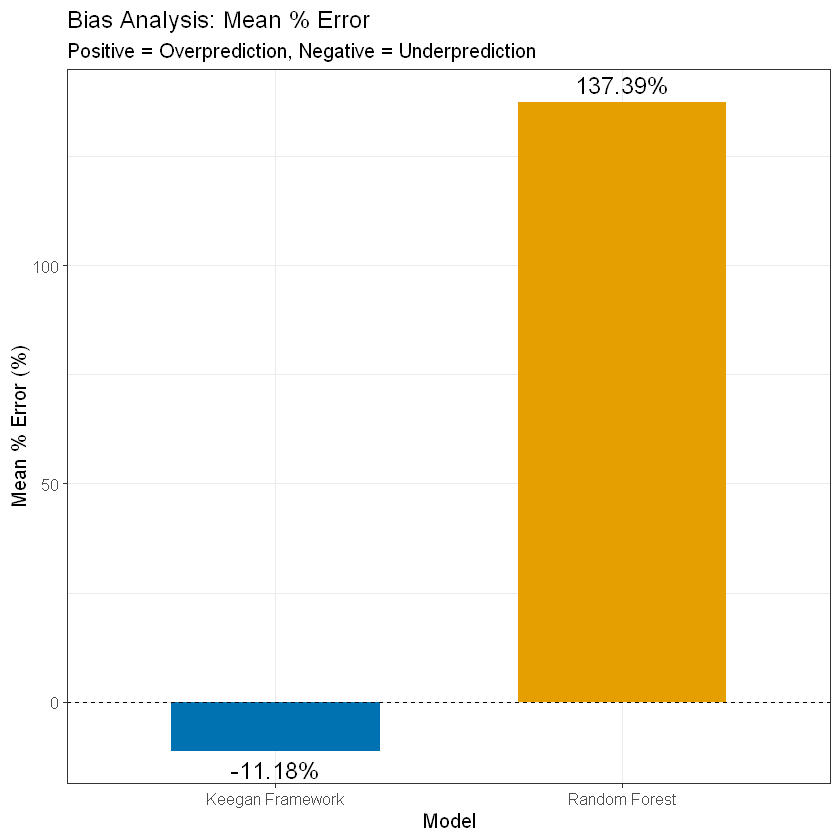

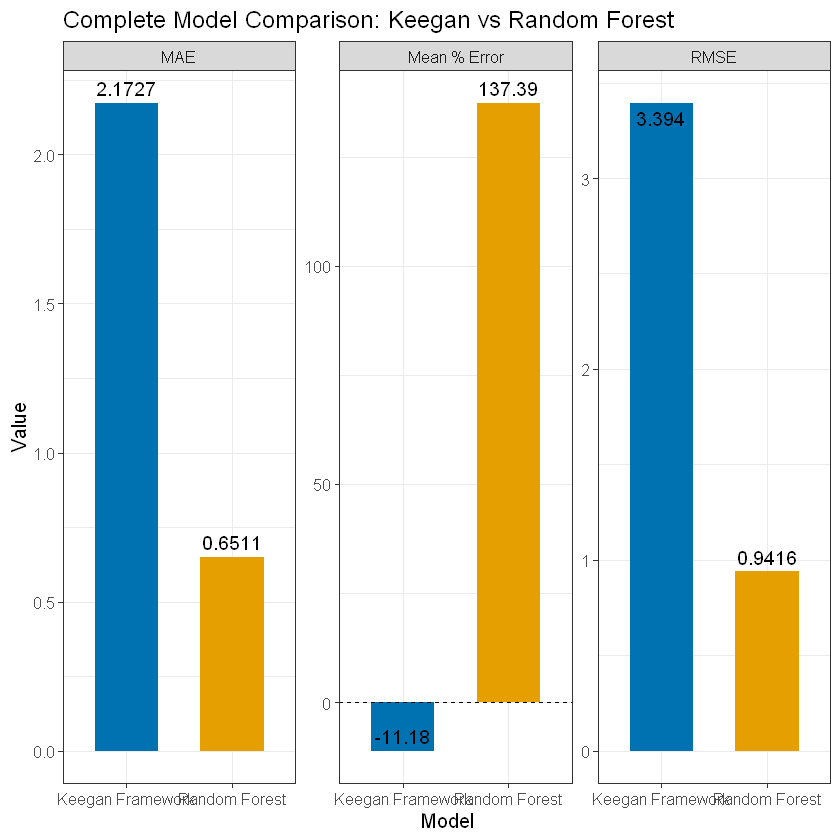

In [14]:
# ========================================
# Bias Analysis: Mean % Error
# Positive = overprediction, Negative = underprediction
# ========================================

# Calculate mean % error for both models
# Mean % Error = mean((predicted - observed) / observed) * 100

# Keegan framework
mean_pct_error_keegan <- mean((keegan_clean - obs_clean) / obs_clean) * 100

# Random Forest
mean_pct_error_rf <- mean((rf_clean - obs_clean) / obs_clean) * 100

# ========================================
# Display Bias Results
# ========================================

cat("\n=== BIAS ANALYSIS (Mean % Error) ===\n")
cat("Mean % Error (Keegan framework):", round(mean_pct_error_keegan, 2), "%\n")
if (mean_pct_error_keegan > 0) {
  cat("  → Keegan framework OVERPREDICTS by", round(mean_pct_error_keegan, 2), "%\n")
} else {
  cat("  → Keegan framework UNDERPREDICTS by", round(abs(mean_pct_error_keegan), 2), "%\n")
}

cat("\nMean % Error (Random Forest):", round(mean_pct_error_rf, 2), "%\n")
if (mean_pct_error_rf > 0) {
  cat("  → Random Forest OVERPREDICTS by", round(mean_pct_error_rf, 2), "%\n")
} else {
  cat("  → Random Forest UNDERPREDICTS by", round(abs(mean_pct_error_rf), 2), "%\n")
}

cat("\nDifference in bias:", round(mean_pct_error_keegan - mean_pct_error_rf, 2), "%\n\n")

# ========================================
# Update Comparison Dataframe
# ========================================

# Add bias to comparison dataframe
mae_comparison$Mean_Pct_Error <- c(mean_pct_error_keegan, mean_pct_error_rf)

print(mae_comparison)

# ========================================
# Visualization: Bias Analysis
# ========================================

# Bar plot: Mean % Error comparison
p_bias <- ggplot(mae_comparison, aes(x = Model, y = Mean_Pct_Error, fill = Model)) +
  geom_bar(stat = "identity", width = 0.6) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black") +
  geom_text(aes(label = paste0(round(Mean_Pct_Error, 2), "%")), 
            vjust = ifelse(mae_comparison$Mean_Pct_Error > 0, -0.5, 1.5), 
            size = 5) +
  labs(title = "Bias Analysis: Mean % Error",
       subtitle = "Positive = Overprediction, Negative = Underprediction",
       x = "Model", 
       y = "Mean % Error (%)") +
  theme_bw() +
  theme(legend.position = "none",
        text = element_text(size = 12)) +
  scale_fill_manual(values = c("Keegan Framework" = "#0072B2", 
                                "Random Forest" = "#E69F00"))

print(p_bias)

# Combined plot: MAE, RMSE, and Bias
comparison_all <- data.frame(
  Model = rep(mae_comparison$Model, 3),
  Metric = rep(c("MAE", "RMSE", "Mean % Error"), each = 2),
  Value = c(mae_comparison$MAE, mae_comparison$RMSE, mae_comparison$Mean_Pct_Error)
)

p_all <- ggplot(comparison_all, aes(x = Model, y = Value, fill = Model)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.6) +
  geom_text(aes(label = round(Value, ifelse(Metric == "Mean % Error", 2, 4))), 
            position = position_dodge(width = 0.6), 
            vjust = ifelse(comparison_all$Metric == "Mean % Error" & comparison_all$Value < 0, 1.5, -0.5), 
            size = 4) +
  facet_wrap(~Metric, scales = "free_y") +
  labs(title = "Complete Model Comparison: Keegan vs Random Forest",
       x = "Model", 
       y = "Value") +
  theme_bw() +
  theme(legend.position = "none",
        text = element_text(size = 12)) +
  scale_fill_manual(values = c("Keegan Framework" = "#0072B2", 
                                "Random Forest" = "#E69F00"))

# Add horizontal line at 0 for Mean % Error panel
p_all <- p_all + geom_hline(data = data.frame(Metric = "Mean % Error", y = 0), 
                            aes(yintercept = y), 
                            linetype = "dashed", color = "black")

print(p_all)


=== COVERAGE ANALYSIS (95% CI) ===

--- Keegan Framework ---
Within 95% CI: 2.5 %
Above 95% CI: 82.5 %
Below 95% CI: 15 %
Mean % Error: -11.18 % (negative = underpredicts)

--- Random Forest ---
Within 95% CI: 92.5 %
Above 95% CI: 5 %
Below 95% CI: 2.5 %
Mean % Error: 137.39 %

             Model Within_CI_Pct Above_CI_Pct Below_CI_Pct Mean_Pct_Error
1 Keegan Framework           2.5         82.5         15.0      -11.18372
2    Random Forest          92.5          5.0          2.5      137.39284
  N_observations
1             40
2             40


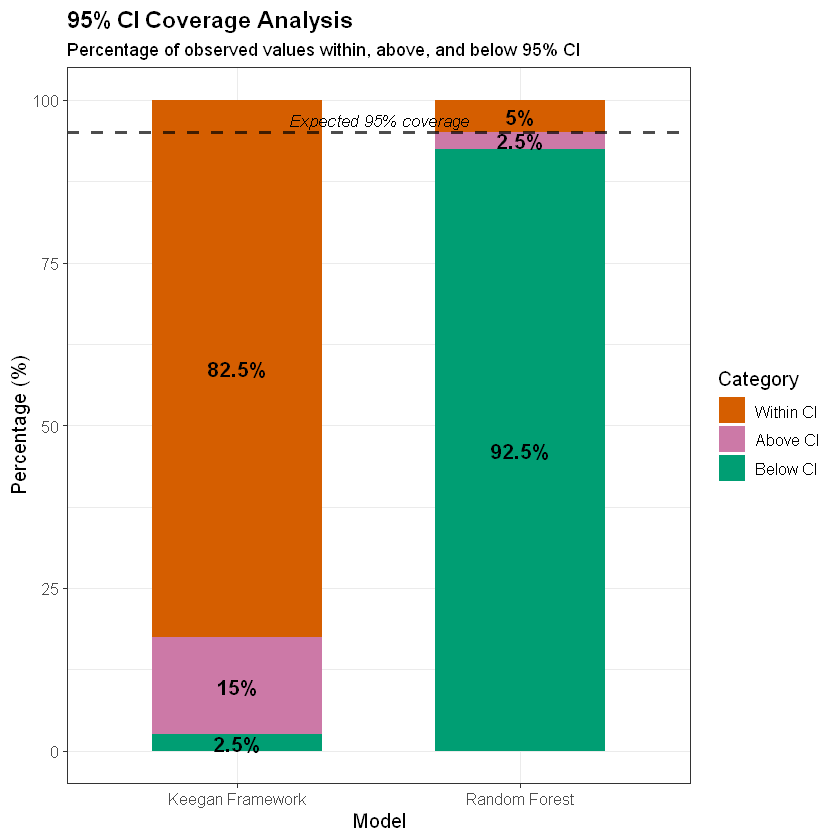

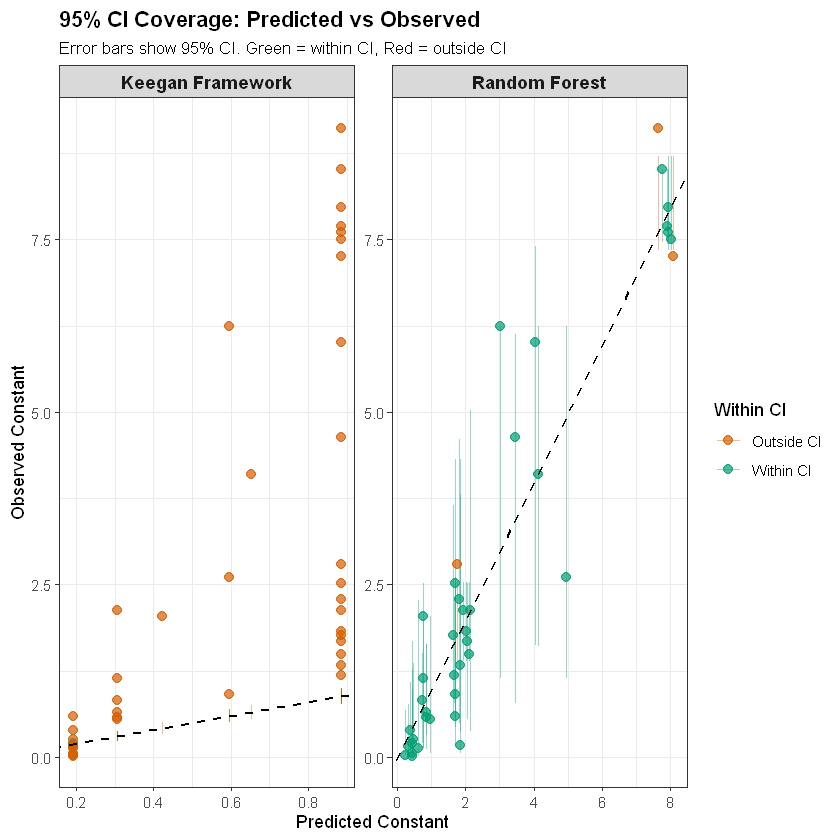

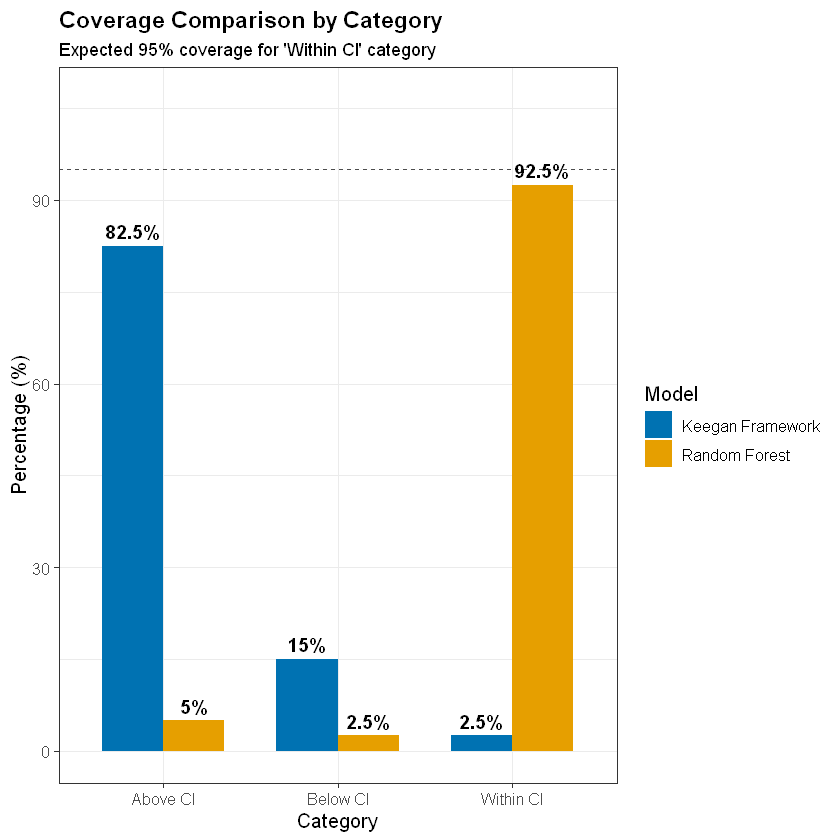

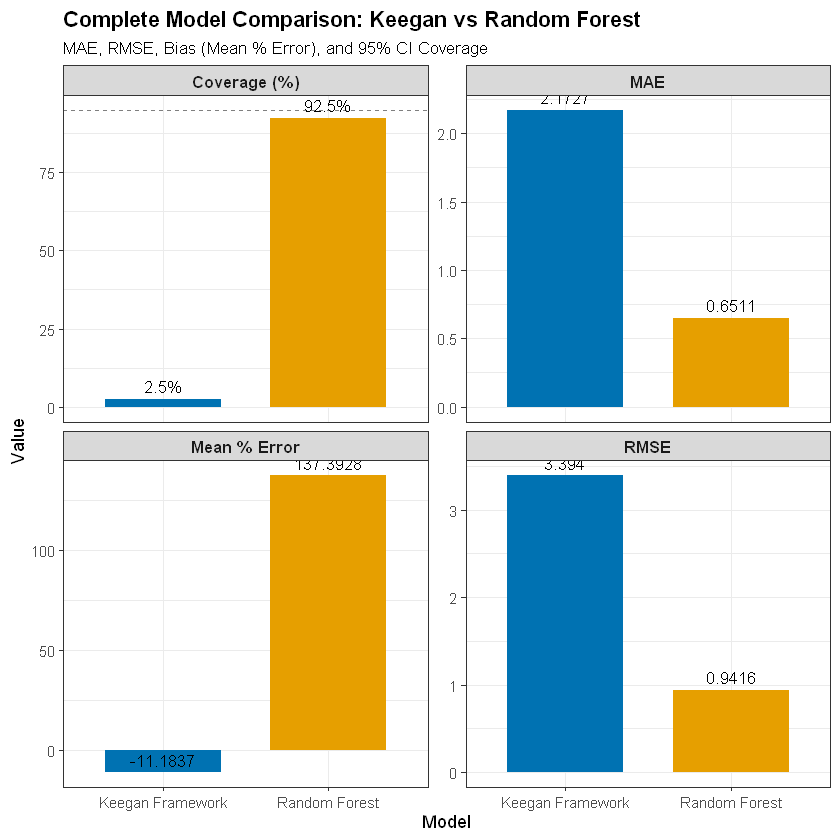

In [15]:
# ========================================
# Coverage Analysis: 95% CI Coverage
# What % of observed values fall within 95% CI vs. above/below predictions
# ========================================

# ========================================
# 1. Calculate 95% CI for Keegan Framework (CORRECTED)
# ========================================

# Get standard errors of the slope (constant) from each model
se_keegan_7 <- summary(model_keegan_7)$coefficients["CT", "Std. Error"]
se_keegan_8 <- summary(model_keegan_8)$coefficients["CT", "Std. Error"]
se_keegan_9 <- summary(model_keegan_9)$coefficients["CT", "Std. Error"]

# Get degrees of freedom for t-distribution
df_7 <- summary(model_keegan_7)$df[2]
df_8 <- summary(model_keegan_8)$df[2]
df_9 <- summary(model_keegan_9)$df[2]

# t-value for 95% CI
t_val_7 <- qt(0.975, df = df_7)
t_val_8 <- qt(0.975, df = df_8)
t_val_9 <- qt(0.975, df = df_9)

# Function to get Keegan constant with proper CI
get_keegan_constant_with_ci <- function(pH_val) {
  if (pH_val == 7) {
    constant <- constant_keegan_7
    se <- se_keegan_7
    t_val <- t_val_7
  } else if (pH_val == 8) {
    constant <- constant_keegan_8
    se <- se_keegan_8
    t_val <- t_val_8
  } else if (pH_val == 9) {
    constant <- constant_keegan_9
    se <- se_keegan_9
    t_val <- t_val_9
  } else if (pH_val > 7 && pH_val < 8) {
    # Interpolate constant
    weight <- (pH_val - 7)
    constant <- constant_keegan_7 * (1 - weight) + constant_keegan_8 * weight
    # Interpolate SE (simplified)
    se <- se_keegan_7 * (1 - weight) + se_keegan_8 * weight
    t_val <- t_val_7
  } else if (pH_val > 8 && pH_val < 9) {
    weight <- (pH_val - 8)
    constant <- constant_keegan_8 * (1 - weight) + constant_keegan_9 * weight
    se <- se_keegan_8 * (1 - weight) + se_keegan_9 * weight
    t_val <- t_val_8
  } else if (pH_val < 7) {
    constant <- constant_keegan_7
    se <- se_keegan_7
    t_val <- t_val_7
  } else {
    constant <- constant_keegan_9
    se <- se_keegan_9
    t_val <- t_val_9
  }
  
  # Calculate 95% CI for the constant
  ci_lower <- constant - t_val * se
  ci_upper <- constant + t_val * se
  
  # Constrain to >= 0
  ci_lower <- pmax(ci_lower, 0)
  
  return(list(pred = constant, lower = ci_lower, upper = ci_upper, se = se))
}

# Calculate CIs for all observations
keegan_ci_lower <- numeric(length(cl_fit$pH))
keegan_ci_upper <- numeric(length(cl_fit$pH))

for (i in 1:length(cl_fit$pH)) {
  ci_result <- get_keegan_constant_with_ci(cl_fit$pH[i])
  keegan_ci_lower[i] <- ci_result$lower
  keegan_ci_upper[i] <- ci_result$upper
}

# ========================================
# 2. Calculate 95% CI for Random Forest
# ========================================

# Use predict.all = TRUE to get multiple predictions, then calculate quantiles
rf_predictions_all <- predict(rf_nonlinear, data = cl_fit, predict.all = TRUE)

# Calculate 95% CI from quantiles of all tree predictions
rf_ci_lower <- apply(rf_predictions_all$predictions, 1, function(x) quantile(x, 0.025))
rf_ci_upper <- apply(rf_predictions_all$predictions, 1, function(x) quantile(x, 0.975))

# Constrain to >= 0
rf_ci_lower <- pmax(rf_ci_lower, 0)
rf_ci_upper <- pmax(rf_ci_upper, 0)

# ========================================
# 3. Calculate Coverage Statistics
# ========================================

# Remove NA values
valid_idx <- !is.na(observed_constants) & !is.na(keegan_constants) & !is.na(rf_constants) &
             !is.na(keegan_ci_lower) & !is.na(keegan_ci_upper) &
             !is.na(rf_ci_lower) & !is.na(rf_ci_upper)

obs_clean <- observed_constants[valid_idx]
keegan_pred_clean <- keegan_constants[valid_idx]
rf_pred_clean <- rf_constants[valid_idx]
keegan_lower_clean <- keegan_ci_lower[valid_idx]
keegan_upper_clean <- keegan_ci_upper[valid_idx]
rf_lower_clean <- rf_ci_lower[valid_idx]
rf_upper_clean <- rf_ci_upper[valid_idx]

# Keegan coverage
keegan_within_ci <- (obs_clean >= keegan_lower_clean) & (obs_clean <= keegan_upper_clean)
keegan_above_ci <- obs_clean > keegan_upper_clean
keegan_below_ci <- obs_clean < keegan_lower_clean

keegan_coverage_pct <- mean(keegan_within_ci) * 100
keegan_above_pct <- mean(keegan_above_ci) * 100
keegan_below_pct <- mean(keegan_below_ci) * 100

# Random Forest coverage
rf_within_ci <- (obs_clean >= rf_lower_clean) & (obs_clean <= rf_upper_clean)
rf_above_ci <- obs_clean > rf_upper_clean
rf_below_ci <- obs_clean < rf_lower_clean

rf_coverage_pct <- mean(rf_within_ci) * 100
rf_above_pct <- mean(rf_above_ci) * 100
rf_below_pct <- mean(rf_below_ci) * 100

# ========================================
# 4. Display Results
# ========================================

cat("\n=== COVERAGE ANALYSIS (95% CI) ===\n")
cat("\n--- Keegan Framework ---\n")
cat("Within 95% CI:", round(keegan_coverage_pct, 2), "%\n")
cat("Above 95% CI:", round(keegan_above_pct, 2), "%\n")
cat("Below 95% CI:", round(keegan_below_pct, 2), "%\n")
cat("Mean % Error:", round(mean_pct_error_keegan, 2), "% (negative = underpredicts)\n")

cat("\n--- Random Forest ---\n")
cat("Within 95% CI:", round(rf_coverage_pct, 2), "%\n")
cat("Above 95% CI:", round(rf_above_pct, 2), "%\n")
cat("Below 95% CI:", round(rf_below_pct, 2), "%\n")
cat("Mean % Error:", round(mean_pct_error_rf, 2), "%\n\n")

# Create coverage comparison dataframe
coverage_comparison <- data.frame(
  Model = c("Keegan Framework", "Random Forest"),
  Within_CI_Pct = c(keegan_coverage_pct, rf_coverage_pct),
  Above_CI_Pct = c(keegan_above_pct, rf_above_pct),
  Below_CI_Pct = c(keegan_below_pct, rf_below_pct),
  Mean_Pct_Error = c(mean_pct_error_keegan, mean_pct_error_rf),
  N_observations = c(length(obs_clean), length(obs_clean))
)

print(coverage_comparison)

# ========================================
# 5. Visualization - Improved Figures
# ========================================

library(ggplot2)

# Figure 1: Coverage bar plot (stacked)
coverage_long <- data.frame(
  Model = rep(coverage_comparison$Model, 3),
  Category = rep(c("Within CI", "Above CI", "Below CI"), each = 2),
  Percentage = c(coverage_comparison$Within_CI_Pct, 
                  coverage_comparison$Above_CI_Pct, 
                  coverage_comparison$Below_CI_Pct)
)

p_coverage <- ggplot(coverage_long, aes(x = Model, y = Percentage, fill = Category)) +
  geom_bar(stat = "identity", position = "stack", width = 0.6) +
  geom_text(aes(label = paste0(round(Percentage, 1), "%")), 
            position = position_stack(vjust = 0.5), size = 4.5, fontface = "bold") +
  geom_hline(yintercept = 95, linetype = "dashed", color = "black", 
             alpha = 0.7, linewidth = 1) +
  annotate("text", x = 1.5, y = 97, label = "Expected 95% coverage", 
           size = 3.5, color = "black", fontface = "italic") +
  labs(title = "95% CI Coverage Analysis",
       subtitle = "Percentage of observed values within, above, and below 95% CI",
       x = "Model", 
       y = "Percentage (%)",
       fill = "Category") +
  theme_bw() +
  theme(text = element_text(size = 12),
        plot.title = element_text(size = 14, face = "bold"),
        plot.subtitle = element_text(size = 11),
        legend.position = "right") +
  scale_fill_manual(values = c("Within CI" = "#009E73", 
                                "Above CI" = "#D55E00", 
                                "Below CI" = "#CC79A7"),
                    labels = c("Within CI", "Above CI", "Below CI")) +
  ylim(0, 100)

print(p_coverage)

# Figure 2: Scatter plot with CI error bars (separate panels)
coverage_data <- data.frame(
  Observed = rep(obs_clean, 2),
  Predicted = c(keegan_pred_clean, rf_pred_clean),
  Lower_CI = c(keegan_lower_clean, rf_lower_clean),
  Upper_CI = c(keegan_upper_clean, rf_upper_clean),
  Within_CI = c(keegan_within_ci, rf_within_ci),
  Model = rep(c("Keegan Framework", "Random Forest"), each = length(obs_clean))
)

p_scatter_ci <- ggplot(coverage_data, aes(x = Predicted, y = Observed)) +
  geom_errorbar(aes(ymin = Lower_CI, ymax = Upper_CI, color = Within_CI), 
                alpha = 0.4, width = 0, linewidth = 0.5) +
  geom_point(aes(color = Within_CI), size = 2.5, alpha = 0.7) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black", linewidth = 0.8) +
  labs(title = "95% CI Coverage: Predicted vs Observed",
       subtitle = "Error bars show 95% CI. Green = within CI, Red = outside CI",
       x = "Predicted Constant",
       y = "Observed Constant",
       color = "Within CI") +
  theme_bw() +
  facet_wrap(~Model, scales = "free") +
  scale_color_manual(values = c("TRUE" = "#009E73", "FALSE" = "#D55E00"),
                     labels = c("TRUE" = "Within CI", "FALSE" = "Outside CI")) +
  theme(text = element_text(size = 11),
        plot.title = element_text(size = 13, face = "bold"),
        plot.subtitle = element_text(size = 10),
        strip.text = element_text(size = 11, face = "bold"))

print(p_scatter_ci)

# Figure 3: Side-by-side comparison of coverage percentages
p_coverage_side <- ggplot(coverage_long, aes(x = Category, y = Percentage, fill = Model)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  geom_text(aes(label = paste0(round(Percentage, 1), "%")), 
            position = position_dodge(width = 0.7), 
            vjust = -0.5, size = 4, fontface = "bold") +
  geom_hline(data = data.frame(Category = "Within CI", y = 95), 
             aes(yintercept = y), linetype = "dashed", color = "black", alpha = 0.7) +
  labs(title = "Coverage Comparison by Category",
       subtitle = "Expected 95% coverage for 'Within CI' category",
       x = "Category", 
       y = "Percentage (%)",
       fill = "Model") +
  theme_bw() +
  theme(text = element_text(size = 12),
        plot.title = element_text(size = 14, face = "bold"),
        plot.subtitle = element_text(size = 11),
        axis.text.x = element_text(angle = 0, hjust = 0.5),
        legend.position = "right") +
  scale_fill_manual(values = c("Keegan Framework" = "#0072B2", 
                                "Random Forest" = "#E69F00")) +
  ylim(0, max(coverage_long$Percentage) * 1.15)

print(p_coverage_side)

# Figure 4: Combined metrics plot (MAE, RMSE, Bias, Coverage)
all_metrics <- data.frame(
  Model = rep(c("Keegan Framework", "Random Forest"), 4),
  Metric = rep(c("MAE", "RMSE", "Mean % Error", "Coverage (%)"), each = 2),
  Value = c(mae_keegan, mae_rf,
            rmse_keegan, rmse_rf,
            mean_pct_error_keegan, mean_pct_error_rf,
            keegan_coverage_pct, rf_coverage_pct)
)

# Normalize values for better visualization (except coverage which is already %)
all_metrics_normalized <- all_metrics
all_metrics_normalized$Value[all_metrics_normalized$Metric == "Coverage (%)"] <- 
  all_metrics_normalized$Value[all_metrics_normalized$Metric == "Coverage (%)"] / 100 * 
  max(all_metrics_normalized$Value[all_metrics_normalized$Metric != "Coverage (%)"], na.rm = TRUE)

p_all_metrics <- ggplot(all_metrics, aes(x = Model, y = Value, fill = Model)) +
  geom_bar(stat = "identity", position = "dodge", width = 0.7) +
  geom_text(aes(label = ifelse(Metric == "Coverage (%)", 
                                paste0(round(Value, 1), "%"),
                                round(Value, 4))), 
            position = position_dodge(width = 0.7), 
            vjust = -0.5, size = 3.5) +
  facet_wrap(~Metric, scales = "free_y", ncol = 2) +
  labs(title = "Complete Model Comparison: Keegan vs Random Forest",
       subtitle = "MAE, RMSE, Bias (Mean % Error), and 95% CI Coverage",
       x = "Model", 
       y = "Value") +
  theme_bw() +
  theme(legend.position = "none",
        text = element_text(size = 11),
        plot.title = element_text(size = 13, face = "bold"),
        plot.subtitle = element_text(size = 10),
        strip.text = element_text(size = 10, face = "bold")) +
  scale_fill_manual(values = c("Keegan Framework" = "#0072B2", 
                                "Random Forest" = "#E69F00")) +
  # Add reference line for coverage
  geom_hline(data = data.frame(Metric = "Coverage (%)", y = 95), 
             aes(yintercept = y), linetype = "dashed", color = "black", alpha = 0.5)

print(p_all_metrics)

# Save figures
ggsave(filename = file.path(fig_dir, "Coverage_Analysis.png"), 
       plot = p_coverage, width = 8, height = 5, dpi = 300)
ggsave(filename = file.path(fig_dir, "Coverage_Scatter.png"), 
       plot = p_scatter_ci, width = 10, height = 5, dpi = 300)
ggsave(filename = file.path(fig_dir, "Coverage_Comparison.png"), 
       plot = p_coverage_side, width = 8, height = 5, dpi = 300)
ggsave(filename = file.path(fig_dir, "All_Metrics_Comparison.png"), 
       plot = p_all_metrics, width = 10, height = 7, dpi = 300)


=== DIAGNOSTIC: Why RF has good coverage but high bias ===

Average CI width:
  Keegan: 0.1648 
  Random Forest: 2.2674 
  RF CI is 13.76 x wider than Keegan

Average prediction / observed ratio:
  Keegan: 0.888 (< 1 = underpredicts, > 1 = overpredicts)
  Random Forest: 2.374 

Average CI center / observed ratio:
  Keegan: 0.888 


  Random Forest: 3.319 

CI asymmetry (upper_width / lower_width, 1 = symmetric):
  Keegan: 1 
  Random Forest: 1.56 

=== Coverage by prediction magnitude ===
Random Forest coverage by prediction tertile:
  Low predictions: 100 %
  Medium predictions: 92.3 %
  High predictions: 84.6 %



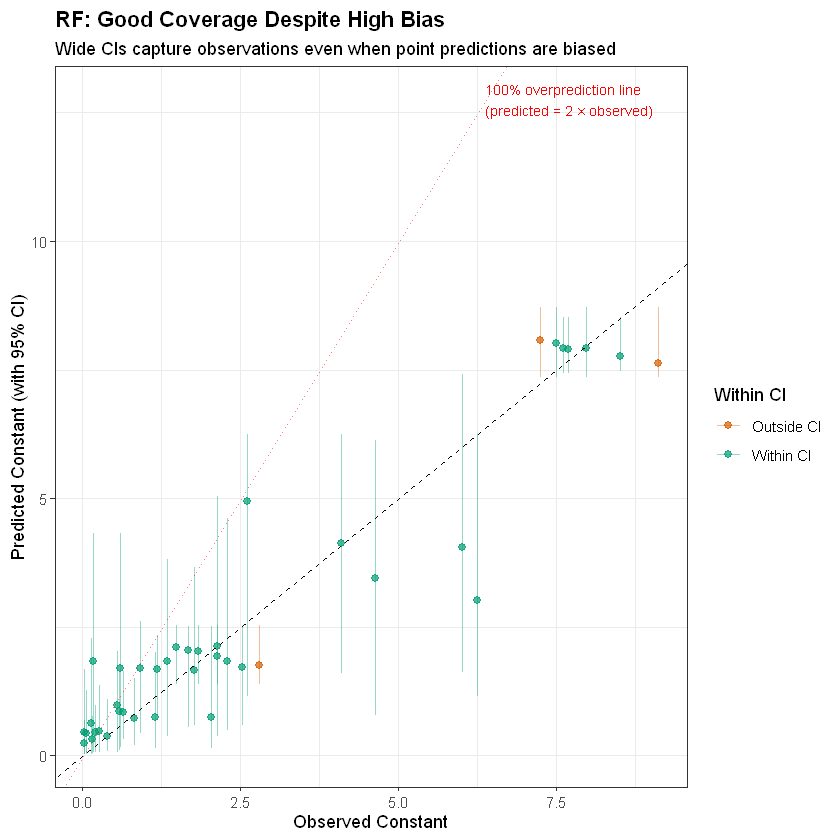

`geom_smooth()` using formula = 'y ~ x'


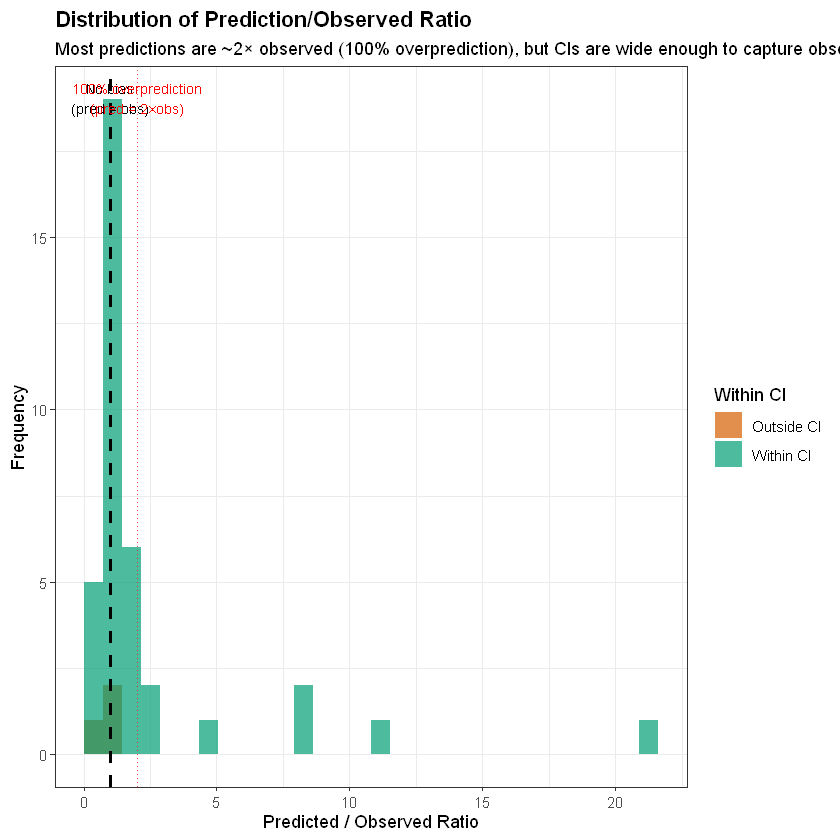


=== KEY INSIGHT ===
RF has good coverage because:
1. CIs are WIDE ( 2.2674  on average)
2. Even though predictions are biased ( 137.4 % overprediction),
3. The wide CIs still capture most observations
4. This suggests RF has good uncertainty quantification but poor point predictions



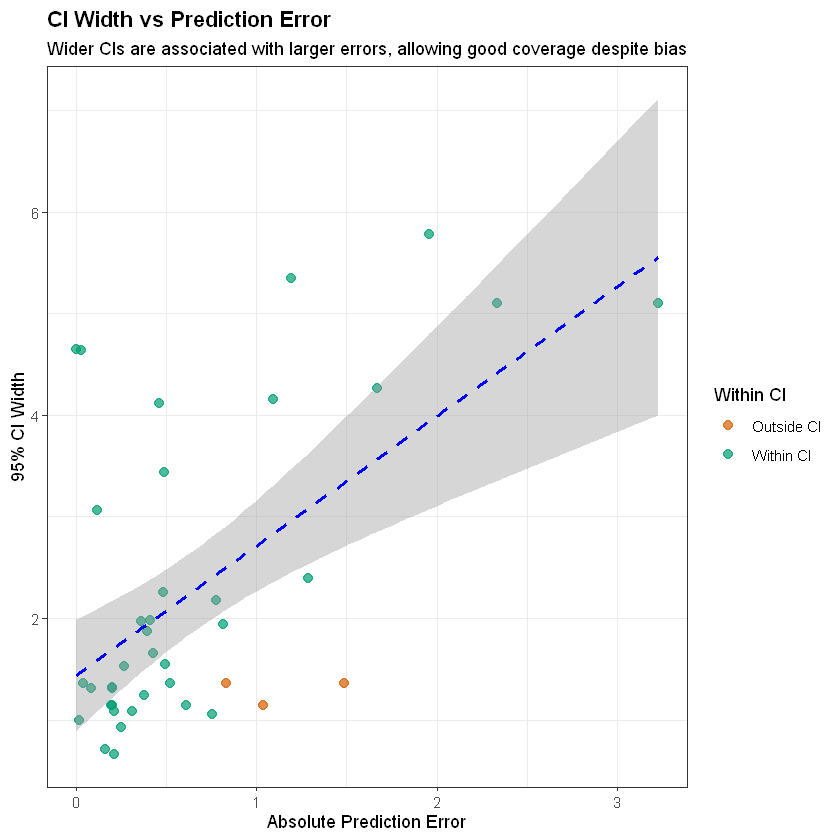

In [16]:
# ========================================
# Diagnostic: Understanding Bias vs Coverage
# ========================================

cat("\n=== DIAGNOSTIC: Why RF has good coverage but high bias ===\n\n")

# Calculate average CI width
keegan_ci_width <- mean(keegan_upper_clean - keegan_lower_clean)
rf_ci_width <- mean(rf_upper_clean - rf_lower_clean)

cat("Average CI width:\n")
cat("  Keegan:", round(keegan_ci_width, 4), "\n")
cat("  Random Forest:", round(rf_ci_width, 4), "\n")
cat("  RF CI is", round(rf_ci_width / keegan_ci_width, 2), "x wider than Keegan\n\n")

# Check where predictions fall relative to observations
keegan_pred_vs_obs <- mean(keegan_pred_clean / obs_clean)
rf_pred_vs_obs <- mean(rf_pred_clean / obs_clean)

cat("Average prediction / observed ratio:\n")
cat("  Keegan:", round(keegan_pred_vs_obs, 3), "(< 1 = underpredicts, > 1 = overpredicts)\n")
cat("  Random Forest:", round(rf_pred_vs_obs, 3), "\n\n")

# Check CI center relative to observations
keegan_ci_center <- (keegan_upper_clean + keegan_lower_clean) / 2
rf_ci_center <- (rf_upper_clean + rf_lower_clean) / 2

keegan_ci_center_vs_obs <- mean(keegan_ci_center / obs_clean)
rf_ci_center_vs_obs <- mean(rf_ci_center / obs_clean)

cat("Average CI center / observed ratio:\n")
cat("  Keegan:", round(keegan_ci_center_vs_obs, 3), "\n")
cat("  Random Forest:", round(rf_ci_center_vs_obs, 3), "\n\n")

# Check if CI is symmetric around prediction
keegan_ci_asymmetry <- mean((keegan_upper_clean - keegan_pred_clean) / (keegan_pred_clean - keegan_lower_clean))
rf_ci_asymmetry <- mean((rf_upper_clean - rf_pred_clean) / (rf_pred_clean - rf_lower_clean))

cat("CI asymmetry (upper_width / lower_width, 1 = symmetric):\n")
cat("  Keegan:", round(keegan_ci_asymmetry, 3), "\n")
cat("  Random Forest:", round(rf_ci_asymmetry, 3), "\n\n")

# Check coverage by prediction range
cat("=== Coverage by prediction magnitude ===\n")
# Split into low, medium, high predictions
rf_pred_tertiles <- quantile(rf_pred_clean, probs = c(0, 1/3, 2/3, 1))
rf_low <- rf_pred_clean <= rf_pred_tertiles[2]
rf_med <- rf_pred_clean > rf_pred_tertiles[2] & rf_pred_clean <= rf_pred_tertiles[3]
rf_high <- rf_pred_clean > rf_pred_tertiles[3]

cat("Random Forest coverage by prediction tertile:\n")
cat("  Low predictions:", round(mean(rf_within_ci[rf_low]) * 100, 1), "%\n")
cat("  Medium predictions:", round(mean(rf_within_ci[rf_med]) * 100, 1), "%\n")
cat("  High predictions:", round(mean(rf_within_ci[rf_high]) * 100, 1), "%\n\n")

# ========================================
# Explanation Plot
# ========================================

# Create diagnostic plot showing the relationship
diagnostic_data <- data.frame(
  Observed = obs_clean,
  RF_Predicted = rf_pred_clean,
  RF_Lower = rf_lower_clean,
  RF_Upper = rf_upper_clean,
  RF_Within_CI = rf_within_ci,
  Ratio = rf_pred_clean / obs_clean
)

# Plot 1: Show how wide CIs can capture observations even with bias
p_diagnostic1 <- ggplot(diagnostic_data, aes(x = Observed, y = RF_Predicted)) +
  geom_errorbar(aes(ymin = RF_Lower, ymax = RF_Upper, color = RF_Within_CI), 
                alpha = 0.4, width = 0) +
  geom_point(aes(color = RF_Within_CI), size = 2, alpha = 0.7) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
  geom_abline(slope = 2, intercept = 0, linetype = "dotted", color = "red", alpha = 0.5) +
  annotate("text", x = max(obs_clean) * 0.7, y = max(obs_clean) * 1.4, 
           label = "100% overprediction line\n(predicted = 2 × observed)", 
           color = "red", size = 3, hjust = 0) +
  labs(title = "RF: Good Coverage Despite High Bias",
       subtitle = "Wide CIs capture observations even when point predictions are biased",
       x = "Observed Constant",
       y = "Predicted Constant (with 95% CI)",
       color = "Within CI") +
  theme_bw() +
  scale_color_manual(values = c("TRUE" = "#009E73", "FALSE" = "#D55E00"),
                     labels = c("TRUE" = "Within CI", "FALSE" = "Outside CI")) +
  theme(text = element_text(size = 11),
        plot.title = element_text(size = 13, face = "bold"))

print(p_diagnostic1)

# Plot 2: Show prediction/observed ratio distribution
p_diagnostic2 <- ggplot(diagnostic_data, aes(x = Ratio, fill = RF_Within_CI)) +
  geom_histogram(bins = 30, alpha = 0.7, position = "identity") +
  geom_vline(xintercept = 1, linetype = "dashed", color = "black", linewidth = 1) +
  geom_vline(xintercept = 2, linetype = "dotted", color = "red", alpha = 0.7) +
  annotate("text", x = 1, y = Inf, label = "No bias\n(pred = obs)", 
           vjust = 1.5, hjust = 0.5, size = 3) +
  annotate("text", x = 2, y = Inf, label = "100% overprediction\n(pred = 2×obs)", 
           vjust = 1.5, hjust = 0.5, size = 3, color = "red") +
  labs(title = "Distribution of Prediction/Observed Ratio",
       subtitle = "Most predictions are ~2× observed (100% overprediction), but CIs are wide enough to capture observations",
       x = "Predicted / Observed Ratio",
       y = "Frequency",
       fill = "Within CI") +
  theme_bw() +
  scale_fill_manual(values = c("TRUE" = "#009E73", "FALSE" = "#D55E00"),
                    labels = c("TRUE" = "Within CI", "FALSE" = "Outside CI")) +
  theme(text = element_text(size = 11),
        plot.title = element_text(size = 13, face = "bold"))

print(p_diagnostic2)

# Plot 3: CI width vs prediction error
diagnostic_data$CI_Width <- rf_upper_clean - rf_lower_clean
diagnostic_data$Absolute_Error <- abs(rf_pred_clean - obs_clean)

p_diagnostic3 <- ggplot(diagnostic_data, aes(x = Absolute_Error, y = CI_Width, color = RF_Within_CI)) +
  geom_point(size = 2.5, alpha = 0.7) +
  geom_smooth(method = "lm", se = TRUE, color = "blue", linetype = "dashed") +
  labs(title = "CI Width vs Prediction Error",
       subtitle = "Wider CIs are associated with larger errors, allowing good coverage despite bias",
       x = "Absolute Prediction Error",
       y = "95% CI Width",
       color = "Within CI") +
  theme_bw() +
  scale_color_manual(values = c("TRUE" = "#009E73", "FALSE" = "#D55E00"),
                     labels = c("TRUE" = "Within CI", "FALSE" = "Outside CI")) +
  theme(text = element_text(size = 11),
        plot.title = element_text(size = 13, face = "bold"))

print(p_diagnostic3)

cat("\n=== KEY INSIGHT ===\n")
cat("RF has good coverage because:\n")
cat("1. CIs are WIDE (", round(rf_ci_width, 4), " on average)\n")
cat("2. Even though predictions are biased (", round(mean_pct_error_rf, 1), "% overprediction),\n")
cat("3. The wide CIs still capture most observations\n")
cat("4. This suggests RF has good uncertainty quantification but poor point predictions\n\n")

## Official

In [17]:
# ========================================
# 1. Calculate Metrics: Keegan vs Random Forest
# ========================================

# Get RF 5th percentile (conservative) predictions for all observations
rf_predictions_all <- predict(rf_nonlinear, data = cl_fit, predict.all = TRUE)
rf_conservative_constants <- apply(rf_predictions_all$predictions, 1, function(x) quantile(x, 0.05))
rf_conservative_constants <- pmax(rf_conservative_constants, 0)

# Prepare clean data
valid_idx <- !is.na(observed_constants) & !is.na(keegan_constants) & !is.na(rf_constants) &
             !is.na(rf_conservative_constants)

obs_clean <- observed_constants[valid_idx]
keegan_clean <- keegan_constants[valid_idx]
rf_mean_clean <- rf_constants[valid_idx]
rf_conservative_clean <- rf_conservative_constants[valid_idx]

# Calculate Metrics for Constants (k values)
# 1. RMSE
rmse_keegan <- sqrt(mean((obs_clean - keegan_clean)^2))
rmse_rf_mean <- sqrt(mean((obs_clean - rf_mean_clean)^2))
rmse_rf_conservative <- sqrt(mean((obs_clean - rf_conservative_clean)^2))

# 2. MAE
mae_keegan <- mean(abs(obs_clean - keegan_clean))
mae_rf_mean <- mean(abs(obs_clean - rf_mean_clean))
mae_rf_conservative <- mean(abs(obs_clean - rf_conservative_clean))

# 3. Mean Bias (%)
mean_bias_keegan <- mean((keegan_clean - obs_clean) / obs_clean) * 100
mean_bias_rf_mean <- mean((rf_mean_clean - obs_clean) / obs_clean) * 100
mean_bias_rf_conservative <- mean((rf_conservative_clean - obs_clean) / obs_clean) * 100

# 4. % observations > prediction
pct_above_keegan <- mean(obs_clean > keegan_clean) * 100
pct_above_rf_mean <- mean(obs_clean > rf_mean_clean) * 100
pct_above_rf_conservative <- mean(obs_clean > rf_conservative_clean) * 100

In [21]:
# ========================================
# 2. Create Comparison Table
# ========================================

comparison_table <- data.frame(
  Metric = c(
    "RMSE",
    "MAE",
    "Mean Bias (%)",
    "% observations > prediction",
    "Coverage"
  ),
  Existing_Table = c(
    sprintf("%.4f", rmse_keegan),
    sprintf("%.4f", mae_keegan),
    sprintf("%.1f%%", mean_bias_keegan),
    sprintf("%.1f%%", pct_above_keegan),
    "Discrete"
  ),
  ML_Model_Mean = c(
    sprintf("%.4f", rmse_rf_mean),
    sprintf("%.4f", mae_rf_mean),
    sprintf("%.1f%%", mean_bias_rf_mean),
    sprintf("%.1f%%", pct_above_rf_mean),
    "Continuous"
  ),
  ML_Model_95LB = c(
    sprintf("%.4f", rmse_rf_conservative),
    sprintf("%.4f", mae_rf_conservative),
    sprintf("%.1f%%", mean_bias_rf_conservative),
    sprintf("%.1f%%", pct_above_rf_conservative),
    "Continuous"
  ),
  stringsAsFactors = FALSE
)

# Print the table
cat("\n========================================\n")
cat("COMPARISON TABLE: MODEL PREDICTIONS (Constants/k values)\n")
cat("========================================\n\n")

cat(sprintf("%-35s | %-15s | %-18s | %-15s\n", 
            "Metric", "Existing Table", "ML Model (mean)", "ML Model (95% LB)"))
cat(paste(rep("-", 85), collapse = ""), "\n")
for (i in 1:nrow(comparison_table)) {
  cat(sprintf("%-35s | %-15s | %-18s | %-15s\n",
              comparison_table$Metric[i],
              comparison_table$Existing_Table[i],
              comparison_table$ML_Model_Mean[i],
              comparison_table$ML_Model_95LB[i]))
}

cat("\n")
print(comparison_table)



COMPARISON TABLE: MODEL PREDICTIONS (Constants/k values)

Metric                              | Existing Table  | ML Model (mean)    | ML Model (95% LB)
------------------------------------------------------------------------------------- 
RMSE                                | 3.3940          | 0.9416             | 1.3582         
MAE                                 | 2.1727          | 0.6511             | 0.8562         
Mean Bias (%)                       | -11.2%          | 137.4%             | -44.3%         
% observations > prediction         | 85.0%           | 40.0%              | 90.0%          
Coverage                            | Discrete        | Continuous         | Continuous     

                       Metric Existing_Table ML_Model_Mean ML_Model_95LB
1                        RMSE         3.3940        0.9416        1.3582
2                         MAE         2.1727        0.6511        0.8562
3               Mean Bias (%)         -11.2%        137.4%        -44.3%
4

Warning message in guide_colorbar(position = "bottom", title.position = "top", title.hjust = 0.5, :
"Arguments in `...` must be used.
✖ Problematic argument:
• margin = margin(t = 0, r = 0, b = 0, l = 0, unit = "pt")
ℹ Did you misspell an argument name?"
Warning message:
"`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`"
Warning message:
"`legend.margin` must be specified using `margin()`
ℹ For the old behavior use `legend.spacing`"
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


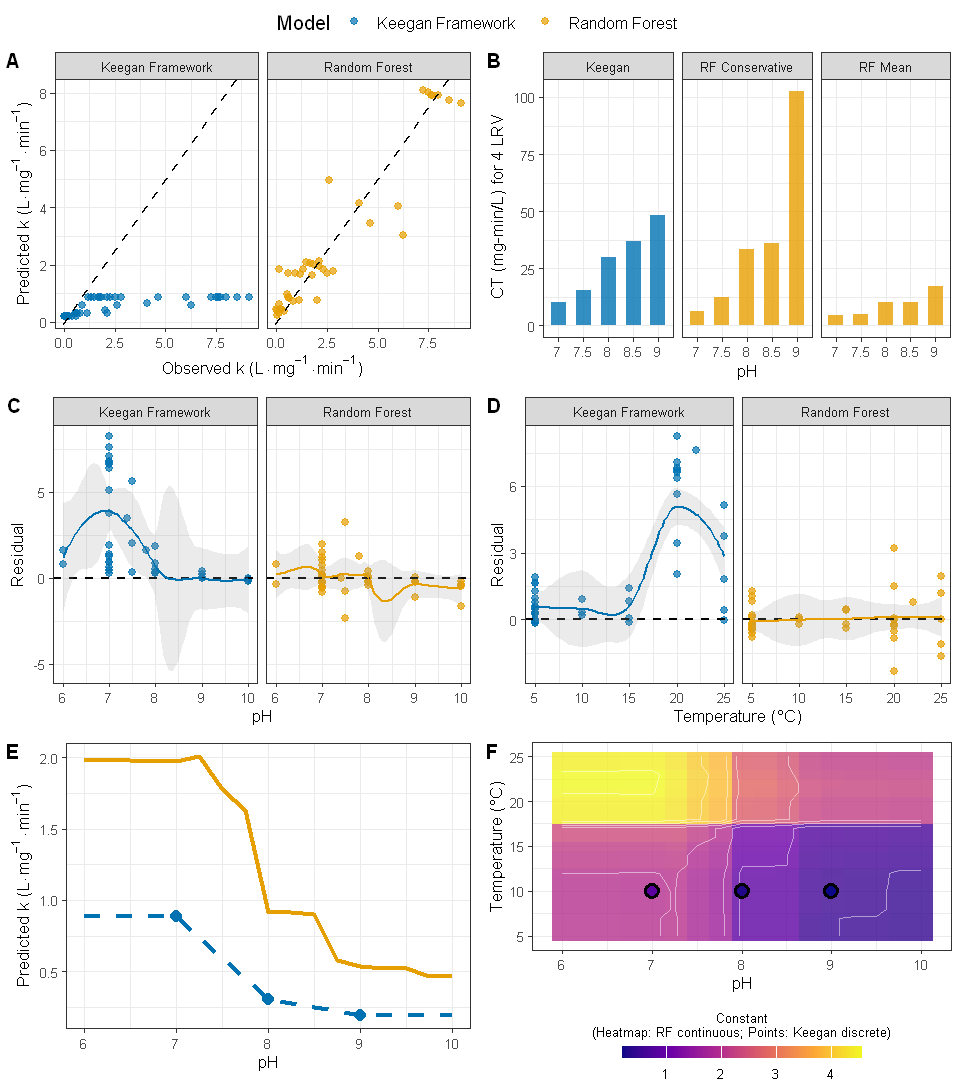

In [27]:
# ========================================
# 3. Create Plots and Combined Figure
# ========================================

library(ggplot2)

# Set plot dimensions for Jupyter (increased height to accommodate text)
options(repr.plot.width = 8, repr.plot.height = 9)

# Prepare data for plots
pH_clean <- cl_fit$pH[valid_idx]
temp_clean <- cl_fit$Temperature[valid_idx]

# Plot 1: Predicted vs Observed
pred_vs_obs_data <- data.frame(
  Observed = rep(obs_clean, 2),
  Predicted = c(keegan_clean, rf_mean_clean),
  Model = rep(c("Keegan Framework", "Random Forest"), each = length(obs_clean))
)

p1_pred_vs_obs <- ggplot(pred_vs_obs_data, aes(x = Observed, y = Predicted, color = Model)) +
  geom_point(size = 2, alpha = 0.7) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black", linewidth = 0.8) +
  labs(x = expression("Observed k (L" %.% "mg"^{-1} %.% "min"^{-1}*")"),
       y = expression("Predicted k (L" %.% "mg"^{-1} %.% "min"^{-1}*")"),
       color = "Model") +
  theme_bw() +
  theme(text = element_text(size = 10),
        legend.position = "right") +
  scale_color_manual(values = c("Keegan Framework" = "#0072B2",
                                "Random Forest" = "#E69F00")) +
  facet_wrap(~Model)

# Plot 2 & 3: Residuals
residual_data <- data.frame(
  Observed = rep(obs_clean, 2),
  Predicted = c(keegan_clean, rf_mean_clean),
  Residual = c(obs_clean - keegan_clean, obs_clean - rf_mean_clean),
  Temperature = rep(temp_clean, 2),
  pH = rep(pH_clean, 2),
  Model = rep(c("Keegan Framework", "Random Forest"), each = length(obs_clean))
)

p2_resid_temp <- ggplot(residual_data, aes(x = Temperature, y = Residual, color = Model)) +
  geom_point(size = 2, alpha = 0.7) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", linewidth = 0.8) +
  geom_smooth(method = "loess", se = TRUE, alpha = 0.2, linewidth = 0.8) +
  labs(x = "Temperature (°C)",
       y = "Residual",
       color = "Model") +
  theme_bw() +
  theme(text = element_text(size = 10),
        legend.position = "right") +
  scale_color_manual(values = c("Keegan Framework" = "#0072B2", 
                                "Random Forest" = "#E69F00")) +
  facet_wrap(~Model)

p3_resid_pH <- ggplot(residual_data, aes(x = pH, y = Residual, color = Model)) +
  geom_point(size = 2, alpha = 0.7) +
  geom_hline(yintercept = 0, linetype = "dashed", color = "black", linewidth = 0.8) +
  geom_smooth(method = "loess", se = TRUE, alpha = 0.2, linewidth = 0.8) +
  labs(x = "pH",
       y = "Residual",
       color = "Model") +
  theme_bw() +
  theme(text = element_text(size = 10),
        legend.position = "right") +
  scale_color_manual(values = c("Keegan Framework" = "#0072B2", 
                                "Random Forest" = "#E69F00")) +
  facet_wrap(~Model)

p2_resid_temp <- p2_resid_temp + theme(legend.position = "none")
p3_resid_pH <- p3_resid_pH + theme(legend.position = "none")

# Plot 4: Interpolation Surface
# Create fine grid for RF predictions
pH_seq <- seq(6, 10, by = 0.25)
temp_seq <- seq(5, 25, by = 1)
grid_fine <- expand.grid(pH = pH_seq, Temperature = temp_seq)
grid_fine$pH_squared <- grid_fine$pH^2
grid_fine$TemperaturexpH <- grid_fine$Temperature * grid_fine$pH
grid_fine$Temperature_squared <- grid_fine$Temperature^2

# Add study effects (set to 0 for visualization)
grid_fine$StudyEffect_Intercept <- 0
grid_fine$StudyEffect_pH <- 0
grid_fine$StudyEffect_Temperature <- 0

# RF predictions on grid
grid_fine$RF_Prediction <- pmax(predict(rf_nonlinear, data = grid_fine)$predictions, 0)

# Keegan grid (only pH 7, 8, 9 at temperature 10°C)
keegan_grid <- expand.grid(pH = c(7, 8, 9), Temperature = 10)
keegan_grid$Constant <- sapply(keegan_grid$pH, predict_keegan_constant)

# Add a column to keegan_grid to identify it for the legend
keegan_grid$Source <- "Keegan Framework"

p4_interp_surface <- ggplot(grid_fine, aes(x = pH, y = Temperature)) +
  geom_raster(aes(fill = RF_Prediction), alpha = 0.8) +
  geom_contour(aes(z = RF_Prediction), color = "white", alpha = 0.5, linewidth = 0.5) +
  geom_point(data = keegan_grid, aes(x = pH, y = Temperature, fill = Constant), 
             size = 3, shape = 21, color = "black", stroke = 1.5) +
  scale_fill_viridis_c(name = "Constant\n(Heatmap: RF continuous; Points: Keegan discrete)", 
                       option = "plasma",
                       guide = guide_colorbar(position = "bottom",
                                               title.position = "top",
                                               title.hjust = 0.5,
                                               barwidth = 10,
                                               barheight = 0.5,
                                               title.theme = element_text(size = 8),
                                               margin = margin(t = 0, r = 0, b = 0, l = 0, unit = "pt"))) +
  labs(x = "pH",
       y = "Temperature (°C)") +
  theme_bw() +
  theme(text = element_text(size = 10),
        legend.position = "bottom",
        legend.box = "horizontal",
        legend.margin = unit(c(0, 0, 0, 0), "pt"),
        plot.margin = unit(c(5, 5, 0, 5), "pt"))

# Plot 5: Cross-section at fixed temperature (10°C to match Keegan data)
temp_fixed <- 10
grid_temp_fixed <- grid_fine[abs(grid_fine$Temperature - temp_fixed) < 0.1, ]
grid_temp_fixed$Keegan_Prediction <- sapply(grid_temp_fixed$pH, predict_keegan_constant)

p5_interp_cross <- ggplot(grid_temp_fixed, aes(x = pH)) +
  geom_line(aes(y = RF_Prediction, color = "Random Forest"), linewidth = 1.2) +
  geom_line(aes(y = Keegan_Prediction, color = "Keegan Framework"), 
            linewidth = 1.2, linetype = "dashed") +
  geom_point(data = keegan_grid, 
             aes(y = Constant, color = "Keegan Framework"), 
             size = 3, shape = 16) +
  labs(x = "pH",
       y = expression("Predicted k (L" %.% "mg"^{-1} %.% "min"^{-1}*")"),
       color = "Model") +
  theme_bw() +
  theme(text = element_text(size = 10),
        legend.position = "right") +
  scale_color_manual(values = c("Random Forest" = "#E69F00",
                                "Keegan Framework" = "#0072B2"))

p5_interp_cross <- p5_interp_cross + theme(legend.position = "none")

# Plot 6: Conservatism Comparison
# Use fixed temperature of 10°C for all pH values (matching plot E and Keegan data availability)
representative_conditions <- data.frame(
  pH = c(7, 7.5, 8, 8.5, 9),
  Temperature = 10  # Fixed at 10°C for all pH values
)

calculate_ct_4log <- function(constant) {
  ifelse(constant > 0, 9.21 / constant, NA)
}

# Keegan predictions
keegan_ct_mean <- sapply(representative_conditions$pH, function(pH_val) {
  k <- predict_keegan_constant(pH_val)
  calculate_ct_4log(k)
})

# RF predictions
representative_conditions$pH_squared <- representative_conditions$pH^2
representative_conditions$TemperaturexpH <- representative_conditions$Temperature * representative_conditions$pH
representative_conditions$Temperature_squared <- representative_conditions$Temperature^2
representative_conditions$StudyEffect_Intercept <- 0
representative_conditions$StudyEffect_pH <- 0
representative_conditions$StudyEffect_Temperature <- 0

rf_pred_all <- predict(rf_nonlinear, data = representative_conditions, predict.all = TRUE)
rf_ct_mean <- apply(rf_pred_all$predictions, 1, function(x) calculate_ct_4log(mean(x)))
rf_ct_conservative <- apply(rf_pred_all$predictions, 1, function(x) {
  k_conservative <- quantile(x, 0.05)
  calculate_ct_4log(pmax(k_conservative, 0))
})

conservatism_data <- data.frame(
  pH = rep(representative_conditions$pH, 3),
  Model = rep(c("Keegan", "RF Mean", "RF Conservative"), each = nrow(representative_conditions)),
  CT_Value = c(keegan_ct_mean, rf_ct_mean, rf_ct_conservative),
  Type = rep(c("Mean", "Mean", "Conservative (5th %ile)"), each = nrow(representative_conditions))
)

# Create a combined fill variable to distinguish colors
conservatism_data$Fill_Type <- ifelse(conservatism_data$Model == "Keegan", "Keegan",
                                      ifelse(conservatism_data$Model == "RF Mean", "RF Mean",
                                             "RF Conservative"))

p6_conservatism <- ggplot(conservatism_data, aes(x = factor(pH), y = CT_Value, fill = Fill_Type)) +      
  geom_bar(stat = "identity", position = position_dodge(width = 0.7), width = 0.6, alpha = 0.8) +  
  facet_wrap(~Model, scales = "fixed") +
  labs(x = "pH",
       y = expression("CT (mg-min/L) for 4 LRV"),
       fill = "Prediction Type") +
  theme_bw() +
  theme(text = element_text(size = 10),
        legend.position = "right") +
  scale_fill_manual(values = c("Keegan" = "#0072B2",
                               "RF Mean" = "#E69F00",
                               "RF Conservative" = "#E69F00"))

# Combined plot: 3 rows x 2 columns
# Extract common legend and preserve plot 4's individual legend
library(cowplot)

# Get common legend from plot A (for plots A-C and E) and make it horizontal
# First, create a version of p1 with horizontal legend and reduced margins
p1_horizontal_legend <- p1_pred_vs_obs + 
  theme(text = element_text(size = 12),
        legend.position = "top",
        legend.direction = "horizontal",
        legend.margin = unit(c(0, 0, 0, 0), "pt"),
        legend.box.margin = unit(c(0, 0, 0, 0), "pt"))
common_legend <- cowplot::get_legend(p1_horizontal_legend)

# Remove legends from plots that will use common legend
p1_no_legend <- p1_pred_vs_obs + theme(legend.position = "none")
p2_no_legend <- p2_resid_temp  # Already has legend.position = "none"
p3_no_legend <- p3_resid_pH    # Already has legend.position = "none"
p5_no_legend <- p5_interp_cross # Already has legend.position = "none"
p6_no_legend <- p6_conservatism + theme(legend.position = "none")

# Arrange plots (plot 4 keeps its own legend)
p_plots <- ggarrange(
  p1_no_legend,      # Row 1, Col 1
  p6_no_legend,      # Row 1, Col 2
  p3_no_legend,      # Row 2, Col 1
  p2_no_legend,      # Row 2, Col 2
  p5_no_legend,      # Row 3, Col 1
  p4_interp_surface, # Row 3, Col 2 (keeps its own legend)
  ncol = 2, 
  nrow = 3,
  labels = c("A", "B", "C", "D", "E", "F"),
  font.label = list(size = 12, face = "bold")
)

# Combine: common legend at top, plots below, plot 4's legend stays with it
# Reduced height for legend to minimize spacing
p_combined <- ggarrange(common_legend, p_plots, 
                        ncol = 1, nrow = 2,
                        heights = c(0.04, 0.96))

print(p_combined)

# Save the combined plot (increased height to accommodate text)
ggsave(filename = file.path(fig_dir, "Figure_S9.png"), 
       plot = p_combined, width = 8, height = 9, dpi = 300)
